In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
import numpy as np
from util import getHashId, pickleLoad

feature_selection = pickleLoad('data/feature_selection.pkl')
features_oc = np.load('data/preprocessed/features_vox.npy')
exc = 30
features = [f for f in features_oc if f not in feature_selection['excludeds'][exc][np.argmax(feature_selection['accuracies'][exc])]]

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : features,
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_glcm_Contrast_glcm_Correlation_glcm_DifferenceEntropy_glcm_DifferenceVariance_glcm_JointEnergy_glcm_JointEntropy_glcm_Imc2_glcm_Idm_glcm_MCC_glcm_Idmn_glcm_Id_glcm_Idn_glcm_InverseVariance_glcm_MaximumProbability_glcm_SumEntropy_glcm_SumSquares_glszm_SmallAreaEmphasis_glszm_LargeAreaEmphasis_glszm_GrayLevelNonUniformity_glszm_GrayLevelNonUniformityNormalized_glszm_SizeZoneNonUniformity_glszm_SizeZoneNonUniformityNormalized_glszm_ZonePercentage_glszm_GrayLevelVariance_glszm_ZoneEntropy_glszm_HighGrayLevelZoneEmphasis_glszm_LargeAreaLowGrayLevelEmphasis_glszm_LargeAreaHighGrayLevelEmphasis_glrlm_ShortRunEmphasis_glrlm_LongRunEmphasis_glrlm_GrayLevelNonUniformity_glrlm_GrayLevelNonUniformityNormalized_glrlm_RunLengthNonUniformity_glrlm_RunLengthNonUniformityNormalized_glrlm_RunPercentage_glrlm_GrayLevelVariance_glrlm_RunVariance_glrlm_RunEntropy_glrlm_LowGrayLevelRunEmphasis_glrlm_HighGrayLevelRunEmphasis_glrlm_ShortR

In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(657450, 558)
(657450, 8)
validation
(74368, 558)
(74368, 8)
test
(91684, 558)
(91684, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 558)]             0         


 dense (Dense)               (None, 1024)              572416    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1262472 (4.82 MB)


Trainable params: 1262472 (4.82 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/66 [..............................] - ETA: 1:49 - loss: 2.3300 - STD: 0.0706 - MAE: 0.2246

 4/66 [>.............................] - ETA: 1s - loss: 1.7353 - STD: 0.1058 - MAE: 0.1883  

 6/66 [=>............................] - ETA: 1s - loss: 1.6072 - STD: 0.1453 - MAE: 0.1699

 8/66 [==>...........................] - ETA: 2s - loss: 1.5415 - STD: 0.1684 - MAE: 0.1592

10/66 [===>..........................] - ETA: 2s - loss: 1.5020 - STD: 0.1798 - MAE: 0.1538

12/66 [====>.........................] - ETA: 2s - loss: 1.4729 - STD: 0.1836 - MAE: 0.1517

14/66 [=====>........................] - ETA: 2s - loss: 1.4535 - STD: 0.1838 - MAE: 0.1511

16/66 [======>.......................] - ETA: 2s - loss: 1.4392 - STD: 0.1834 - MAE: 0.1510

17/66 [======>.......................] - ETA: 4s - loss: 1.4341 - STD: 0.1834 - MAE: 0.1508

20/66 [========>.....................] - ETA: 4s - loss: 1.4187 - STD: 0.1848 - MAE: 0.1500

22/66 [=========>....................] - ETA: 3s - loss: 1.4095 - STD: 0.1866 - MAE: 0.1491

24/66 [=========>....................] - ETA: 3s - loss: 1.4030 - STD: 0.1884 - MAE: 0.1483

26/66 [==========>...................] - ETA: 3s - loss: 1.3956 - STD: 0.1898 - MAE: 0.1476

28/66 [===========>..................] - ETA: 2s - loss: 1.3901 - STD: 0.1905 - MAE: 0.1472

30/66 [============>.................] - ETA: 2s - loss: 1.3852 - STD: 0.1907 - MAE: 0.1470

32/66 [=============>................] - ETA: 2s - loss: 1.3807 - STD: 0.1904 - MAE: 0.1470

34/66 [==============>...............] - ETA: 2s - loss: 1.3770 - STD: 0.1900 - MAE: 0.1471

36/66 [===============>..............] - ETA: 2s - loss: 1.3731 - STD: 0.1896 - MAE: 0.1472

38/66 [================>.............] - ETA: 1s - loss: 1.3702 - STD: 0.1896 - MAE: 0.1471

40/66 [=================>............] - ETA: 1s - loss: 1.3673 - STD: 0.1898 - MAE: 0.1470

42/66 [==================>...........] - ETA: 1s - loss: 1.3640 - STD: 0.1901 - MAE: 0.1468

44/66 [===================>..........] - ETA: 1s - loss: 1.3614 - STD: 0.1905 - MAE: 0.1466

46/66 [===================>..........] - ETA: 1s - loss: 1.3597 - STD: 0.1908 - MAE: 0.1465

48/66 [====================>.........] - ETA: 1s - loss: 1.3578 - STD: 0.1909 - MAE: 0.1464

50/66 [=====================>........] - ETA: 0s - loss: 1.3551 - STD: 0.1909 - MAE: 0.1463

52/66 [======================>.......] - ETA: 0s - loss: 1.3534 - STD: 0.1908 - MAE: 0.1463

54/66 [=======================>......] - ETA: 0s - loss: 1.3522 - STD: 0.1907 - MAE: 0.1463

56/66 [========================>.....] - ETA: 0s - loss: 1.3510 - STD: 0.1907 - MAE: 0.1463

58/66 [=========================>....] - ETA: 0s - loss: 1.3499 - STD: 0.1907 - MAE: 0.1463

60/66 [==========================>...] - ETA: 0s - loss: 1.3485 - STD: 0.1907 - MAE: 0.1463

62/66 [===========================>..] - ETA: 0s - loss: 1.3471 - STD: 0.1908 - MAE: 0.1463

64/66 [============================>.] - ETA: 0s - loss: 1.3457 - STD: 0.1908 - MAE: 0.1462

66/66 [==============================] - ETA: 0s - loss: 1.3445 - STD: 0.1909 - MAE: 0.1462

66/66 [==============================] - 6s 68ms/step - loss: 1.3445 - STD: 0.1909 - MAE: 0.1462 - val_loss: 1.2455 - val_STD: 0.1925 - val_MAE: 0.1417


Epoch 2/10000


 1/66 [..............................] - ETA: 4s - loss: 1.3243 - STD: 0.1925 - MAE: 0.1459

 2/66 [..............................] - ETA: 3s - loss: 1.3164 - STD: 0.1922 - MAE: 0.1454

 4/66 [>.............................] - ETA: 3s - loss: 1.3128 - STD: 0.1918 - MAE: 0.1454

 6/66 [=>............................] - ETA: 2s - loss: 1.3102 - STD: 0.1915 - MAE: 0.1454

 8/66 [==>...........................] - ETA: 2s - loss: 1.3123 - STD: 0.1912 - MAE: 0.1456

10/66 [===>..........................] - ETA: 2s - loss: 1.3105 - STD: 0.1912 - MAE: 0.1455

12/66 [====>.........................] - ETA: 2s - loss: 1.3104 - STD: 0.1913 - MAE: 0.1454

14/66 [=====>........................] - ETA: 2s - loss: 1.3064 - STD: 0.1915 - MAE: 0.1451

16/66 [======>.......................] - ETA: 2s - loss: 1.3075 - STD: 0.1918 - MAE: 0.1451

18/66 [=======>......................] - ETA: 2s - loss: 1.3070 - STD: 0.1921 - MAE: 0.1450

20/66 [========>.....................] - ETA: 2s - loss: 1.3058 - STD: 0.1921 - MAE: 0.1449

22/66 [=========>....................] - ETA: 2s - loss: 1.3068 - STD: 0.1921 - MAE: 0.1449

24/66 [=========>....................] - ETA: 1s - loss: 1.3073 - STD: 0.1920 - MAE: 0.1450

26/66 [==========>...................] - ETA: 1s - loss: 1.3076 - STD: 0.1919 - MAE: 0.1451

27/66 [===========>..................] - ETA: 1s - loss: 1.3071 - STD: 0.1919 - MAE: 0.1450

28/66 [===========>..................] - ETA: 1s - loss: 1.3073 - STD: 0.1918 - MAE: 0.1451

30/66 [============>.................] - ETA: 1s - loss: 1.3072 - STD: 0.1919 - MAE: 0.1450

32/66 [=============>................] - ETA: 1s - loss: 1.3080 - STD: 0.1920 - MAE: 0.1450

34/66 [==============>...............] - ETA: 1s - loss: 1.3079 - STD: 0.1920 - MAE: 0.1450

36/66 [===============>..............] - ETA: 1s - loss: 1.3076 - STD: 0.1920 - MAE: 0.1450

38/66 [================>.............] - ETA: 1s - loss: 1.3077 - STD: 0.1920 - MAE: 0.1450

40/66 [=================>............] - ETA: 1s - loss: 1.3078 - STD: 0.1920 - MAE: 0.1450

42/66 [==================>...........] - ETA: 1s - loss: 1.3083 - STD: 0.1920 - MAE: 0.1451

44/66 [===================>..........] - ETA: 1s - loss: 1.3078 - STD: 0.1919 - MAE: 0.1451

46/66 [===================>..........] - ETA: 0s - loss: 1.3077 - STD: 0.1919 - MAE: 0.1450

48/66 [====================>.........] - ETA: 0s - loss: 1.3083 - STD: 0.1919 - MAE: 0.1451

50/66 [=====================>........] - ETA: 0s - loss: 1.3083 - STD: 0.1919 - MAE: 0.1451

52/66 [======================>.......] - ETA: 0s - loss: 1.3079 - STD: 0.1918 - MAE: 0.1451

54/66 [=======================>......] - ETA: 0s - loss: 1.3080 - STD: 0.1918 - MAE: 0.1451

56/66 [========================>.....] - ETA: 0s - loss: 1.3079 - STD: 0.1919 - MAE: 0.1451

58/66 [=========================>....] - ETA: 0s - loss: 1.3078 - STD: 0.1920 - MAE: 0.1450

60/66 [==========================>...] - ETA: 0s - loss: 1.3075 - STD: 0.1921 - MAE: 0.1449

62/66 [===========================>..] - ETA: 0s - loss: 1.3080 - STD: 0.1921 - MAE: 0.1450

64/66 [============================>.] - ETA: 0s - loss: 1.3078 - STD: 0.1920 - MAE: 0.1450

66/66 [==============================] - ETA: 0s - loss: 1.3072 - STD: 0.1920 - MAE: 0.1450

66/66 [==============================] - 3s 48ms/step - loss: 1.3072 - STD: 0.1920 - MAE: 0.1450 - val_loss: 1.2385 - val_STD: 0.1909 - val_MAE: 0.1420


Epoch 3/10000


 1/66 [..............................] - ETA: 4s - loss: 1.3033 - STD: 0.1909 - MAE: 0.1453

 3/66 [>.............................] - ETA: 2s - loss: 1.3064 - STD: 0.1918 - MAE: 0.1452

 5/66 [=>............................] - ETA: 2s - loss: 1.3101 - STD: 0.1917 - MAE: 0.1454

 7/66 [==>...........................] - ETA: 2s - loss: 1.3082 - STD: 0.1911 - MAE: 0.1455

 9/66 [===>..........................] - ETA: 2s - loss: 1.3065 - STD: 0.1910 - MAE: 0.1454

11/66 [====>.........................] - ETA: 2s - loss: 1.3037 - STD: 0.1913 - MAE: 0.1451

13/66 [====>.........................] - ETA: 2s - loss: 1.3006 - STD: 0.1917 - MAE: 0.1448

15/66 [=====>........................] - ETA: 2s - loss: 1.3008 - STD: 0.1920 - MAE: 0.1447

17/66 [======>.......................] - ETA: 2s - loss: 1.2999 - STD: 0.1919 - MAE: 0.1447

19/66 [=======>......................] - ETA: 2s - loss: 1.2975 - STD: 0.1918 - MAE: 0.1446

21/66 [========>.....................] - ETA: 2s - loss: 1.2972 - STD: 0.1918 - MAE: 0.1446

23/66 [=========>....................] - ETA: 1s - loss: 1.2949 - STD: 0.1917 - MAE: 0.1446

25/66 [==========>...................] - ETA: 1s - loss: 1.2941 - STD: 0.1917 - MAE: 0.1445

27/66 [===========>..................] - ETA: 1s - loss: 1.2926 - STD: 0.1920 - MAE: 0.1443

29/66 [============>.................] - ETA: 1s - loss: 1.2904 - STD: 0.1922 - MAE: 0.1441

31/66 [=============>................] - ETA: 1s - loss: 1.2885 - STD: 0.1923 - MAE: 0.1440

33/66 [==============>...............] - ETA: 1s - loss: 1.2872 - STD: 0.1924 - MAE: 0.1439

35/66 [==============>...............] - ETA: 1s - loss: 1.2853 - STD: 0.1925 - MAE: 0.1438

36/66 [===============>..............] - ETA: 1s - loss: 1.2846 - STD: 0.1925 - MAE: 0.1437

38/66 [================>.............] - ETA: 1s - loss: 1.2829 - STD: 0.1927 - MAE: 0.1436

40/66 [=================>............] - ETA: 1s - loss: 1.2806 - STD: 0.1931 - MAE: 0.1433

42/66 [==================>...........] - ETA: 1s - loss: 1.2781 - STD: 0.1931 - MAE: 0.1432

44/66 [===================>..........] - ETA: 1s - loss: 1.2763 - STD: 0.1934 - MAE: 0.1431

46/66 [===================>..........] - ETA: 0s - loss: 1.2747 - STD: 0.1936 - MAE: 0.1429

48/66 [====================>.........] - ETA: 0s - loss: 1.2729 - STD: 0.1937 - MAE: 0.1428

50/66 [=====================>........] - ETA: 0s - loss: 1.2714 - STD: 0.1938 - MAE: 0.1427

52/66 [======================>.......] - ETA: 0s - loss: 1.2695 - STD: 0.1940 - MAE: 0.1426

53/66 [=======================>......] - ETA: 0s - loss: 1.2687 - STD: 0.1942 - MAE: 0.1425

55/66 [========================>.....] - ETA: 0s - loss: 1.2667 - STD: 0.1941 - MAE: 0.1424

57/66 [========================>.....] - ETA: 0s - loss: 1.2649 - STD: 0.1944 - MAE: 0.1423

59/66 [=========================>....] - ETA: 0s - loss: 1.2632 - STD: 0.1944 - MAE: 0.1422

61/66 [==========================>...] - ETA: 0s - loss: 1.2612 - STD: 0.1947 - MAE: 0.1420

63/66 [===========================>..] - ETA: 0s - loss: 1.2598 - STD: 0.1949 - MAE: 0.1420

65/66 [============================>.] - ETA: 0s - loss: 1.2580 - STD: 0.1950 - MAE: 0.1419

66/66 [==============================] - 3s 48ms/step - loss: 1.2570 - STD: 0.1950 - MAE: 0.1419 - val_loss: 1.1215 - val_STD: 0.1895 - val_MAE: 0.1377


Epoch 4/10000


 1/66 [..............................] - ETA: 4s - loss: 1.1818 - STD: 0.1972 - MAE: 0.1387

 3/66 [>.............................] - ETA: 2s - loss: 1.1893 - STD: 0.2003 - MAE: 0.1379

 5/66 [=>............................] - ETA: 2s - loss: 1.1939 - STD: 0.1995 - MAE: 0.1385

 7/66 [==>...........................] - ETA: 2s - loss: 1.1942 - STD: 0.2002 - MAE: 0.1382

 9/66 [===>..........................] - ETA: 2s - loss: 1.1935 - STD: 0.2002 - MAE: 0.1383

11/66 [====>.........................] - ETA: 2s - loss: 1.1943 - STD: 0.1993 - MAE: 0.1387

12/66 [====>.........................] - ETA: 2s - loss: 1.1929 - STD: 0.1991 - MAE: 0.1388

14/66 [=====>........................] - ETA: 2s - loss: 1.1918 - STD: 0.1993 - MAE: 0.1386

16/66 [======>.......................] - ETA: 2s - loss: 1.1907 - STD: 0.1996 - MAE: 0.1384

18/66 [=======>......................] - ETA: 2s - loss: 1.1895 - STD: 0.1998 - MAE: 0.1384

20/66 [========>.....................] - ETA: 2s - loss: 1.1879 - STD: 0.2001 - MAE: 0.1382

22/66 [=========>....................] - ETA: 1s - loss: 1.1863 - STD: 0.1998 - MAE: 0.1382

24/66 [=========>....................] - ETA: 1s - loss: 1.1860 - STD: 0.1999 - MAE: 0.1382

26/66 [==========>...................] - ETA: 1s - loss: 1.1835 - STD: 0.2001 - MAE: 0.1380

28/66 [===========>..................] - ETA: 1s - loss: 1.1823 - STD: 0.2001 - MAE: 0.1380

30/66 [============>.................] - ETA: 1s - loss: 1.1817 - STD: 0.2002 - MAE: 0.1380

32/66 [=============>................] - ETA: 1s - loss: 1.1811 - STD: 0.2002 - MAE: 0.1380

34/66 [==============>...............] - ETA: 1s - loss: 1.1802 - STD: 0.2000 - MAE: 0.1380

36/66 [===============>..............] - ETA: 1s - loss: 1.1792 - STD: 0.2002 - MAE: 0.1379

38/66 [================>.............] - ETA: 1s - loss: 1.1783 - STD: 0.2005 - MAE: 0.1378

40/66 [=================>............] - ETA: 1s - loss: 1.1771 - STD: 0.2005 - MAE: 0.1378

42/66 [==================>...........] - ETA: 1s - loss: 1.1769 - STD: 0.2004 - MAE: 0.1378

44/66 [===================>..........] - ETA: 0s - loss: 1.1761 - STD: 0.2004 - MAE: 0.1378

46/66 [===================>..........] - ETA: 0s - loss: 1.1752 - STD: 0.2003 - MAE: 0.1379

48/66 [====================>.........] - ETA: 0s - loss: 1.1746 - STD: 0.2003 - MAE: 0.1378

50/66 [=====================>........] - ETA: 0s - loss: 1.1733 - STD: 0.2006 - MAE: 0.1377

52/66 [======================>.......] - ETA: 0s - loss: 1.1732 - STD: 0.2005 - MAE: 0.1377

54/66 [=======================>......] - ETA: 0s - loss: 1.1723 - STD: 0.2006 - MAE: 0.1376

56/66 [========================>.....] - ETA: 0s - loss: 1.1716 - STD: 0.2005 - MAE: 0.1377

58/66 [=========================>....] - ETA: 0s - loss: 1.1709 - STD: 0.2006 - MAE: 0.1376

60/66 [==========================>...] - ETA: 0s - loss: 1.1700 - STD: 0.2006 - MAE: 0.1376

62/66 [===========================>..] - ETA: 0s - loss: 1.1690 - STD: 0.2007 - MAE: 0.1375

64/66 [============================>.] - ETA: 0s - loss: 1.1684 - STD: 0.2007 - MAE: 0.1375

66/66 [==============================] - ETA: 0s - loss: 1.1679 - STD: 0.2008 - MAE: 0.1375

66/66 [==============================] - 3s 47ms/step - loss: 1.1679 - STD: 0.2008 - MAE: 0.1375 - val_loss: 1.0641 - val_STD: 0.1914 - val_MAE: 0.1353


Epoch 5/10000


 1/66 [..............................] - ETA: 5s - loss: 1.1333 - STD: 0.2010 - MAE: 0.1361

 3/66 [>.............................] - ETA: 2s - loss: 1.1409 - STD: 0.2029 - MAE: 0.1359

 5/66 [=>............................] - ETA: 2s - loss: 1.1406 - STD: 0.2017 - MAE: 0.1364

 7/66 [==>...........................] - ETA: 2s - loss: 1.1389 - STD: 0.2017 - MAE: 0.1364

 9/66 [===>..........................] - ETA: 2s - loss: 1.1364 - STD: 0.2030 - MAE: 0.1358

11/66 [====>.........................] - ETA: 2s - loss: 1.1378 - STD: 0.2023 - MAE: 0.1362

13/66 [====>.........................] - ETA: 2s - loss: 1.1381 - STD: 0.2023 - MAE: 0.1361

15/66 [=====>........................] - ETA: 2s - loss: 1.1383 - STD: 0.2021 - MAE: 0.1362

17/66 [======>.......................] - ETA: 2s - loss: 1.1384 - STD: 0.2023 - MAE: 0.1362

19/66 [=======>......................] - ETA: 2s - loss: 1.1373 - STD: 0.2027 - MAE: 0.1359

21/66 [========>.....................] - ETA: 2s - loss: 1.1367 - STD: 0.2023 - MAE: 0.1361

23/66 [=========>....................] - ETA: 1s - loss: 1.1366 - STD: 0.2025 - MAE: 0.1360

25/66 [==========>...................] - ETA: 1s - loss: 1.1364 - STD: 0.2026 - MAE: 0.1360

27/66 [===========>..................] - ETA: 1s - loss: 1.1358 - STD: 0.2025 - MAE: 0.1360

29/66 [============>.................] - ETA: 1s - loss: 1.1348 - STD: 0.2027 - MAE: 0.1358

31/66 [=============>................] - ETA: 1s - loss: 1.1346 - STD: 0.2026 - MAE: 0.1359

33/66 [==============>...............] - ETA: 1s - loss: 1.1331 - STD: 0.2026 - MAE: 0.1358

35/66 [==============>...............] - ETA: 1s - loss: 1.1327 - STD: 0.2026 - MAE: 0.1359

37/66 [===============>..............] - ETA: 1s - loss: 1.1324 - STD: 0.2027 - MAE: 0.1358

39/66 [================>.............] - ETA: 1s - loss: 1.1323 - STD: 0.2027 - MAE: 0.1358

41/66 [=================>............] - ETA: 1s - loss: 1.1319 - STD: 0.2024 - MAE: 0.1359

43/66 [==================>...........] - ETA: 1s - loss: 1.1309 - STD: 0.2026 - MAE: 0.1358

45/66 [===================>..........] - ETA: 0s - loss: 1.1297 - STD: 0.2028 - MAE: 0.1357

47/66 [====================>.........] - ETA: 0s - loss: 1.1288 - STD: 0.2026 - MAE: 0.1357

49/66 [=====================>........] - ETA: 0s - loss: 1.1281 - STD: 0.2028 - MAE: 0.1356

51/66 [======================>.......] - ETA: 0s - loss: 1.1278 - STD: 0.2027 - MAE: 0.1356

53/66 [=======================>......] - ETA: 0s - loss: 1.1269 - STD: 0.2027 - MAE: 0.1355

55/66 [========================>.....] - ETA: 0s - loss: 1.1259 - STD: 0.2028 - MAE: 0.1355

57/66 [========================>.....] - ETA: 0s - loss: 1.1247 - STD: 0.2028 - MAE: 0.1354

59/66 [=========================>....] - ETA: 0s - loss: 1.1235 - STD: 0.2029 - MAE: 0.1353

61/66 [==========================>...] - ETA: 0s - loss: 1.1221 - STD: 0.2029 - MAE: 0.1352

63/66 [===========================>..] - ETA: 0s - loss: 1.1207 - STD: 0.2031 - MAE: 0.1351

65/66 [============================>.] - ETA: 0s - loss: 1.1190 - STD: 0.2032 - MAE: 0.1349

66/66 [==============================] - 3s 48ms/step - loss: 1.1183 - STD: 0.2032 - MAE: 0.1349 - val_loss: 0.9820 - val_STD: 0.1925 - val_MAE: 0.1303


Epoch 6/10000


 1/66 [..............................] - ETA: 4s - loss: 1.0608 - STD: 0.1985 - MAE: 0.1332

 3/66 [>.............................] - ETA: 2s - loss: 1.0655 - STD: 0.2088 - MAE: 0.1295

 5/66 [=>............................] - ETA: 2s - loss: 1.0683 - STD: 0.2050 - MAE: 0.1312

 7/66 [==>...........................] - ETA: 2s - loss: 1.0670 - STD: 0.2075 - MAE: 0.1302

 9/66 [===>..........................] - ETA: 2s - loss: 1.0653 - STD: 0.2082 - MAE: 0.1298

11/66 [====>.........................] - ETA: 2s - loss: 1.0630 - STD: 0.2079 - MAE: 0.1298

13/66 [====>.........................] - ETA: 2s - loss: 1.0608 - STD: 0.2092 - MAE: 0.1291

15/66 [=====>........................] - ETA: 2s - loss: 1.0578 - STD: 0.2088 - MAE: 0.1291

17/66 [======>.......................] - ETA: 2s - loss: 1.0557 - STD: 0.2102 - MAE: 0.1284

19/66 [=======>......................] - ETA: 2s - loss: 1.0524 - STD: 0.2095 - MAE: 0.1285

21/66 [========>.....................] - ETA: 2s - loss: 1.0495 - STD: 0.2106 - MAE: 0.1280

23/66 [=========>....................] - ETA: 1s - loss: 1.0473 - STD: 0.2105 - MAE: 0.1279

25/66 [==========>...................] - ETA: 1s - loss: 1.0454 - STD: 0.2113 - MAE: 0.1275

27/66 [===========>..................] - ETA: 1s - loss: 1.0430 - STD: 0.2113 - MAE: 0.1274

29/66 [============>.................] - ETA: 1s - loss: 1.0418 - STD: 0.2118 - MAE: 0.1271

30/66 [============>.................] - ETA: 1s - loss: 1.0413 - STD: 0.2116 - MAE: 0.1271

32/66 [=============>................] - ETA: 1s - loss: 1.0395 - STD: 0.2122 - MAE: 0.1268

34/66 [==============>...............] - ETA: 1s - loss: 1.0379 - STD: 0.2121 - MAE: 0.1267

36/66 [===============>..............] - ETA: 1s - loss: 1.0365 - STD: 0.2126 - MAE: 0.1264

38/66 [================>.............] - ETA: 1s - loss: 1.0349 - STD: 0.2127 - MAE: 0.1263

40/66 [=================>............] - ETA: 1s - loss: 1.0330 - STD: 0.2130 - MAE: 0.1261

42/66 [==================>...........] - ETA: 1s - loss: 1.0312 - STD: 0.2132 - MAE: 0.1259

44/66 [===================>..........] - ETA: 1s - loss: 1.0294 - STD: 0.2134 - MAE: 0.1257

46/66 [===================>..........] - ETA: 0s - loss: 1.0272 - STD: 0.2137 - MAE: 0.1255

48/66 [====================>.........] - ETA: 0s - loss: 1.0260 - STD: 0.2138 - MAE: 0.1254

50/66 [=====================>........] - ETA: 0s - loss: 1.0241 - STD: 0.2141 - MAE: 0.1252

52/66 [======================>.......] - ETA: 0s - loss: 1.0222 - STD: 0.2144 - MAE: 0.1249

54/66 [=======================>......] - ETA: 0s - loss: 1.0207 - STD: 0.2146 - MAE: 0.1247

56/66 [========================>.....] - ETA: 0s - loss: 1.0190 - STD: 0.2148 - MAE: 0.1246

58/66 [=========================>....] - ETA: 0s - loss: 1.0175 - STD: 0.2152 - MAE: 0.1243

60/66 [==========================>...] - ETA: 0s - loss: 1.0157 - STD: 0.2153 - MAE: 0.1242

62/66 [===========================>..] - ETA: 0s - loss: 1.0141 - STD: 0.2155 - MAE: 0.1240

64/66 [============================>.] - ETA: 0s - loss: 1.0126 - STD: 0.2156 - MAE: 0.1239

66/66 [==============================] - ETA: 0s - loss: 1.0114 - STD: 0.2157 - MAE: 0.1238

66/66 [==============================] - 3s 48ms/step - loss: 1.0114 - STD: 0.2157 - MAE: 0.1238 - val_loss: 0.8715 - val_STD: 0.2190 - val_MAE: 0.1135


Epoch 7/10000


 1/66 [..............................] - ETA: 4s - loss: 0.9638 - STD: 0.2268 - MAE: 0.1172

 3/66 [>.............................] - ETA: 2s - loss: 0.9647 - STD: 0.2225 - MAE: 0.1190

 5/66 [=>............................] - ETA: 2s - loss: 0.9590 - STD: 0.2234 - MAE: 0.1181

 7/66 [==>...........................] - ETA: 2s - loss: 0.9590 - STD: 0.2229 - MAE: 0.1183

 9/66 [===>..........................] - ETA: 2s - loss: 0.9577 - STD: 0.2229 - MAE: 0.1182

11/66 [====>.........................] - ETA: 2s - loss: 0.9592 - STD: 0.2233 - MAE: 0.1181

13/66 [====>.........................] - ETA: 2s - loss: 0.9572 - STD: 0.2234 - MAE: 0.1180

15/66 [=====>........................] - ETA: 2s - loss: 0.9575 - STD: 0.2226 - MAE: 0.1183

17/66 [======>.......................] - ETA: 2s - loss: 0.9568 - STD: 0.2233 - MAE: 0.1180

19/66 [=======>......................] - ETA: 2s - loss: 0.9555 - STD: 0.2230 - MAE: 0.1180

21/66 [========>.....................] - ETA: 2s - loss: 0.9543 - STD: 0.2229 - MAE: 0.1180

23/66 [=========>....................] - ETA: 1s - loss: 0.9535 - STD: 0.2234 - MAE: 0.1178

25/66 [==========>...................] - ETA: 1s - loss: 0.9532 - STD: 0.2232 - MAE: 0.1179

27/66 [===========>..................] - ETA: 1s - loss: 0.9519 - STD: 0.2234 - MAE: 0.1177

29/66 [============>.................] - ETA: 1s - loss: 0.9511 - STD: 0.2233 - MAE: 0.1177

31/66 [=============>................] - ETA: 1s - loss: 0.9519 - STD: 0.2235 - MAE: 0.1177

33/66 [==============>...............] - ETA: 1s - loss: 0.9512 - STD: 0.2238 - MAE: 0.1175

35/66 [==============>...............] - ETA: 1s - loss: 0.9498 - STD: 0.2238 - MAE: 0.1175

36/66 [===============>..............] - ETA: 1s - loss: 0.9494 - STD: 0.2239 - MAE: 0.1174

38/66 [================>.............] - ETA: 1s - loss: 0.9483 - STD: 0.2238 - MAE: 0.1174

40/66 [=================>............] - ETA: 1s - loss: 0.9474 - STD: 0.2240 - MAE: 0.1173

42/66 [==================>...........] - ETA: 1s - loss: 0.9468 - STD: 0.2239 - MAE: 0.1173

44/66 [===================>..........] - ETA: 0s - loss: 0.9464 - STD: 0.2240 - MAE: 0.1173

46/66 [===================>..........] - ETA: 0s - loss: 0.9455 - STD: 0.2241 - MAE: 0.1172

48/66 [====================>.........] - ETA: 0s - loss: 0.9446 - STD: 0.2242 - MAE: 0.1171

50/66 [=====================>........] - ETA: 0s - loss: 0.9434 - STD: 0.2242 - MAE: 0.1170

52/66 [======================>.......] - ETA: 0s - loss: 0.9426 - STD: 0.2243 - MAE: 0.1169

54/66 [=======================>......] - ETA: 0s - loss: 0.9416 - STD: 0.2244 - MAE: 0.1169

56/66 [========================>.....] - ETA: 0s - loss: 0.9409 - STD: 0.2243 - MAE: 0.1169

58/66 [=========================>....] - ETA: 0s - loss: 0.9399 - STD: 0.2245 - MAE: 0.1168

60/66 [==========================>...] - ETA: 0s - loss: 0.9392 - STD: 0.2245 - MAE: 0.1168

62/66 [===========================>..] - ETA: 0s - loss: 0.9385 - STD: 0.2247 - MAE: 0.1167

64/66 [============================>.] - ETA: 0s - loss: 0.9377 - STD: 0.2247 - MAE: 0.1166

66/66 [==============================] - ETA: 0s - loss: 0.9370 - STD: 0.2247 - MAE: 0.1166

66/66 [==============================] - 3s 47ms/step - loss: 0.9370 - STD: 0.2247 - MAE: 0.1166 - val_loss: 0.8480 - val_STD: 0.2162 - val_MAE: 0.1146


Epoch 8/10000


 1/66 [..............................] - ETA: 4s - loss: 0.9336 - STD: 0.2215 - MAE: 0.1180

 3/66 [>.............................] - ETA: 3s - loss: 0.9213 - STD: 0.2277 - MAE: 0.1146

 5/66 [=>............................] - ETA: 2s - loss: 0.9238 - STD: 0.2263 - MAE: 0.1154

 7/66 [==>...........................] - ETA: 2s - loss: 0.9173 - STD: 0.2271 - MAE: 0.1147

 9/66 [===>..........................] - ETA: 2s - loss: 0.9157 - STD: 0.2261 - MAE: 0.1151

11/66 [====>.........................] - ETA: 2s - loss: 0.9140 - STD: 0.2274 - MAE: 0.1145

13/66 [====>.........................] - ETA: 2s - loss: 0.9141 - STD: 0.2266 - MAE: 0.1148

15/66 [=====>........................] - ETA: 2s - loss: 0.9142 - STD: 0.2272 - MAE: 0.1146

17/66 [======>.......................] - ETA: 2s - loss: 0.9129 - STD: 0.2270 - MAE: 0.1147

19/66 [=======>......................] - ETA: 2s - loss: 0.9142 - STD: 0.2268 - MAE: 0.1149

21/66 [========>.....................] - ETA: 2s - loss: 0.9136 - STD: 0.2272 - MAE: 0.1147

23/66 [=========>....................] - ETA: 1s - loss: 0.9125 - STD: 0.2267 - MAE: 0.1149

25/66 [==========>...................] - ETA: 1s - loss: 0.9114 - STD: 0.2275 - MAE: 0.1145

27/66 [===========>..................] - ETA: 1s - loss: 0.9114 - STD: 0.2268 - MAE: 0.1148

29/66 [============>.................] - ETA: 1s - loss: 0.9116 - STD: 0.2275 - MAE: 0.1145

31/66 [=============>................] - ETA: 1s - loss: 0.9116 - STD: 0.2268 - MAE: 0.1148

33/66 [==============>...............] - ETA: 1s - loss: 0.9110 - STD: 0.2273 - MAE: 0.1146

35/66 [==============>...............] - ETA: 1s - loss: 0.9105 - STD: 0.2270 - MAE: 0.1147

37/66 [===============>..............] - ETA: 1s - loss: 0.9101 - STD: 0.2272 - MAE: 0.1146

39/66 [================>.............] - ETA: 1s - loss: 0.9095 - STD: 0.2272 - MAE: 0.1146

41/66 [=================>............] - ETA: 1s - loss: 0.9092 - STD: 0.2272 - MAE: 0.1146

43/66 [==================>...........] - ETA: 1s - loss: 0.9093 - STD: 0.2272 - MAE: 0.1146

45/66 [===================>..........] - ETA: 0s - loss: 0.9087 - STD: 0.2271 - MAE: 0.1146

47/66 [====================>.........] - ETA: 0s - loss: 0.9084 - STD: 0.2273 - MAE: 0.1145

49/66 [=====================>........] - ETA: 0s - loss: 0.9079 - STD: 0.2271 - MAE: 0.1146

51/66 [======================>.......] - ETA: 0s - loss: 0.9070 - STD: 0.2273 - MAE: 0.1145

53/66 [=======================>......] - ETA: 0s - loss: 0.9068 - STD: 0.2273 - MAE: 0.1145

55/66 [========================>.....] - ETA: 0s - loss: 0.9065 - STD: 0.2274 - MAE: 0.1144

57/66 [========================>.....] - ETA: 0s - loss: 0.9063 - STD: 0.2273 - MAE: 0.1145

59/66 [=========================>....] - ETA: 0s - loss: 0.9059 - STD: 0.2274 - MAE: 0.1144

61/66 [==========================>...] - ETA: 0s - loss: 0.9054 - STD: 0.2275 - MAE: 0.1143

63/66 [===========================>..] - ETA: 0s - loss: 0.9052 - STD: 0.2274 - MAE: 0.1144

65/66 [============================>.] - ETA: 0s - loss: 0.9045 - STD: 0.2276 - MAE: 0.1143

66/66 [==============================] - 3s 48ms/step - loss: 0.9045 - STD: 0.2275 - MAE: 0.1143 - val_loss: 0.8314 - val_STD: 0.2193 - val_MAE: 0.1126


Epoch 9/10000


 1/66 [..............................] - ETA: 4s - loss: 0.8937 - STD: 0.2241 - MAE: 0.1151

 3/66 [>.............................] - ETA: 2s - loss: 0.8932 - STD: 0.2296 - MAE: 0.1127

 5/66 [=>............................] - ETA: 2s - loss: 0.8900 - STD: 0.2279 - MAE: 0.1133

 7/66 [==>...........................] - ETA: 2s - loss: 0.8926 - STD: 0.2293 - MAE: 0.1128

 9/66 [===>..........................] - ETA: 2s - loss: 0.8929 - STD: 0.2282 - MAE: 0.1134

11/66 [====>.........................] - ETA: 2s - loss: 0.8941 - STD: 0.2287 - MAE: 0.1133

12/66 [====>.........................] - ETA: 2s - loss: 0.8949 - STD: 0.2284 - MAE: 0.1135

14/66 [=====>........................] - ETA: 2s - loss: 0.8927 - STD: 0.2289 - MAE: 0.1131

16/66 [======>.......................] - ETA: 2s - loss: 0.8920 - STD: 0.2289 - MAE: 0.1131

18/66 [=======>......................] - ETA: 2s - loss: 0.8925 - STD: 0.2291 - MAE: 0.1131

20/66 [========>.....................] - ETA: 2s - loss: 0.8917 - STD: 0.2288 - MAE: 0.1132

22/66 [=========>....................] - ETA: 1s - loss: 0.8917 - STD: 0.2290 - MAE: 0.1131

24/66 [=========>....................] - ETA: 1s - loss: 0.8919 - STD: 0.2288 - MAE: 0.1132

26/66 [==========>...................] - ETA: 1s - loss: 0.8915 - STD: 0.2289 - MAE: 0.1131

28/66 [===========>..................] - ETA: 1s - loss: 0.8911 - STD: 0.2288 - MAE: 0.1132

30/66 [============>.................] - ETA: 1s - loss: 0.8900 - STD: 0.2289 - MAE: 0.1131

32/66 [=============>................] - ETA: 1s - loss: 0.8895 - STD: 0.2289 - MAE: 0.1131

34/66 [==============>...............] - ETA: 1s - loss: 0.8893 - STD: 0.2288 - MAE: 0.1131

36/66 [===============>..............] - ETA: 1s - loss: 0.8897 - STD: 0.2290 - MAE: 0.1130

38/66 [================>.............] - ETA: 1s - loss: 0.8889 - STD: 0.2289 - MAE: 0.1130

40/66 [=================>............] - ETA: 1s - loss: 0.8887 - STD: 0.2292 - MAE: 0.1129

42/66 [==================>...........] - ETA: 1s - loss: 0.8881 - STD: 0.2291 - MAE: 0.1129

44/66 [===================>..........] - ETA: 0s - loss: 0.8878 - STD: 0.2292 - MAE: 0.1128

46/66 [===================>..........] - ETA: 0s - loss: 0.8873 - STD: 0.2292 - MAE: 0.1129

48/66 [====================>.........] - ETA: 0s - loss: 0.8868 - STD: 0.2293 - MAE: 0.1128

50/66 [=====================>........] - ETA: 0s - loss: 0.8871 - STD: 0.2292 - MAE: 0.1128

52/66 [======================>.......] - ETA: 0s - loss: 0.8877 - STD: 0.2292 - MAE: 0.1129

54/66 [=======================>......] - ETA: 0s - loss: 0.8878 - STD: 0.2292 - MAE: 0.1129

56/66 [========================>.....] - ETA: 0s - loss: 0.8874 - STD: 0.2292 - MAE: 0.1129

58/66 [=========================>....] - ETA: 0s - loss: 0.8869 - STD: 0.2292 - MAE: 0.1128

60/66 [==========================>...] - ETA: 0s - loss: 0.8868 - STD: 0.2293 - MAE: 0.1128

62/66 [===========================>..] - ETA: 0s - loss: 0.8865 - STD: 0.2293 - MAE: 0.1128

64/66 [============================>.] - ETA: 0s - loss: 0.8859 - STD: 0.2293 - MAE: 0.1127

66/66 [==============================] - ETA: 0s - loss: 0.8853 - STD: 0.2293 - MAE: 0.1127

66/66 [==============================] - 3s 48ms/step - loss: 0.8853 - STD: 0.2293 - MAE: 0.1127 - val_loss: 0.8102 - val_STD: 0.2296 - val_MAE: 0.1071


Epoch 10/10000


 1/66 [..............................] - ETA: 4s - loss: 0.8856 - STD: 0.2341 - MAE: 0.1107

 3/66 [>.............................] - ETA: 2s - loss: 0.8755 - STD: 0.2306 - MAE: 0.1117

 5/66 [=>............................] - ETA: 2s - loss: 0.8741 - STD: 0.2305 - MAE: 0.1117

 7/66 [==>...........................] - ETA: 2s - loss: 0.8732 - STD: 0.2315 - MAE: 0.1112

 9/66 [===>..........................] - ETA: 2s - loss: 0.8739 - STD: 0.2302 - MAE: 0.1118

11/66 [====>.........................] - ETA: 2s - loss: 0.8740 - STD: 0.2309 - MAE: 0.1115

13/66 [====>.........................] - ETA: 2s - loss: 0.8738 - STD: 0.2299 - MAE: 0.1120

15/66 [=====>........................] - ETA: 2s - loss: 0.8738 - STD: 0.2305 - MAE: 0.1117

17/66 [======>.......................] - ETA: 2s - loss: 0.8728 - STD: 0.2305 - MAE: 0.1116

19/66 [=======>......................] - ETA: 2s - loss: 0.8736 - STD: 0.2304 - MAE: 0.1117

21/66 [========>.....................] - ETA: 1s - loss: 0.8744 - STD: 0.2305 - MAE: 0.1117

23/66 [=========>....................] - ETA: 1s - loss: 0.8732 - STD: 0.2305 - MAE: 0.1117

25/66 [==========>...................] - ETA: 1s - loss: 0.8722 - STD: 0.2306 - MAE: 0.1116

27/66 [===========>..................] - ETA: 1s - loss: 0.8729 - STD: 0.2304 - MAE: 0.1117

29/66 [============>.................] - ETA: 1s - loss: 0.8732 - STD: 0.2304 - MAE: 0.1117

31/66 [=============>................] - ETA: 1s - loss: 0.8755 - STD: 0.2304 - MAE: 0.1118

33/66 [==============>...............] - ETA: 1s - loss: 0.8754 - STD: 0.2304 - MAE: 0.1118

35/66 [==============>...............] - ETA: 1s - loss: 0.8750 - STD: 0.2306 - MAE: 0.1117

37/66 [===============>..............] - ETA: 1s - loss: 0.8753 - STD: 0.2304 - MAE: 0.1118

38/66 [================>.............] - ETA: 1s - loss: 0.8749 - STD: 0.2306 - MAE: 0.1117

40/66 [=================>............] - ETA: 1s - loss: 0.8754 - STD: 0.2305 - MAE: 0.1118

42/66 [==================>...........] - ETA: 1s - loss: 0.8751 - STD: 0.2306 - MAE: 0.1117

44/66 [===================>..........] - ETA: 0s - loss: 0.8748 - STD: 0.2306 - MAE: 0.1117

46/66 [===================>..........] - ETA: 0s - loss: 0.8745 - STD: 0.2307 - MAE: 0.1117

48/66 [====================>.........] - ETA: 0s - loss: 0.8744 - STD: 0.2306 - MAE: 0.1117

50/66 [=====================>........] - ETA: 0s - loss: 0.8744 - STD: 0.2307 - MAE: 0.1117

52/66 [======================>.......] - ETA: 0s - loss: 0.8739 - STD: 0.2307 - MAE: 0.1116

54/66 [=======================>......] - ETA: 0s - loss: 0.8741 - STD: 0.2307 - MAE: 0.1117

56/66 [========================>.....] - ETA: 0s - loss: 0.8740 - STD: 0.2307 - MAE: 0.1117

58/66 [=========================>....] - ETA: 0s - loss: 0.8739 - STD: 0.2307 - MAE: 0.1117

60/66 [==========================>...] - ETA: 0s - loss: 0.8733 - STD: 0.2307 - MAE: 0.1116

62/66 [===========================>..] - ETA: 0s - loss: 0.8730 - STD: 0.2307 - MAE: 0.1116

64/66 [============================>.] - ETA: 0s - loss: 0.8727 - STD: 0.2308 - MAE: 0.1116

66/66 [==============================] - ETA: 0s - loss: 0.8720 - STD: 0.2307 - MAE: 0.1115

66/66 [==============================] - 3s 47ms/step - loss: 0.8720 - STD: 0.2307 - MAE: 0.1115 - val_loss: 0.8035 - val_STD: 0.2350 - val_MAE: 0.1042


Epoch 11/10000


 1/66 [..............................] - ETA: 4s - loss: 0.8671 - STD: 0.2396 - MAE: 0.1071

 3/66 [>.............................] - ETA: 3s - loss: 0.8707 - STD: 0.2329 - MAE: 0.1106

 5/66 [=>............................] - ETA: 2s - loss: 0.8675 - STD: 0.2327 - MAE: 0.1106

 7/66 [==>...........................] - ETA: 2s - loss: 0.8669 - STD: 0.2323 - MAE: 0.1107

 9/66 [===>..........................] - ETA: 2s - loss: 0.8645 - STD: 0.2325 - MAE: 0.1104

11/66 [====>.........................] - ETA: 2s - loss: 0.8660 - STD: 0.2320 - MAE: 0.1107

13/66 [====>.........................] - ETA: 2s - loss: 0.8652 - STD: 0.2322 - MAE: 0.1105

15/66 [=====>........................] - ETA: 2s - loss: 0.8640 - STD: 0.2320 - MAE: 0.1106

17/66 [======>.......................] - ETA: 2s - loss: 0.8636 - STD: 0.2323 - MAE: 0.1104

19/66 [=======>......................] - ETA: 2s - loss: 0.8633 - STD: 0.2321 - MAE: 0.1105

21/66 [========>.....................] - ETA: 2s - loss: 0.8627 - STD: 0.2323 - MAE: 0.1104

23/66 [=========>....................] - ETA: 1s - loss: 0.8624 - STD: 0.2320 - MAE: 0.1105

25/66 [==========>...................] - ETA: 1s - loss: 0.8630 - STD: 0.2321 - MAE: 0.1105

27/66 [===========>..................] - ETA: 1s - loss: 0.8625 - STD: 0.2321 - MAE: 0.1105

29/66 [============>.................] - ETA: 1s - loss: 0.8617 - STD: 0.2319 - MAE: 0.1106

31/66 [=============>................] - ETA: 1s - loss: 0.8616 - STD: 0.2321 - MAE: 0.1105

33/66 [==============>...............] - ETA: 1s - loss: 0.8613 - STD: 0.2320 - MAE: 0.1105

35/66 [==============>...............] - ETA: 1s - loss: 0.8612 - STD: 0.2321 - MAE: 0.1105

36/66 [===============>..............] - ETA: 1s - loss: 0.8610 - STD: 0.2321 - MAE: 0.1105

38/66 [================>.............] - ETA: 1s - loss: 0.8605 - STD: 0.2320 - MAE: 0.1105

40/66 [=================>............] - ETA: 1s - loss: 0.8606 - STD: 0.2320 - MAE: 0.1105

42/66 [==================>...........] - ETA: 1s - loss: 0.8602 - STD: 0.2320 - MAE: 0.1105

44/66 [===================>..........] - ETA: 0s - loss: 0.8599 - STD: 0.2321 - MAE: 0.1104

46/66 [===================>..........] - ETA: 0s - loss: 0.8604 - STD: 0.2321 - MAE: 0.1104

48/66 [====================>.........] - ETA: 0s - loss: 0.8599 - STD: 0.2320 - MAE: 0.1104

50/66 [=====================>........] - ETA: 0s - loss: 0.8597 - STD: 0.2322 - MAE: 0.1103

52/66 [======================>.......] - ETA: 0s - loss: 0.8596 - STD: 0.2321 - MAE: 0.1104

54/66 [=======================>......] - ETA: 0s - loss: 0.8601 - STD: 0.2322 - MAE: 0.1103

56/66 [========================>.....] - ETA: 0s - loss: 0.8601 - STD: 0.2320 - MAE: 0.1104

58/66 [=========================>....] - ETA: 0s - loss: 0.8599 - STD: 0.2322 - MAE: 0.1104

60/66 [==========================>...] - ETA: 0s - loss: 0.8597 - STD: 0.2321 - MAE: 0.1104

62/66 [===========================>..] - ETA: 0s - loss: 0.8592 - STD: 0.2321 - MAE: 0.1104

64/66 [============================>.] - ETA: 0s - loss: 0.8593 - STD: 0.2322 - MAE: 0.1103

66/66 [==============================] - ETA: 0s - loss: 0.8595 - STD: 0.2321 - MAE: 0.1104

66/66 [==============================] - 3s 47ms/step - loss: 0.8595 - STD: 0.2321 - MAE: 0.1104 - val_loss: 0.8041 - val_STD: 0.2251 - val_MAE: 0.1089


Epoch 12/10000


 1/66 [..............................] - ETA: 5s - loss: 0.8463 - STD: 0.2297 - MAE: 0.1109

 3/66 [>.............................] - ETA: 2s - loss: 0.8483 - STD: 0.2342 - MAE: 0.1087

 5/66 [=>............................] - ETA: 2s - loss: 0.8512 - STD: 0.2321 - MAE: 0.1100

 7/66 [==>...........................] - ETA: 2s - loss: 0.8536 - STD: 0.2331 - MAE: 0.1097

 9/66 [===>..........................] - ETA: 2s - loss: 0.8562 - STD: 0.2320 - MAE: 0.1103

11/66 [====>.........................] - ETA: 2s - loss: 0.8555 - STD: 0.2326 - MAE: 0.1101

13/66 [====>.........................] - ETA: 2s - loss: 0.8545 - STD: 0.2325 - MAE: 0.1101

15/66 [=====>........................] - ETA: 2s - loss: 0.8538 - STD: 0.2328 - MAE: 0.1099

17/66 [======>.......................] - ETA: 2s - loss: 0.8544 - STD: 0.2331 - MAE: 0.1098

19/66 [=======>......................] - ETA: 2s - loss: 0.8546 - STD: 0.2327 - MAE: 0.1099

21/66 [========>.....................] - ETA: 2s - loss: 0.8546 - STD: 0.2330 - MAE: 0.1098

23/66 [=========>....................] - ETA: 1s - loss: 0.8547 - STD: 0.2329 - MAE: 0.1099

25/66 [==========>...................] - ETA: 1s - loss: 0.8535 - STD: 0.2328 - MAE: 0.1098

27/66 [===========>..................] - ETA: 1s - loss: 0.8538 - STD: 0.2330 - MAE: 0.1098

29/66 [============>.................] - ETA: 1s - loss: 0.8532 - STD: 0.2327 - MAE: 0.1099

31/66 [=============>................] - ETA: 1s - loss: 0.8539 - STD: 0.2328 - MAE: 0.1099

33/66 [==============>...............] - ETA: 1s - loss: 0.8537 - STD: 0.2327 - MAE: 0.1099

35/66 [==============>...............] - ETA: 1s - loss: 0.8538 - STD: 0.2326 - MAE: 0.1100

37/66 [===============>..............] - ETA: 1s - loss: 0.8536 - STD: 0.2327 - MAE: 0.1099

39/66 [================>.............] - ETA: 1s - loss: 0.8536 - STD: 0.2327 - MAE: 0.1099

41/66 [=================>............] - ETA: 1s - loss: 0.8532 - STD: 0.2329 - MAE: 0.1098

43/66 [==================>...........] - ETA: 1s - loss: 0.8535 - STD: 0.2328 - MAE: 0.1099

45/66 [===================>..........] - ETA: 0s - loss: 0.8536 - STD: 0.2328 - MAE: 0.1099

47/66 [====================>.........] - ETA: 0s - loss: 0.8534 - STD: 0.2328 - MAE: 0.1098

49/66 [=====================>........] - ETA: 0s - loss: 0.8532 - STD: 0.2327 - MAE: 0.1099

51/66 [======================>.......] - ETA: 0s - loss: 0.8532 - STD: 0.2328 - MAE: 0.1098

53/66 [=======================>......] - ETA: 0s - loss: 0.8535 - STD: 0.2329 - MAE: 0.1098

55/66 [========================>.....] - ETA: 0s - loss: 0.8539 - STD: 0.2328 - MAE: 0.1098

57/66 [========================>.....] - ETA: 0s - loss: 0.8538 - STD: 0.2329 - MAE: 0.1098

59/66 [=========================>....] - ETA: 0s - loss: 0.8540 - STD: 0.2328 - MAE: 0.1098

61/66 [==========================>...] - ETA: 0s - loss: 0.8543 - STD: 0.2329 - MAE: 0.1098

63/66 [===========================>..] - ETA: 0s - loss: 0.8545 - STD: 0.2330 - MAE: 0.1098

65/66 [============================>.] - ETA: 0s - loss: 0.8547 - STD: 0.2328 - MAE: 0.1099

66/66 [==============================] - 3s 47ms/step - loss: 0.8547 - STD: 0.2328 - MAE: 0.1099 - val_loss: 0.8042 - val_STD: 0.2392 - val_MAE: 0.1023


Epoch 13/10000


 1/66 [..............................] - ETA: 4s - loss: 0.8494 - STD: 0.2444 - MAE: 0.1045

 2/66 [..............................] - ETA: 3s - loss: 0.8559 - STD: 0.2373 - MAE: 0.1079

 4/66 [>.............................] - ETA: 2s - loss: 0.8582 - STD: 0.2328 - MAE: 0.1101

 6/66 [=>............................] - ETA: 2s - loss: 0.8585 - STD: 0.2333 - MAE: 0.1100

 8/66 [==>...........................] - ETA: 2s - loss: 0.8551 - STD: 0.2332 - MAE: 0.1098

10/66 [===>..........................] - ETA: 2s - loss: 0.8540 - STD: 0.2328 - MAE: 0.1099

12/66 [====>.........................] - ETA: 2s - loss: 0.8536 - STD: 0.2335 - MAE: 0.1096

14/66 [=====>........................] - ETA: 2s - loss: 0.8524 - STD: 0.2329 - MAE: 0.1098

16/66 [======>.......................] - ETA: 2s - loss: 0.8528 - STD: 0.2333 - MAE: 0.1097

18/66 [=======>......................] - ETA: 2s - loss: 0.8517 - STD: 0.2328 - MAE: 0.1098

19/66 [=======>......................] - ETA: 2s - loss: 0.8515 - STD: 0.2329 - MAE: 0.1098

20/66 [========>.....................] - ETA: 2s - loss: 0.8517 - STD: 0.2330 - MAE: 0.1097

22/66 [=========>....................] - ETA: 2s - loss: 0.8522 - STD: 0.2329 - MAE: 0.1099

24/66 [=========>....................] - ETA: 1s - loss: 0.8514 - STD: 0.2331 - MAE: 0.1097

26/66 [==========>...................] - ETA: 1s - loss: 0.8505 - STD: 0.2329 - MAE: 0.1097

28/66 [===========>..................] - ETA: 1s - loss: 0.8505 - STD: 0.2331 - MAE: 0.1096

30/66 [============>.................] - ETA: 1s - loss: 0.8503 - STD: 0.2330 - MAE: 0.1096

32/66 [=============>................] - ETA: 1s - loss: 0.8500 - STD: 0.2333 - MAE: 0.1095

34/66 [==============>...............] - ETA: 1s - loss: 0.8498 - STD: 0.2331 - MAE: 0.1096

36/66 [===============>..............] - ETA: 1s - loss: 0.8489 - STD: 0.2333 - MAE: 0.1095

38/66 [================>.............] - ETA: 1s - loss: 0.8480 - STD: 0.2333 - MAE: 0.1094

40/66 [=================>............] - ETA: 1s - loss: 0.8477 - STD: 0.2333 - MAE: 0.1094

42/66 [==================>...........] - ETA: 1s - loss: 0.8476 - STD: 0.2333 - MAE: 0.1094

44/66 [===================>..........] - ETA: 1s - loss: 0.8477 - STD: 0.2333 - MAE: 0.1094

46/66 [===================>..........] - ETA: 0s - loss: 0.8473 - STD: 0.2334 - MAE: 0.1093

48/66 [====================>.........] - ETA: 0s - loss: 0.8469 - STD: 0.2335 - MAE: 0.1093

50/66 [=====================>........] - ETA: 0s - loss: 0.8468 - STD: 0.2335 - MAE: 0.1093

52/66 [======================>.......] - ETA: 0s - loss: 0.8462 - STD: 0.2336 - MAE: 0.1092

54/66 [=======================>......] - ETA: 0s - loss: 0.8463 - STD: 0.2335 - MAE: 0.1092

56/66 [========================>.....] - ETA: 0s - loss: 0.8460 - STD: 0.2335 - MAE: 0.1092

58/66 [=========================>....] - ETA: 0s - loss: 0.8459 - STD: 0.2336 - MAE: 0.1092

60/66 [==========================>...] - ETA: 0s - loss: 0.8455 - STD: 0.2336 - MAE: 0.1091

62/66 [===========================>..] - ETA: 0s - loss: 0.8466 - STD: 0.2336 - MAE: 0.1092

64/66 [============================>.] - ETA: 0s - loss: 0.8467 - STD: 0.2336 - MAE: 0.1092

66/66 [==============================] - ETA: 0s - loss: 0.8469 - STD: 0.2336 - MAE: 0.1092

66/66 [==============================] - 3s 48ms/step - loss: 0.8469 - STD: 0.2336 - MAE: 0.1092 - val_loss: 0.7954 - val_STD: 0.2271 - val_MAE: 0.1078


Epoch 14/10000


 1/66 [..............................] - ETA: 5s - loss: 0.8233 - STD: 0.2316 - MAE: 0.1090

 3/66 [>.............................] - ETA: 2s - loss: 0.8340 - STD: 0.2352 - MAE: 0.1077

 5/66 [=>............................] - ETA: 2s - loss: 0.8385 - STD: 0.2337 - MAE: 0.1087

 7/66 [==>...........................] - ETA: 2s - loss: 0.8377 - STD: 0.2346 - MAE: 0.1082

 9/66 [===>..........................] - ETA: 2s - loss: 0.8383 - STD: 0.2338 - MAE: 0.1087

11/66 [====>.........................] - ETA: 2s - loss: 0.8387 - STD: 0.2341 - MAE: 0.1086

13/66 [====>.........................] - ETA: 2s - loss: 0.8403 - STD: 0.2341 - MAE: 0.1086

15/66 [=====>........................] - ETA: 2s - loss: 0.8395 - STD: 0.2339 - MAE: 0.1087

17/66 [======>.......................] - ETA: 2s - loss: 0.8392 - STD: 0.2341 - MAE: 0.1085

19/66 [=======>......................] - ETA: 2s - loss: 0.8395 - STD: 0.2341 - MAE: 0.1086

21/66 [========>.....................] - ETA: 1s - loss: 0.8382 - STD: 0.2341 - MAE: 0.1085

23/66 [=========>....................] - ETA: 1s - loss: 0.8377 - STD: 0.2343 - MAE: 0.1084

25/66 [==========>...................] - ETA: 1s - loss: 0.8384 - STD: 0.2343 - MAE: 0.1085

27/66 [===========>..................] - ETA: 1s - loss: 0.8390 - STD: 0.2342 - MAE: 0.1086

29/66 [============>.................] - ETA: 1s - loss: 0.8395 - STD: 0.2341 - MAE: 0.1086

31/66 [=============>................] - ETA: 1s - loss: 0.8390 - STD: 0.2342 - MAE: 0.1085

33/66 [==============>...............] - ETA: 1s - loss: 0.8384 - STD: 0.2341 - MAE: 0.1085

35/66 [==============>...............] - ETA: 1s - loss: 0.8391 - STD: 0.2343 - MAE: 0.1085

37/66 [===============>..............] - ETA: 1s - loss: 0.8391 - STD: 0.2341 - MAE: 0.1086

39/66 [================>.............] - ETA: 1s - loss: 0.8387 - STD: 0.2343 - MAE: 0.1085

41/66 [=================>............] - ETA: 1s - loss: 0.8387 - STD: 0.2341 - MAE: 0.1086

43/66 [==================>...........] - ETA: 1s - loss: 0.8387 - STD: 0.2342 - MAE: 0.1085

45/66 [===================>..........] - ETA: 0s - loss: 0.8388 - STD: 0.2342 - MAE: 0.1086

47/66 [====================>.........] - ETA: 0s - loss: 0.8387 - STD: 0.2341 - MAE: 0.1086

49/66 [=====================>........] - ETA: 0s - loss: 0.8385 - STD: 0.2344 - MAE: 0.1085

51/66 [======================>.......] - ETA: 0s - loss: 0.8387 - STD: 0.2342 - MAE: 0.1086

53/66 [=======================>......] - ETA: 0s - loss: 0.8383 - STD: 0.2343 - MAE: 0.1085

55/66 [========================>.....] - ETA: 0s - loss: 0.8378 - STD: 0.2343 - MAE: 0.1085

57/66 [========================>.....] - ETA: 0s - loss: 0.8376 - STD: 0.2343 - MAE: 0.1085

59/66 [=========================>....] - ETA: 0s - loss: 0.8377 - STD: 0.2343 - MAE: 0.1085

61/66 [==========================>...] - ETA: 0s - loss: 0.8377 - STD: 0.2343 - MAE: 0.1085

63/66 [===========================>..] - ETA: 0s - loss: 0.8377 - STD: 0.2342 - MAE: 0.1085

65/66 [============================>.] - ETA: 0s - loss: 0.8377 - STD: 0.2343 - MAE: 0.1085

66/66 [==============================] - 3s 47ms/step - loss: 0.8379 - STD: 0.2342 - MAE: 0.1086 - val_loss: 0.7845 - val_STD: 0.2314 - val_MAE: 0.1055


Epoch 15/10000


 1/66 [..............................] - ETA: 5s - loss: 0.8226 - STD: 0.2357 - MAE: 0.1073

 3/66 [>.............................] - ETA: 2s - loss: 0.8391 - STD: 0.2362 - MAE: 0.1078

 5/66 [=>............................] - ETA: 2s - loss: 0.8415 - STD: 0.2344 - MAE: 0.1087

 7/66 [==>...........................] - ETA: 2s - loss: 0.8373 - STD: 0.2349 - MAE: 0.1082

 9/66 [===>..........................] - ETA: 2s - loss: 0.8370 - STD: 0.2349 - MAE: 0.1082

11/66 [====>.........................] - ETA: 2s - loss: 0.8384 - STD: 0.2344 - MAE: 0.1085

13/66 [====>.........................] - ETA: 2s - loss: 0.8364 - STD: 0.2349 - MAE: 0.1082

15/66 [=====>........................] - ETA: 2s - loss: 0.8361 - STD: 0.2345 - MAE: 0.1083

17/66 [======>.......................] - ETA: 2s - loss: 0.8372 - STD: 0.2347 - MAE: 0.1083

19/66 [=======>......................] - ETA: 2s - loss: 0.8355 - STD: 0.2347 - MAE: 0.1082

21/66 [========>.....................] - ETA: 2s - loss: 0.8354 - STD: 0.2348 - MAE: 0.1082

23/66 [=========>....................] - ETA: 1s - loss: 0.8348 - STD: 0.2347 - MAE: 0.1082

25/66 [==========>...................] - ETA: 1s - loss: 0.8346 - STD: 0.2348 - MAE: 0.1081

27/66 [===========>..................] - ETA: 1s - loss: 0.8349 - STD: 0.2348 - MAE: 0.1081

29/66 [============>.................] - ETA: 1s - loss: 0.8350 - STD: 0.2347 - MAE: 0.1082

31/66 [=============>................] - ETA: 1s - loss: 0.8346 - STD: 0.2348 - MAE: 0.1081

33/66 [==============>...............] - ETA: 1s - loss: 0.8340 - STD: 0.2348 - MAE: 0.1081

35/66 [==============>...............] - ETA: 1s - loss: 0.8338 - STD: 0.2348 - MAE: 0.1081

37/66 [===============>..............] - ETA: 1s - loss: 0.8332 - STD: 0.2348 - MAE: 0.1080

39/66 [================>.............] - ETA: 1s - loss: 0.8331 - STD: 0.2348 - MAE: 0.1080

41/66 [=================>............] - ETA: 1s - loss: 0.8327 - STD: 0.2348 - MAE: 0.1080

43/66 [==================>...........] - ETA: 1s - loss: 0.8322 - STD: 0.2349 - MAE: 0.1079

45/66 [===================>..........] - ETA: 0s - loss: 0.8319 - STD: 0.2349 - MAE: 0.1079

47/66 [====================>.........] - ETA: 0s - loss: 0.8318 - STD: 0.2349 - MAE: 0.1079

49/66 [=====================>........] - ETA: 0s - loss: 0.8316 - STD: 0.2349 - MAE: 0.1079

51/66 [======================>.......] - ETA: 0s - loss: 0.8315 - STD: 0.2350 - MAE: 0.1079

53/66 [=======================>......] - ETA: 0s - loss: 0.8315 - STD: 0.2349 - MAE: 0.1079

55/66 [========================>.....] - ETA: 0s - loss: 0.8317 - STD: 0.2349 - MAE: 0.1079

57/66 [========================>.....] - ETA: 0s - loss: 0.8315 - STD: 0.2350 - MAE: 0.1079

59/66 [=========================>....] - ETA: 0s - loss: 0.8314 - STD: 0.2349 - MAE: 0.1079

61/66 [==========================>...] - ETA: 0s - loss: 0.8318 - STD: 0.2349 - MAE: 0.1079

63/66 [===========================>..] - ETA: 0s - loss: 0.8320 - STD: 0.2350 - MAE: 0.1079

65/66 [============================>.] - ETA: 0s - loss: 0.8323 - STD: 0.2350 - MAE: 0.1079

66/66 [==============================] - 3s 48ms/step - loss: 0.8324 - STD: 0.2349 - MAE: 0.1080 - val_loss: 0.8110 - val_STD: 0.2326 - val_MAE: 0.1063


Epoch 16/10000


 1/66 [..............................] - ETA: 4s - loss: 0.8571 - STD: 0.2354 - MAE: 0.1091

 3/66 [>.............................] - ETA: 2s - loss: 0.8423 - STD: 0.2372 - MAE: 0.1074

 5/66 [=>............................] - ETA: 2s - loss: 0.8392 - STD: 0.2358 - MAE: 0.1078

 7/66 [==>...........................] - ETA: 2s - loss: 0.8370 - STD: 0.2355 - MAE: 0.1079

 9/66 [===>..........................] - ETA: 2s - loss: 0.8349 - STD: 0.2358 - MAE: 0.1076

11/66 [====>.........................] - ETA: 2s - loss: 0.8351 - STD: 0.2352 - MAE: 0.1080

12/66 [====>.........................] - ETA: 2s - loss: 0.8349 - STD: 0.2354 - MAE: 0.1078

14/66 [=====>........................] - ETA: 2s - loss: 0.8380 - STD: 0.2352 - MAE: 0.1082

16/66 [======>.......................] - ETA: 2s - loss: 0.8356 - STD: 0.2352 - MAE: 0.1080

18/66 [=======>......................] - ETA: 2s - loss: 0.8348 - STD: 0.2353 - MAE: 0.1079

20/66 [========>.....................] - ETA: 2s - loss: 0.8335 - STD: 0.2355 - MAE: 0.1077

22/66 [=========>....................] - ETA: 2s - loss: 0.8329 - STD: 0.2353 - MAE: 0.1078

24/66 [=========>....................] - ETA: 1s - loss: 0.8328 - STD: 0.2358 - MAE: 0.1075

26/66 [==========>...................] - ETA: 1s - loss: 0.8327 - STD: 0.2355 - MAE: 0.1077

28/66 [===========>..................] - ETA: 1s - loss: 0.8317 - STD: 0.2357 - MAE: 0.1075

30/66 [============>.................] - ETA: 1s - loss: 0.8321 - STD: 0.2355 - MAE: 0.1076

32/66 [=============>................] - ETA: 1s - loss: 0.8322 - STD: 0.2355 - MAE: 0.1076

34/66 [==============>...............] - ETA: 1s - loss: 0.8326 - STD: 0.2355 - MAE: 0.1077

36/66 [===============>..............] - ETA: 1s - loss: 0.8326 - STD: 0.2354 - MAE: 0.1077

38/66 [================>.............] - ETA: 1s - loss: 0.8326 - STD: 0.2353 - MAE: 0.1078

40/66 [=================>............] - ETA: 1s - loss: 0.8329 - STD: 0.2353 - MAE: 0.1078

42/66 [==================>...........] - ETA: 1s - loss: 0.8324 - STD: 0.2353 - MAE: 0.1078

44/66 [===================>..........] - ETA: 0s - loss: 0.8322 - STD: 0.2353 - MAE: 0.1078

46/66 [===================>..........] - ETA: 0s - loss: 0.8311 - STD: 0.2353 - MAE: 0.1077

48/66 [====================>.........] - ETA: 0s - loss: 0.8309 - STD: 0.2353 - MAE: 0.1077

50/66 [=====================>........] - ETA: 0s - loss: 0.8303 - STD: 0.2353 - MAE: 0.1077

52/66 [======================>.......] - ETA: 0s - loss: 0.8301 - STD: 0.2353 - MAE: 0.1077

54/66 [=======================>......] - ETA: 0s - loss: 0.8302 - STD: 0.2354 - MAE: 0.1076

56/66 [========================>.....] - ETA: 0s - loss: 0.8303 - STD: 0.2353 - MAE: 0.1077

58/66 [=========================>....] - ETA: 0s - loss: 0.8301 - STD: 0.2354 - MAE: 0.1077

60/66 [==========================>...] - ETA: 0s - loss: 0.8300 - STD: 0.2354 - MAE: 0.1076

62/66 [===========================>..] - ETA: 0s - loss: 0.8298 - STD: 0.2354 - MAE: 0.1076

64/66 [============================>.] - ETA: 0s - loss: 0.8292 - STD: 0.2354 - MAE: 0.1076

66/66 [==============================] - ETA: 0s - loss: 0.8293 - STD: 0.2354 - MAE: 0.1076

66/66 [==============================] - 3s 47ms/step - loss: 0.8293 - STD: 0.2354 - MAE: 0.1076 - val_loss: 0.7905 - val_STD: 0.2288 - val_MAE: 0.1071


Epoch 17/10000


 1/66 [..............................] - ETA: 4s - loss: 0.8320 - STD: 0.2323 - MAE: 0.1093

 3/66 [>.............................] - ETA: 2s - loss: 0.8195 - STD: 0.2357 - MAE: 0.1070

 5/66 [=>............................] - ETA: 2s - loss: 0.8214 - STD: 0.2353 - MAE: 0.1073

 7/66 [==>...........................] - ETA: 2s - loss: 0.8199 - STD: 0.2354 - MAE: 0.1072

 9/66 [===>..........................] - ETA: 2s - loss: 0.8184 - STD: 0.2356 - MAE: 0.1071

11/66 [====>.........................] - ETA: 2s - loss: 0.8202 - STD: 0.2355 - MAE: 0.1072

13/66 [====>.........................] - ETA: 2s - loss: 0.8187 - STD: 0.2356 - MAE: 0.1071

15/66 [=====>........................] - ETA: 2s - loss: 0.8186 - STD: 0.2360 - MAE: 0.1069

17/66 [======>.......................] - ETA: 2s - loss: 0.8197 - STD: 0.2357 - MAE: 0.1071

19/66 [=======>......................] - ETA: 2s - loss: 0.8181 - STD: 0.2361 - MAE: 0.1068

21/66 [========>.....................] - ETA: 1s - loss: 0.8173 - STD: 0.2360 - MAE: 0.1068

22/66 [=========>....................] - ETA: 1s - loss: 0.8172 - STD: 0.2361 - MAE: 0.1067

23/66 [=========>....................] - ETA: 1s - loss: 0.8192 - STD: 0.2361 - MAE: 0.1068

25/66 [==========>...................] - ETA: 1s - loss: 0.8228 - STD: 0.2359 - MAE: 0.1071

27/66 [===========>..................] - ETA: 1s - loss: 0.8228 - STD: 0.2360 - MAE: 0.1070

29/66 [============>.................] - ETA: 1s - loss: 0.8236 - STD: 0.2360 - MAE: 0.1071

31/66 [=============>................] - ETA: 1s - loss: 0.8240 - STD: 0.2360 - MAE: 0.1071

33/66 [==============>...............] - ETA: 1s - loss: 0.8243 - STD: 0.2359 - MAE: 0.1071

35/66 [==============>...............] - ETA: 1s - loss: 0.8247 - STD: 0.2360 - MAE: 0.1071

37/66 [===============>..............] - ETA: 1s - loss: 0.8242 - STD: 0.2359 - MAE: 0.1071

39/66 [================>.............] - ETA: 1s - loss: 0.8250 - STD: 0.2360 - MAE: 0.1071

41/66 [=================>............] - ETA: 1s - loss: 0.8253 - STD: 0.2358 - MAE: 0.1072

43/66 [==================>...........] - ETA: 1s - loss: 0.8256 - STD: 0.2358 - MAE: 0.1072

45/66 [===================>..........] - ETA: 0s - loss: 0.8253 - STD: 0.2359 - MAE: 0.1071

47/66 [====================>.........] - ETA: 0s - loss: 0.8247 - STD: 0.2358 - MAE: 0.1072

49/66 [=====================>........] - ETA: 0s - loss: 0.8253 - STD: 0.2359 - MAE: 0.1071

51/66 [======================>.......] - ETA: 0s - loss: 0.8252 - STD: 0.2358 - MAE: 0.1072

53/66 [=======================>......] - ETA: 0s - loss: 0.8252 - STD: 0.2359 - MAE: 0.1072

55/66 [========================>.....] - ETA: 0s - loss: 0.8248 - STD: 0.2359 - MAE: 0.1071

57/66 [========================>.....] - ETA: 0s - loss: 0.8251 - STD: 0.2358 - MAE: 0.1072

59/66 [=========================>....] - ETA: 0s - loss: 0.8248 - STD: 0.2358 - MAE: 0.1072

61/66 [==========================>...] - ETA: 0s - loss: 0.8246 - STD: 0.2358 - MAE: 0.1072

63/66 [===========================>..] - ETA: 0s - loss: 0.8244 - STD: 0.2358 - MAE: 0.1072

65/66 [============================>.] - ETA: 0s - loss: 0.8244 - STD: 0.2358 - MAE: 0.1072

66/66 [==============================] - 3s 47ms/step - loss: 0.8244 - STD: 0.2358 - MAE: 0.1072 - val_loss: 0.7875 - val_STD: 0.2336 - val_MAE: 0.1046


Epoch 18/10000


 1/66 [..............................] - ETA: 5s - loss: 0.8055 - STD: 0.2373 - MAE: 0.1054

 3/66 [>.............................] - ETA: 2s - loss: 0.8159 - STD: 0.2336 - MAE: 0.1080

 4/66 [>.............................] - ETA: 2s - loss: 0.8164 - STD: 0.2351 - MAE: 0.1073

 6/66 [=>............................] - ETA: 2s - loss: 0.8152 - STD: 0.2352 - MAE: 0.1071

 8/66 [==>...........................] - ETA: 2s - loss: 0.8166 - STD: 0.2354 - MAE: 0.1071

10/66 [===>..........................] - ETA: 2s - loss: 0.8180 - STD: 0.2358 - MAE: 0.1069

12/66 [====>.........................] - ETA: 2s - loss: 0.8190 - STD: 0.2358 - MAE: 0.1070

14/66 [=====>........................] - ETA: 2s - loss: 0.8195 - STD: 0.2360 - MAE: 0.1069

16/66 [======>.......................] - ETA: 2s - loss: 0.8208 - STD: 0.2360 - MAE: 0.1070

18/66 [=======>......................] - ETA: 2s - loss: 0.8193 - STD: 0.2360 - MAE: 0.1069

20/66 [========>.....................] - ETA: 2s - loss: 0.8188 - STD: 0.2360 - MAE: 0.1069

22/66 [=========>....................] - ETA: 2s - loss: 0.8203 - STD: 0.2360 - MAE: 0.1070

24/66 [=========>....................] - ETA: 1s - loss: 0.8195 - STD: 0.2360 - MAE: 0.1070

26/66 [==========>...................] - ETA: 1s - loss: 0.8192 - STD: 0.2360 - MAE: 0.1069

28/66 [===========>..................] - ETA: 1s - loss: 0.8191 - STD: 0.2360 - MAE: 0.1070

30/66 [============>.................] - ETA: 1s - loss: 0.8186 - STD: 0.2360 - MAE: 0.1069

32/66 [=============>................] - ETA: 1s - loss: 0.8194 - STD: 0.2360 - MAE: 0.1070

34/66 [==============>...............] - ETA: 1s - loss: 0.8189 - STD: 0.2359 - MAE: 0.1070

36/66 [===============>..............] - ETA: 1s - loss: 0.8186 - STD: 0.2361 - MAE: 0.1069

38/66 [================>.............] - ETA: 1s - loss: 0.8178 - STD: 0.2360 - MAE: 0.1069

40/66 [=================>............] - ETA: 1s - loss: 0.8175 - STD: 0.2361 - MAE: 0.1068

42/66 [==================>...........] - ETA: 1s - loss: 0.8174 - STD: 0.2361 - MAE: 0.1068

44/66 [===================>..........] - ETA: 1s - loss: 0.8172 - STD: 0.2361 - MAE: 0.1068

46/66 [===================>..........] - ETA: 0s - loss: 0.8173 - STD: 0.2361 - MAE: 0.1068

48/66 [====================>.........] - ETA: 0s - loss: 0.8166 - STD: 0.2361 - MAE: 0.1068

49/66 [=====================>........] - ETA: 0s - loss: 0.8165 - STD: 0.2362 - MAE: 0.1067

51/66 [======================>.......] - ETA: 0s - loss: 0.8160 - STD: 0.2363 - MAE: 0.1067

53/66 [=======================>......] - ETA: 0s - loss: 0.8155 - STD: 0.2362 - MAE: 0.1067

55/66 [========================>.....] - ETA: 0s - loss: 0.8154 - STD: 0.2363 - MAE: 0.1066

57/66 [========================>.....] - ETA: 0s - loss: 0.8153 - STD: 0.2363 - MAE: 0.1066

59/66 [=========================>....] - ETA: 0s - loss: 0.8151 - STD: 0.2363 - MAE: 0.1066

61/66 [==========================>...] - ETA: 0s - loss: 0.8149 - STD: 0.2364 - MAE: 0.1065

63/66 [===========================>..] - ETA: 0s - loss: 0.8149 - STD: 0.2364 - MAE: 0.1065

65/66 [============================>.] - ETA: 0s - loss: 0.8151 - STD: 0.2364 - MAE: 0.1065

66/66 [==============================] - 3s 47ms/step - loss: 0.8156 - STD: 0.2364 - MAE: 0.1065 - val_loss: 0.8058 - val_STD: 0.2313 - val_MAE: 0.1061


Epoch 19/10000


 1/66 [..............................] - ETA: 4s - loss: 0.8563 - STD: 0.2354 - MAE: 0.1086

 3/66 [>.............................] - ETA: 2s - loss: 0.8293 - STD: 0.2355 - MAE: 0.1075

 5/66 [=>............................] - ETA: 2s - loss: 0.8195 - STD: 0.2365 - MAE: 0.1065

 7/66 [==>...........................] - ETA: 2s - loss: 0.8169 - STD: 0.2372 - MAE: 0.1062

 9/66 [===>..........................] - ETA: 2s - loss: 0.8188 - STD: 0.2359 - MAE: 0.1068

11/66 [====>.........................] - ETA: 2s - loss: 0.8192 - STD: 0.2370 - MAE: 0.1064

13/66 [====>.........................] - ETA: 2s - loss: 0.8178 - STD: 0.2364 - MAE: 0.1066

15/66 [=====>........................] - ETA: 2s - loss: 0.8185 - STD: 0.2367 - MAE: 0.1065

17/66 [======>.......................] - ETA: 2s - loss: 0.8186 - STD: 0.2368 - MAE: 0.1065

19/66 [=======>......................] - ETA: 2s - loss: 0.8181 - STD: 0.2364 - MAE: 0.1066

21/66 [========>.....................] - ETA: 2s - loss: 0.8180 - STD: 0.2369 - MAE: 0.1064

23/66 [=========>....................] - ETA: 1s - loss: 0.8179 - STD: 0.2365 - MAE: 0.1066

25/66 [==========>...................] - ETA: 1s - loss: 0.8174 - STD: 0.2367 - MAE: 0.1065

27/66 [===========>..................] - ETA: 1s - loss: 0.8168 - STD: 0.2368 - MAE: 0.1064

29/66 [============>.................] - ETA: 1s - loss: 0.8168 - STD: 0.2367 - MAE: 0.1064

31/66 [=============>................] - ETA: 1s - loss: 0.8163 - STD: 0.2369 - MAE: 0.1063

33/66 [==============>...............] - ETA: 1s - loss: 0.8153 - STD: 0.2367 - MAE: 0.1064

35/66 [==============>...............] - ETA: 1s - loss: 0.8149 - STD: 0.2368 - MAE: 0.1063

37/66 [===============>..............] - ETA: 1s - loss: 0.8154 - STD: 0.2368 - MAE: 0.1063

39/66 [================>.............] - ETA: 1s - loss: 0.8146 - STD: 0.2367 - MAE: 0.1063

41/66 [=================>............] - ETA: 1s - loss: 0.8146 - STD: 0.2368 - MAE: 0.1063

43/66 [==================>...........] - ETA: 1s - loss: 0.8148 - STD: 0.2367 - MAE: 0.1063

45/66 [===================>..........] - ETA: 0s - loss: 0.8153 - STD: 0.2368 - MAE: 0.1063

47/66 [====================>.........] - ETA: 0s - loss: 0.8149 - STD: 0.2367 - MAE: 0.1063

49/66 [=====================>........] - ETA: 0s - loss: 0.8145 - STD: 0.2368 - MAE: 0.1063

51/66 [======================>.......] - ETA: 0s - loss: 0.8142 - STD: 0.2368 - MAE: 0.1063

53/66 [=======================>......] - ETA: 0s - loss: 0.8144 - STD: 0.2368 - MAE: 0.1063

55/66 [========================>.....] - ETA: 0s - loss: 0.8147 - STD: 0.2369 - MAE: 0.1063

57/66 [========================>.....] - ETA: 0s - loss: 0.8143 - STD: 0.2368 - MAE: 0.1063

59/66 [=========================>....] - ETA: 0s - loss: 0.8141 - STD: 0.2369 - MAE: 0.1062

61/66 [==========================>...] - ETA: 0s - loss: 0.8137 - STD: 0.2368 - MAE: 0.1063

63/66 [===========================>..] - ETA: 0s - loss: 0.8135 - STD: 0.2369 - MAE: 0.1062

65/66 [============================>.] - ETA: 0s - loss: 0.8135 - STD: 0.2368 - MAE: 0.1062

66/66 [==============================] - 3s 47ms/step - loss: 0.8135 - STD: 0.2369 - MAE: 0.1062 - val_loss: 0.7713 - val_STD: 0.2323 - val_MAE: 0.1049


Epoch 20/10000


 1/66 [..............................] - ETA: 4s - loss: 0.8117 - STD: 0.2346 - MAE: 0.1073

 3/66 [>.............................] - ETA: 3s - loss: 0.8108 - STD: 0.2354 - MAE: 0.1068

 5/66 [=>............................] - ETA: 2s - loss: 0.8106 - STD: 0.2356 - MAE: 0.1069

 7/66 [==>...........................] - ETA: 2s - loss: 0.8091 - STD: 0.2364 - MAE: 0.1064

 9/66 [===>..........................] - ETA: 2s - loss: 0.8089 - STD: 0.2363 - MAE: 0.1064

11/66 [====>.........................] - ETA: 2s - loss: 0.8089 - STD: 0.2369 - MAE: 0.1061

13/66 [====>.........................] - ETA: 2s - loss: 0.8076 - STD: 0.2368 - MAE: 0.1060

15/66 [=====>........................] - ETA: 2s - loss: 0.8059 - STD: 0.2370 - MAE: 0.1058

17/66 [======>.......................] - ETA: 2s - loss: 0.8056 - STD: 0.2371 - MAE: 0.1058

19/66 [=======>......................] - ETA: 2s - loss: 0.8057 - STD: 0.2370 - MAE: 0.1058

21/66 [========>.....................] - ETA: 2s - loss: 0.8060 - STD: 0.2373 - MAE: 0.1057

23/66 [=========>....................] - ETA: 1s - loss: 0.8097 - STD: 0.2370 - MAE: 0.1061

25/66 [==========>...................] - ETA: 1s - loss: 0.8092 - STD: 0.2373 - MAE: 0.1059

27/66 [===========>..................] - ETA: 1s - loss: 0.8106 - STD: 0.2371 - MAE: 0.1061

29/66 [============>.................] - ETA: 1s - loss: 0.8115 - STD: 0.2372 - MAE: 0.1060

31/66 [=============>................] - ETA: 1s - loss: 0.8110 - STD: 0.2371 - MAE: 0.1061

33/66 [==============>...............] - ETA: 1s - loss: 0.8109 - STD: 0.2371 - MAE: 0.1060

35/66 [==============>...............] - ETA: 1s - loss: 0.8111 - STD: 0.2370 - MAE: 0.1061

37/66 [===============>..............] - ETA: 1s - loss: 0.8105 - STD: 0.2370 - MAE: 0.1061

39/66 [================>.............] - ETA: 1s - loss: 0.8100 - STD: 0.2371 - MAE: 0.1060

41/66 [=================>............] - ETA: 1s - loss: 0.8105 - STD: 0.2371 - MAE: 0.1060

43/66 [==================>...........] - ETA: 1s - loss: 0.8106 - STD: 0.2371 - MAE: 0.1060

45/66 [===================>..........] - ETA: 0s - loss: 0.8100 - STD: 0.2371 - MAE: 0.1060

47/66 [====================>.........] - ETA: 0s - loss: 0.8099 - STD: 0.2372 - MAE: 0.1060

49/66 [=====================>........] - ETA: 0s - loss: 0.8099 - STD: 0.2371 - MAE: 0.1060

51/66 [======================>.......] - ETA: 0s - loss: 0.8091 - STD: 0.2372 - MAE: 0.1059

53/66 [=======================>......] - ETA: 0s - loss: 0.8091 - STD: 0.2371 - MAE: 0.1059

55/66 [========================>.....] - ETA: 0s - loss: 0.8090 - STD: 0.2371 - MAE: 0.1059

57/66 [========================>.....] - ETA: 0s - loss: 0.8091 - STD: 0.2371 - MAE: 0.1059

59/66 [=========================>....] - ETA: 0s - loss: 0.8091 - STD: 0.2371 - MAE: 0.1059

61/66 [==========================>...] - ETA: 0s - loss: 0.8086 - STD: 0.2373 - MAE: 0.1058

63/66 [===========================>..] - ETA: 0s - loss: 0.8088 - STD: 0.2372 - MAE: 0.1059

65/66 [============================>.] - ETA: 0s - loss: 0.8088 - STD: 0.2373 - MAE: 0.1058

66/66 [==============================] - 3s 46ms/step - loss: 0.8088 - STD: 0.2372 - MAE: 0.1059 - val_loss: 0.7849 - val_STD: 0.2321 - val_MAE: 0.1059


Epoch 21/10000


 1/66 [..............................] - ETA: 4s - loss: 0.8043 - STD: 0.2344 - MAE: 0.1070

 3/66 [>.............................] - ETA: 2s - loss: 0.8038 - STD: 0.2388 - MAE: 0.1049

 5/66 [=>............................] - ETA: 2s - loss: 0.8081 - STD: 0.2370 - MAE: 0.1057

 7/66 [==>...........................] - ETA: 2s - loss: 0.8069 - STD: 0.2385 - MAE: 0.1051

 9/66 [===>..........................] - ETA: 2s - loss: 0.8116 - STD: 0.2377 - MAE: 0.1057

11/66 [====>.........................] - ETA: 2s - loss: 0.8105 - STD: 0.2377 - MAE: 0.1057

13/66 [====>.........................] - ETA: 2s - loss: 0.8087 - STD: 0.2376 - MAE: 0.1057

15/66 [=====>........................] - ETA: 2s - loss: 0.8085 - STD: 0.2377 - MAE: 0.1056

17/66 [======>.......................] - ETA: 2s - loss: 0.8079 - STD: 0.2376 - MAE: 0.1057

19/66 [=======>......................] - ETA: 2s - loss: 0.8078 - STD: 0.2374 - MAE: 0.1058

21/66 [========>.....................] - ETA: 1s - loss: 0.8074 - STD: 0.2374 - MAE: 0.1057

23/66 [=========>....................] - ETA: 1s - loss: 0.8065 - STD: 0.2376 - MAE: 0.1056

25/66 [==========>...................] - ETA: 1s - loss: 0.8061 - STD: 0.2375 - MAE: 0.1056

27/66 [===========>..................] - ETA: 1s - loss: 0.8056 - STD: 0.2375 - MAE: 0.1055

29/66 [============>.................] - ETA: 1s - loss: 0.8055 - STD: 0.2375 - MAE: 0.1056

31/66 [=============>................] - ETA: 1s - loss: 0.8044 - STD: 0.2376 - MAE: 0.1054

33/66 [==============>...............] - ETA: 1s - loss: 0.8045 - STD: 0.2378 - MAE: 0.1053

35/66 [==============>...............] - ETA: 1s - loss: 0.8043 - STD: 0.2377 - MAE: 0.1054

37/66 [===============>..............] - ETA: 1s - loss: 0.8052 - STD: 0.2378 - MAE: 0.1054

39/66 [================>.............] - ETA: 1s - loss: 0.8047 - STD: 0.2378 - MAE: 0.1054

41/66 [=================>............] - ETA: 1s - loss: 0.8055 - STD: 0.2377 - MAE: 0.1055

43/66 [==================>...........] - ETA: 1s - loss: 0.8052 - STD: 0.2378 - MAE: 0.1054

45/66 [===================>..........] - ETA: 0s - loss: 0.8050 - STD: 0.2376 - MAE: 0.1055

47/66 [====================>.........] - ETA: 0s - loss: 0.8048 - STD: 0.2377 - MAE: 0.1054

49/66 [=====================>........] - ETA: 0s - loss: 0.8049 - STD: 0.2377 - MAE: 0.1055

51/66 [======================>.......] - ETA: 0s - loss: 0.8043 - STD: 0.2376 - MAE: 0.1054

53/66 [=======================>......] - ETA: 0s - loss: 0.8046 - STD: 0.2377 - MAE: 0.1054

55/66 [========================>.....] - ETA: 0s - loss: 0.8043 - STD: 0.2377 - MAE: 0.1054

57/66 [========================>.....] - ETA: 0s - loss: 0.8042 - STD: 0.2377 - MAE: 0.1054

59/66 [=========================>....] - ETA: 0s - loss: 0.8039 - STD: 0.2378 - MAE: 0.1053

61/66 [==========================>...] - ETA: 0s - loss: 0.8040 - STD: 0.2376 - MAE: 0.1054

63/66 [===========================>..] - ETA: 0s - loss: 0.8040 - STD: 0.2378 - MAE: 0.1054

65/66 [============================>.] - ETA: 0s - loss: 0.8040 - STD: 0.2377 - MAE: 0.1054

66/66 [==============================] - 3s 47ms/step - loss: 0.8039 - STD: 0.2378 - MAE: 0.1054 - val_loss: 0.7814 - val_STD: 0.2387 - val_MAE: 0.1024


Epoch 22/10000


 1/66 [..............................] - ETA: 4s - loss: 0.8046 - STD: 0.2411 - MAE: 0.1036

 3/66 [>.............................] - ETA: 2s - loss: 0.8001 - STD: 0.2378 - MAE: 0.1050

 5/66 [=>............................] - ETA: 2s - loss: 0.8007 - STD: 0.2371 - MAE: 0.1055

 7/66 [==>...........................] - ETA: 2s - loss: 0.8037 - STD: 0.2377 - MAE: 0.1054

 9/66 [===>..........................] - ETA: 2s - loss: 0.8039 - STD: 0.2378 - MAE: 0.1053

11/66 [====>.........................] - ETA: 2s - loss: 0.8045 - STD: 0.2378 - MAE: 0.1054

13/66 [====>.........................] - ETA: 2s - loss: 0.8015 - STD: 0.2382 - MAE: 0.1050

15/66 [=====>........................] - ETA: 2s - loss: 0.8052 - STD: 0.2377 - MAE: 0.1055

17/66 [======>.......................] - ETA: 2s - loss: 0.8060 - STD: 0.2380 - MAE: 0.1054

19/66 [=======>......................] - ETA: 2s - loss: 0.8080 - STD: 0.2380 - MAE: 0.1054

21/66 [========>.....................] - ETA: 2s - loss: 0.8075 - STD: 0.2381 - MAE: 0.1054

23/66 [=========>....................] - ETA: 1s - loss: 0.8079 - STD: 0.2382 - MAE: 0.1053

25/66 [==========>...................] - ETA: 1s - loss: 0.8076 - STD: 0.2380 - MAE: 0.1054

27/66 [===========>..................] - ETA: 1s - loss: 0.8070 - STD: 0.2382 - MAE: 0.1053

29/66 [============>.................] - ETA: 1s - loss: 0.8069 - STD: 0.2380 - MAE: 0.1054

31/66 [=============>................] - ETA: 1s - loss: 0.8069 - STD: 0.2379 - MAE: 0.1054

33/66 [==============>...............] - ETA: 1s - loss: 0.8064 - STD: 0.2379 - MAE: 0.1054

35/66 [==============>...............] - ETA: 1s - loss: 0.8064 - STD: 0.2379 - MAE: 0.1054

37/66 [===============>..............] - ETA: 1s - loss: 0.8059 - STD: 0.2379 - MAE: 0.1054

39/66 [================>.............] - ETA: 1s - loss: 0.8051 - STD: 0.2379 - MAE: 0.1053

41/66 [=================>............] - ETA: 1s - loss: 0.8045 - STD: 0.2379 - MAE: 0.1053

43/66 [==================>...........] - ETA: 1s - loss: 0.8043 - STD: 0.2381 - MAE: 0.1052

45/66 [===================>..........] - ETA: 0s - loss: 0.8035 - STD: 0.2379 - MAE: 0.1052

47/66 [====================>.........] - ETA: 0s - loss: 0.8035 - STD: 0.2381 - MAE: 0.1052

49/66 [=====================>........] - ETA: 0s - loss: 0.8031 - STD: 0.2380 - MAE: 0.1052

51/66 [======================>.......] - ETA: 0s - loss: 0.8031 - STD: 0.2380 - MAE: 0.1052

52/66 [======================>.......] - ETA: 0s - loss: 0.8029 - STD: 0.2380 - MAE: 0.1052

53/66 [=======================>......] - ETA: 0s - loss: 0.8027 - STD: 0.2380 - MAE: 0.1052

54/66 [=======================>......] - ETA: 0s - loss: 0.8028 - STD: 0.2380 - MAE: 0.1052

56/66 [========================>.....] - ETA: 0s - loss: 0.8024 - STD: 0.2380 - MAE: 0.1052

58/66 [=========================>....] - ETA: 0s - loss: 0.8025 - STD: 0.2380 - MAE: 0.1052

60/66 [==========================>...] - ETA: 0s - loss: 0.8021 - STD: 0.2380 - MAE: 0.1051

62/66 [===========================>..] - ETA: 0s - loss: 0.8023 - STD: 0.2380 - MAE: 0.1052

64/66 [============================>.] - ETA: 0s - loss: 0.8022 - STD: 0.2380 - MAE: 0.1052

66/66 [==============================] - ETA: 0s - loss: 0.8023 - STD: 0.2379 - MAE: 0.1052

66/66 [==============================] - 3s 48ms/step - loss: 0.8023 - STD: 0.2379 - MAE: 0.1052 - val_loss: 0.7606 - val_STD: 0.2359 - val_MAE: 0.1026


Epoch 23/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7856 - STD: 0.2390 - MAE: 0.1036

 3/66 [>.............................] - ETA: 2s - loss: 0.7873 - STD: 0.2392 - MAE: 0.1037

 5/66 [=>............................] - ETA: 2s - loss: 0.7931 - STD: 0.2396 - MAE: 0.1039

 7/66 [==>...........................] - ETA: 2s - loss: 0.7954 - STD: 0.2385 - MAE: 0.1046

 9/66 [===>..........................] - ETA: 2s - loss: 0.7956 - STD: 0.2392 - MAE: 0.1044

11/66 [====>.........................] - ETA: 2s - loss: 0.7961 - STD: 0.2388 - MAE: 0.1045

13/66 [====>.........................] - ETA: 2s - loss: 0.7983 - STD: 0.2387 - MAE: 0.1047

15/66 [=====>........................] - ETA: 2s - loss: 0.7998 - STD: 0.2384 - MAE: 0.1049

17/66 [======>.......................] - ETA: 2s - loss: 0.7995 - STD: 0.2386 - MAE: 0.1048

19/66 [=======>......................] - ETA: 2s - loss: 0.7996 - STD: 0.2383 - MAE: 0.1049

21/66 [========>.....................] - ETA: 2s - loss: 0.7988 - STD: 0.2385 - MAE: 0.1048

23/66 [=========>....................] - ETA: 1s - loss: 0.7976 - STD: 0.2383 - MAE: 0.1048

25/66 [==========>...................] - ETA: 1s - loss: 0.7983 - STD: 0.2383 - MAE: 0.1049

27/66 [===========>..................] - ETA: 1s - loss: 0.7982 - STD: 0.2383 - MAE: 0.1049

29/66 [============>.................] - ETA: 1s - loss: 0.7975 - STD: 0.2383 - MAE: 0.1048

31/66 [=============>................] - ETA: 1s - loss: 0.7971 - STD: 0.2384 - MAE: 0.1048

33/66 [==============>...............] - ETA: 1s - loss: 0.7974 - STD: 0.2383 - MAE: 0.1048

35/66 [==============>...............] - ETA: 1s - loss: 0.7973 - STD: 0.2386 - MAE: 0.1047

37/66 [===============>..............] - ETA: 1s - loss: 0.7985 - STD: 0.2383 - MAE: 0.1049

39/66 [================>.............] - ETA: 1s - loss: 0.7983 - STD: 0.2385 - MAE: 0.1048

41/66 [=================>............] - ETA: 1s - loss: 0.7989 - STD: 0.2385 - MAE: 0.1048

43/66 [==================>...........] - ETA: 1s - loss: 0.7987 - STD: 0.2384 - MAE: 0.1048

45/66 [===================>..........] - ETA: 0s - loss: 0.7983 - STD: 0.2385 - MAE: 0.1048

47/66 [====================>.........] - ETA: 0s - loss: 0.7981 - STD: 0.2384 - MAE: 0.1048

49/66 [=====================>........] - ETA: 0s - loss: 0.7976 - STD: 0.2385 - MAE: 0.1047

51/66 [======================>.......] - ETA: 0s - loss: 0.7973 - STD: 0.2385 - MAE: 0.1047

53/66 [=======================>......] - ETA: 0s - loss: 0.7969 - STD: 0.2387 - MAE: 0.1046

55/66 [========================>.....] - ETA: 0s - loss: 0.7966 - STD: 0.2386 - MAE: 0.1046

57/66 [========================>.....] - ETA: 0s - loss: 0.7961 - STD: 0.2387 - MAE: 0.1046

59/66 [=========================>....] - ETA: 0s - loss: 0.7963 - STD: 0.2386 - MAE: 0.1046

61/66 [==========================>...] - ETA: 0s - loss: 0.7963 - STD: 0.2385 - MAE: 0.1046

63/66 [===========================>..] - ETA: 0s - loss: 0.7963 - STD: 0.2386 - MAE: 0.1046

65/66 [============================>.] - ETA: 0s - loss: 0.7964 - STD: 0.2385 - MAE: 0.1047

66/66 [==============================] - 3s 47ms/step - loss: 0.7965 - STD: 0.2385 - MAE: 0.1047 - val_loss: 0.7565 - val_STD: 0.2405 - val_MAE: 0.1002


Epoch 24/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7779 - STD: 0.2438 - MAE: 0.1010

 3/66 [>.............................] - ETA: 2s - loss: 0.7920 - STD: 0.2403 - MAE: 0.1033

 5/66 [=>............................] - ETA: 2s - loss: 0.7903 - STD: 0.2398 - MAE: 0.1035

 6/66 [=>............................] - ETA: 2s - loss: 0.7908 - STD: 0.2400 - MAE: 0.1035

 7/66 [==>...........................] - ETA: 2s - loss: 0.7942 - STD: 0.2397 - MAE: 0.1038

 8/66 [==>...........................] - ETA: 2s - loss: 0.7941 - STD: 0.2396 - MAE: 0.1039

10/66 [===>..........................] - ETA: 2s - loss: 0.7927 - STD: 0.2390 - MAE: 0.1041

12/66 [====>.........................] - ETA: 2s - loss: 0.7933 - STD: 0.2396 - MAE: 0.1039

14/66 [=====>........................] - ETA: 2s - loss: 0.7939 - STD: 0.2387 - MAE: 0.1043

16/66 [======>.......................] - ETA: 2s - loss: 0.7936 - STD: 0.2391 - MAE: 0.1042

18/66 [=======>......................] - ETA: 2s - loss: 0.7936 - STD: 0.2387 - MAE: 0.1044

20/66 [========>.....................] - ETA: 2s - loss: 0.7938 - STD: 0.2389 - MAE: 0.1043

22/66 [=========>....................] - ETA: 1s - loss: 0.7938 - STD: 0.2390 - MAE: 0.1043

24/66 [=========>....................] - ETA: 1s - loss: 0.7934 - STD: 0.2388 - MAE: 0.1044

26/66 [==========>...................] - ETA: 1s - loss: 0.7928 - STD: 0.2390 - MAE: 0.1042

28/66 [===========>..................] - ETA: 1s - loss: 0.7933 - STD: 0.2388 - MAE: 0.1044

30/66 [============>.................] - ETA: 1s - loss: 0.7927 - STD: 0.2389 - MAE: 0.1043

32/66 [=============>................] - ETA: 1s - loss: 0.7921 - STD: 0.2389 - MAE: 0.1043

34/66 [==============>...............] - ETA: 1s - loss: 0.7920 - STD: 0.2389 - MAE: 0.1042

36/66 [===============>..............] - ETA: 1s - loss: 0.7919 - STD: 0.2390 - MAE: 0.1042

38/66 [================>.............] - ETA: 1s - loss: 0.7913 - STD: 0.2389 - MAE: 0.1042

40/66 [=================>............] - ETA: 1s - loss: 0.7922 - STD: 0.2389 - MAE: 0.1043

42/66 [==================>...........] - ETA: 1s - loss: 0.7929 - STD: 0.2390 - MAE: 0.1043

44/66 [===================>..........] - ETA: 0s - loss: 0.7935 - STD: 0.2389 - MAE: 0.1043

46/66 [===================>..........] - ETA: 0s - loss: 0.7933 - STD: 0.2389 - MAE: 0.1043

48/66 [====================>.........] - ETA: 0s - loss: 0.7932 - STD: 0.2389 - MAE: 0.1043

50/66 [=====================>........] - ETA: 0s - loss: 0.7933 - STD: 0.2388 - MAE: 0.1044

52/66 [======================>.......] - ETA: 0s - loss: 0.7929 - STD: 0.2389 - MAE: 0.1043

54/66 [=======================>......] - ETA: 0s - loss: 0.7927 - STD: 0.2388 - MAE: 0.1043

56/66 [========================>.....] - ETA: 0s - loss: 0.7926 - STD: 0.2388 - MAE: 0.1043

58/66 [=========================>....] - ETA: 0s - loss: 0.7923 - STD: 0.2389 - MAE: 0.1043

60/66 [==========================>...] - ETA: 0s - loss: 0.7924 - STD: 0.2389 - MAE: 0.1043

62/66 [===========================>..] - ETA: 0s - loss: 0.7920 - STD: 0.2389 - MAE: 0.1042

64/66 [============================>.] - ETA: 0s - loss: 0.7917 - STD: 0.2389 - MAE: 0.1042

66/66 [==============================] - ETA: 0s - loss: 0.7912 - STD: 0.2389 - MAE: 0.1042

66/66 [==============================] - 3s 47ms/step - loss: 0.7912 - STD: 0.2389 - MAE: 0.1042 - val_loss: 0.7556 - val_STD: 0.2382 - val_MAE: 0.1016


Epoch 25/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7877 - STD: 0.2391 - MAE: 0.1039

 3/66 [>.............................] - ETA: 2s - loss: 0.7859 - STD: 0.2374 - MAE: 0.1048

 5/66 [=>............................] - ETA: 2s - loss: 0.7853 - STD: 0.2403 - MAE: 0.1033

 7/66 [==>...........................] - ETA: 2s - loss: 0.7855 - STD: 0.2395 - MAE: 0.1037

 9/66 [===>..........................] - ETA: 2s - loss: 0.7854 - STD: 0.2395 - MAE: 0.1037

11/66 [====>.........................] - ETA: 2s - loss: 0.7848 - STD: 0.2396 - MAE: 0.1037

13/66 [====>.........................] - ETA: 2s - loss: 0.7844 - STD: 0.2393 - MAE: 0.1038

15/66 [=====>........................] - ETA: 2s - loss: 0.7850 - STD: 0.2398 - MAE: 0.1035

17/66 [======>.......................] - ETA: 2s - loss: 0.7855 - STD: 0.2392 - MAE: 0.1039

19/66 [=======>......................] - ETA: 2s - loss: 0.7870 - STD: 0.2395 - MAE: 0.1038

21/66 [========>.....................] - ETA: 2s - loss: 0.7895 - STD: 0.2392 - MAE: 0.1041

23/66 [=========>....................] - ETA: 1s - loss: 0.7888 - STD: 0.2395 - MAE: 0.1039

25/66 [==========>...................] - ETA: 1s - loss: 0.7881 - STD: 0.2395 - MAE: 0.1038

27/66 [===========>..................] - ETA: 1s - loss: 0.7872 - STD: 0.2394 - MAE: 0.1038

29/66 [============>.................] - ETA: 1s - loss: 0.7877 - STD: 0.2395 - MAE: 0.1038

31/66 [=============>................] - ETA: 1s - loss: 0.7873 - STD: 0.2394 - MAE: 0.1038

32/66 [=============>................] - ETA: 1s - loss: 0.7878 - STD: 0.2394 - MAE: 0.1038

34/66 [==============>...............] - ETA: 1s - loss: 0.7869 - STD: 0.2394 - MAE: 0.1038

36/66 [===============>..............] - ETA: 1s - loss: 0.7869 - STD: 0.2394 - MAE: 0.1038

38/66 [================>.............] - ETA: 1s - loss: 0.7872 - STD: 0.2395 - MAE: 0.1038

40/66 [=================>............] - ETA: 1s - loss: 0.7866 - STD: 0.2394 - MAE: 0.1038

42/66 [==================>...........] - ETA: 1s - loss: 0.7867 - STD: 0.2394 - MAE: 0.1038

44/66 [===================>..........] - ETA: 0s - loss: 0.7863 - STD: 0.2393 - MAE: 0.1038

46/66 [===================>..........] - ETA: 0s - loss: 0.7862 - STD: 0.2394 - MAE: 0.1038

48/66 [====================>.........] - ETA: 0s - loss: 0.7861 - STD: 0.2394 - MAE: 0.1038

50/66 [=====================>........] - ETA: 0s - loss: 0.7858 - STD: 0.2393 - MAE: 0.1038

52/66 [======================>.......] - ETA: 0s - loss: 0.7854 - STD: 0.2394 - MAE: 0.1037

54/66 [=======================>......] - ETA: 0s - loss: 0.7856 - STD: 0.2394 - MAE: 0.1038

56/66 [========================>.....] - ETA: 0s - loss: 0.7858 - STD: 0.2394 - MAE: 0.1038

58/66 [=========================>....] - ETA: 0s - loss: 0.7863 - STD: 0.2395 - MAE: 0.1037

60/66 [==========================>...] - ETA: 0s - loss: 0.7868 - STD: 0.2393 - MAE: 0.1038

62/66 [===========================>..] - ETA: 0s - loss: 0.7872 - STD: 0.2395 - MAE: 0.1038

64/66 [============================>.] - ETA: 0s - loss: 0.7871 - STD: 0.2394 - MAE: 0.1038

66/66 [==============================] - ETA: 0s - loss: 0.7872 - STD: 0.2394 - MAE: 0.1038

66/66 [==============================] - 3s 47ms/step - loss: 0.7872 - STD: 0.2394 - MAE: 0.1038 - val_loss: 0.7586 - val_STD: 0.2361 - val_MAE: 0.1032


Epoch 26/10000


 1/66 [..............................] - ETA: 4s - loss: 0.8000 - STD: 0.2373 - MAE: 0.1057

 3/66 [>.............................] - ETA: 2s - loss: 0.7900 - STD: 0.2408 - MAE: 0.1034

 5/66 [=>............................] - ETA: 2s - loss: 0.7916 - STD: 0.2386 - MAE: 0.1045

 7/66 [==>...........................] - ETA: 2s - loss: 0.7888 - STD: 0.2398 - MAE: 0.1038

 9/66 [===>..........................] - ETA: 2s - loss: 0.7891 - STD: 0.2390 - MAE: 0.1042

11/66 [====>.........................] - ETA: 2s - loss: 0.7878 - STD: 0.2394 - MAE: 0.1039

13/66 [====>.........................] - ETA: 2s - loss: 0.7862 - STD: 0.2396 - MAE: 0.1037

15/66 [=====>........................] - ETA: 2s - loss: 0.7857 - STD: 0.2394 - MAE: 0.1038

17/66 [======>.......................] - ETA: 2s - loss: 0.7851 - STD: 0.2397 - MAE: 0.1036

19/66 [=======>......................] - ETA: 2s - loss: 0.7837 - STD: 0.2395 - MAE: 0.1036

21/66 [========>.....................] - ETA: 2s - loss: 0.7836 - STD: 0.2396 - MAE: 0.1035

23/66 [=========>....................] - ETA: 1s - loss: 0.7839 - STD: 0.2395 - MAE: 0.1036

24/66 [=========>....................] - ETA: 1s - loss: 0.7842 - STD: 0.2395 - MAE: 0.1037

26/66 [==========>...................] - ETA: 1s - loss: 0.7843 - STD: 0.2395 - MAE: 0.1036

28/66 [===========>..................] - ETA: 1s - loss: 0.7834 - STD: 0.2396 - MAE: 0.1035

30/66 [============>.................] - ETA: 1s - loss: 0.7827 - STD: 0.2396 - MAE: 0.1035

32/66 [=============>................] - ETA: 1s - loss: 0.7835 - STD: 0.2397 - MAE: 0.1035

34/66 [==============>...............] - ETA: 1s - loss: 0.7838 - STD: 0.2396 - MAE: 0.1035

36/66 [===============>..............] - ETA: 1s - loss: 0.7837 - STD: 0.2398 - MAE: 0.1034

38/66 [================>.............] - ETA: 1s - loss: 0.7834 - STD: 0.2398 - MAE: 0.1034

40/66 [=================>............] - ETA: 1s - loss: 0.7829 - STD: 0.2397 - MAE: 0.1034

42/66 [==================>...........] - ETA: 1s - loss: 0.7826 - STD: 0.2398 - MAE: 0.1034

44/66 [===================>..........] - ETA: 0s - loss: 0.7827 - STD: 0.2398 - MAE: 0.1034

46/66 [===================>..........] - ETA: 0s - loss: 0.7820 - STD: 0.2398 - MAE: 0.1033

48/66 [====================>.........] - ETA: 0s - loss: 0.7817 - STD: 0.2398 - MAE: 0.1033

50/66 [=====================>........] - ETA: 0s - loss: 0.7817 - STD: 0.2398 - MAE: 0.1033

52/66 [======================>.......] - ETA: 0s - loss: 0.7820 - STD: 0.2398 - MAE: 0.1033

54/66 [=======================>......] - ETA: 0s - loss: 0.7826 - STD: 0.2398 - MAE: 0.1034

56/66 [========================>.....] - ETA: 0s - loss: 0.7827 - STD: 0.2398 - MAE: 0.1034

58/66 [=========================>....] - ETA: 0s - loss: 0.7825 - STD: 0.2399 - MAE: 0.1033

60/66 [==========================>...] - ETA: 0s - loss: 0.7821 - STD: 0.2398 - MAE: 0.1033

62/66 [===========================>..] - ETA: 0s - loss: 0.7822 - STD: 0.2399 - MAE: 0.1033

64/66 [============================>.] - ETA: 0s - loss: 0.7824 - STD: 0.2399 - MAE: 0.1033

66/66 [==============================] - ETA: 0s - loss: 0.7824 - STD: 0.2399 - MAE: 0.1033

66/66 [==============================] - 3s 47ms/step - loss: 0.7824 - STD: 0.2399 - MAE: 0.1033 - val_loss: 0.7571 - val_STD: 0.2369 - val_MAE: 0.1025


Epoch 27/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7769 - STD: 0.2390 - MAE: 0.1033

 2/66 [..............................] - ETA: 3s - loss: 0.7752 - STD: 0.2409 - MAE: 0.1024

 4/66 [>.............................] - ETA: 2s - loss: 0.7789 - STD: 0.2398 - MAE: 0.1032

 6/66 [=>............................] - ETA: 2s - loss: 0.7802 - STD: 0.2404 - MAE: 0.1030

 8/66 [==>...........................] - ETA: 2s - loss: 0.7795 - STD: 0.2394 - MAE: 0.1035

10/66 [===>..........................] - ETA: 2s - loss: 0.7796 - STD: 0.2400 - MAE: 0.1032

12/66 [====>.........................] - ETA: 2s - loss: 0.7806 - STD: 0.2398 - MAE: 0.1033

14/66 [=====>........................] - ETA: 2s - loss: 0.7816 - STD: 0.2400 - MAE: 0.1033

16/66 [======>.......................] - ETA: 2s - loss: 0.7821 - STD: 0.2396 - MAE: 0.1035

18/66 [=======>......................] - ETA: 2s - loss: 0.7834 - STD: 0.2396 - MAE: 0.1036

20/66 [========>.....................] - ETA: 2s - loss: 0.7829 - STD: 0.2398 - MAE: 0.1035

22/66 [=========>....................] - ETA: 1s - loss: 0.7835 - STD: 0.2397 - MAE: 0.1035

24/66 [=========>....................] - ETA: 1s - loss: 0.7826 - STD: 0.2397 - MAE: 0.1035

26/66 [==========>...................] - ETA: 1s - loss: 0.7820 - STD: 0.2397 - MAE: 0.1035

28/66 [===========>..................] - ETA: 1s - loss: 0.7821 - STD: 0.2398 - MAE: 0.1034

30/66 [============>.................] - ETA: 1s - loss: 0.7811 - STD: 0.2399 - MAE: 0.1033

32/66 [=============>................] - ETA: 1s - loss: 0.7798 - STD: 0.2400 - MAE: 0.1032

34/66 [==============>...............] - ETA: 1s - loss: 0.7790 - STD: 0.2401 - MAE: 0.1031

36/66 [===============>..............] - ETA: 1s - loss: 0.7789 - STD: 0.2402 - MAE: 0.1030

38/66 [================>.............] - ETA: 1s - loss: 0.7788 - STD: 0.2400 - MAE: 0.1031

40/66 [=================>............] - ETA: 1s - loss: 0.7784 - STD: 0.2402 - MAE: 0.1030

42/66 [==================>...........] - ETA: 1s - loss: 0.7786 - STD: 0.2402 - MAE: 0.1030

44/66 [===================>..........] - ETA: 0s - loss: 0.7792 - STD: 0.2401 - MAE: 0.1031

46/66 [===================>..........] - ETA: 0s - loss: 0.7796 - STD: 0.2402 - MAE: 0.1031

48/66 [====================>.........] - ETA: 0s - loss: 0.7800 - STD: 0.2401 - MAE: 0.1031

50/66 [=====================>........] - ETA: 0s - loss: 0.7803 - STD: 0.2403 - MAE: 0.1030

52/66 [======================>.......] - ETA: 0s - loss: 0.7813 - STD: 0.2403 - MAE: 0.1031

54/66 [=======================>......] - ETA: 0s - loss: 0.7823 - STD: 0.2402 - MAE: 0.1032

56/66 [========================>.....] - ETA: 0s - loss: 0.7825 - STD: 0.2404 - MAE: 0.1031

58/66 [=========================>....] - ETA: 0s - loss: 0.7832 - STD: 0.2403 - MAE: 0.1032

60/66 [==========================>...] - ETA: 0s - loss: 0.7833 - STD: 0.2403 - MAE: 0.1032

62/66 [===========================>..] - ETA: 0s - loss: 0.7836 - STD: 0.2402 - MAE: 0.1033

64/66 [============================>.] - ETA: 0s - loss: 0.7836 - STD: 0.2403 - MAE: 0.1032

66/66 [==============================] - ETA: 0s - loss: 0.7837 - STD: 0.2402 - MAE: 0.1033

66/66 [==============================] - 3s 46ms/step - loss: 0.7837 - STD: 0.2402 - MAE: 0.1033 - val_loss: 0.7681 - val_STD: 0.2393 - val_MAE: 0.1019


Epoch 28/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7839 - STD: 0.2398 - MAE: 0.1036

 3/66 [>.............................] - ETA: 2s - loss: 0.7795 - STD: 0.2394 - MAE: 0.1034

 5/66 [=>............................] - ETA: 2s - loss: 0.7749 - STD: 0.2392 - MAE: 0.1032

 7/66 [==>...........................] - ETA: 2s - loss: 0.7764 - STD: 0.2394 - MAE: 0.1032

 9/66 [===>..........................] - ETA: 2s - loss: 0.7758 - STD: 0.2393 - MAE: 0.1032

11/66 [====>.........................] - ETA: 2s - loss: 0.7747 - STD: 0.2392 - MAE: 0.1032

13/66 [====>.........................] - ETA: 2s - loss: 0.7736 - STD: 0.2397 - MAE: 0.1030

14/66 [=====>........................] - ETA: 2s - loss: 0.7745 - STD: 0.2396 - MAE: 0.1030

16/66 [======>.......................] - ETA: 2s - loss: 0.7758 - STD: 0.2396 - MAE: 0.1031

18/66 [=======>......................] - ETA: 2s - loss: 0.7757 - STD: 0.2398 - MAE: 0.1031

20/66 [========>.....................] - ETA: 2s - loss: 0.7742 - STD: 0.2399 - MAE: 0.1029

22/66 [=========>....................] - ETA: 2s - loss: 0.7731 - STD: 0.2400 - MAE: 0.1028

24/66 [=========>....................] - ETA: 1s - loss: 0.7724 - STD: 0.2403 - MAE: 0.1026

26/66 [==========>...................] - ETA: 1s - loss: 0.7729 - STD: 0.2401 - MAE: 0.1028

28/66 [===========>..................] - ETA: 1s - loss: 0.7726 - STD: 0.2401 - MAE: 0.1027

30/66 [============>.................] - ETA: 1s - loss: 0.7722 - STD: 0.2402 - MAE: 0.1027

32/66 [=============>................] - ETA: 1s - loss: 0.7724 - STD: 0.2403 - MAE: 0.1026

34/66 [==============>...............] - ETA: 1s - loss: 0.7726 - STD: 0.2402 - MAE: 0.1027

36/66 [===============>..............] - ETA: 1s - loss: 0.7722 - STD: 0.2404 - MAE: 0.1026

38/66 [================>.............] - ETA: 1s - loss: 0.7725 - STD: 0.2402 - MAE: 0.1027

40/66 [=================>............] - ETA: 1s - loss: 0.7723 - STD: 0.2403 - MAE: 0.1026

42/66 [==================>...........] - ETA: 1s - loss: 0.7719 - STD: 0.2404 - MAE: 0.1026

44/66 [===================>..........] - ETA: 0s - loss: 0.7716 - STD: 0.2404 - MAE: 0.1026

46/66 [===================>..........] - ETA: 0s - loss: 0.7713 - STD: 0.2404 - MAE: 0.1026

48/66 [====================>.........] - ETA: 0s - loss: 0.7712 - STD: 0.2404 - MAE: 0.1025

50/66 [=====================>........] - ETA: 0s - loss: 0.7713 - STD: 0.2404 - MAE: 0.1025

52/66 [======================>.......] - ETA: 0s - loss: 0.7714 - STD: 0.2404 - MAE: 0.1026

54/66 [=======================>......] - ETA: 0s - loss: 0.7713 - STD: 0.2404 - MAE: 0.1026

56/66 [========================>.....] - ETA: 0s - loss: 0.7712 - STD: 0.2404 - MAE: 0.1025

58/66 [=========================>....] - ETA: 0s - loss: 0.7709 - STD: 0.2404 - MAE: 0.1025

60/66 [==========================>...] - ETA: 0s - loss: 0.7708 - STD: 0.2403 - MAE: 0.1025

62/66 [===========================>..] - ETA: 0s - loss: 0.7710 - STD: 0.2404 - MAE: 0.1025

64/66 [============================>.] - ETA: 0s - loss: 0.7712 - STD: 0.2404 - MAE: 0.1025

66/66 [==============================] - ETA: 0s - loss: 0.7714 - STD: 0.2405 - MAE: 0.1025

66/66 [==============================] - 3s 47ms/step - loss: 0.7714 - STD: 0.2405 - MAE: 0.1025 - val_loss: 0.7791 - val_STD: 0.2370 - val_MAE: 0.1036


Epoch 29/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7815 - STD: 0.2380 - MAE: 0.1041

 3/66 [>.............................] - ETA: 2s - loss: 0.7688 - STD: 0.2419 - MAE: 0.1017

 5/66 [=>............................] - ETA: 2s - loss: 0.7678 - STD: 0.2404 - MAE: 0.1023

 7/66 [==>...........................] - ETA: 2s - loss: 0.7693 - STD: 0.2410 - MAE: 0.1021

 9/66 [===>..........................] - ETA: 2s - loss: 0.7737 - STD: 0.2406 - MAE: 0.1025

11/66 [====>.........................] - ETA: 2s - loss: 0.7740 - STD: 0.2407 - MAE: 0.1025

13/66 [====>.........................] - ETA: 2s - loss: 0.7763 - STD: 0.2403 - MAE: 0.1028

15/66 [=====>........................] - ETA: 2s - loss: 0.7779 - STD: 0.2405 - MAE: 0.1027

17/66 [======>.......................] - ETA: 2s - loss: 0.7778 - STD: 0.2406 - MAE: 0.1027

19/66 [=======>......................] - ETA: 2s - loss: 0.7758 - STD: 0.2412 - MAE: 0.1023

21/66 [========>.....................] - ETA: 2s - loss: 0.7753 - STD: 0.2409 - MAE: 0.1024

23/66 [=========>....................] - ETA: 1s - loss: 0.7751 - STD: 0.2410 - MAE: 0.1024

25/66 [==========>...................] - ETA: 1s - loss: 0.7742 - STD: 0.2409 - MAE: 0.1024

27/66 [===========>..................] - ETA: 1s - loss: 0.7744 - STD: 0.2409 - MAE: 0.1024

29/66 [============>.................] - ETA: 1s - loss: 0.7741 - STD: 0.2410 - MAE: 0.1023

31/66 [=============>................] - ETA: 1s - loss: 0.7739 - STD: 0.2408 - MAE: 0.1024

33/66 [==============>...............] - ETA: 1s - loss: 0.7740 - STD: 0.2411 - MAE: 0.1023

35/66 [==============>...............] - ETA: 1s - loss: 0.7750 - STD: 0.2407 - MAE: 0.1026

37/66 [===============>..............] - ETA: 1s - loss: 0.7756 - STD: 0.2410 - MAE: 0.1025

39/66 [================>.............] - ETA: 1s - loss: 0.7761 - STD: 0.2407 - MAE: 0.1027

41/66 [=================>............] - ETA: 1s - loss: 0.7764 - STD: 0.2409 - MAE: 0.1026

43/66 [==================>...........] - ETA: 1s - loss: 0.7767 - STD: 0.2407 - MAE: 0.1027

45/66 [===================>..........] - ETA: 0s - loss: 0.7766 - STD: 0.2408 - MAE: 0.1026

47/66 [====================>.........] - ETA: 0s - loss: 0.7766 - STD: 0.2409 - MAE: 0.1026

49/66 [=====================>........] - ETA: 0s - loss: 0.7766 - STD: 0.2409 - MAE: 0.1026

51/66 [======================>.......] - ETA: 0s - loss: 0.7764 - STD: 0.2410 - MAE: 0.1025

53/66 [=======================>......] - ETA: 0s - loss: 0.7761 - STD: 0.2409 - MAE: 0.1026

55/66 [========================>.....] - ETA: 0s - loss: 0.7757 - STD: 0.2409 - MAE: 0.1025

57/66 [========================>.....] - ETA: 0s - loss: 0.7750 - STD: 0.2409 - MAE: 0.1025

59/66 [=========================>....] - ETA: 0s - loss: 0.7750 - STD: 0.2410 - MAE: 0.1025

61/66 [==========================>...] - ETA: 0s - loss: 0.7749 - STD: 0.2409 - MAE: 0.1025

63/66 [===========================>..] - ETA: 0s - loss: 0.7747 - STD: 0.2409 - MAE: 0.1025

65/66 [============================>.] - ETA: 0s - loss: 0.7745 - STD: 0.2409 - MAE: 0.1025

66/66 [==============================] - 3s 46ms/step - loss: 0.7745 - STD: 0.2409 - MAE: 0.1025 - val_loss: 0.7646 - val_STD: 0.2398 - val_MAE: 0.1016


Epoch 30/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7682 - STD: 0.2410 - MAE: 0.1020

 3/66 [>.............................] - ETA: 2s - loss: 0.7698 - STD: 0.2401 - MAE: 0.1027

 5/66 [=>............................] - ETA: 2s - loss: 0.7728 - STD: 0.2397 - MAE: 0.1031

 7/66 [==>...........................] - ETA: 2s - loss: 0.7719 - STD: 0.2400 - MAE: 0.1029

 9/66 [===>..........................] - ETA: 2s - loss: 0.7699 - STD: 0.2406 - MAE: 0.1024

11/66 [====>.........................] - ETA: 2s - loss: 0.7699 - STD: 0.2406 - MAE: 0.1025

13/66 [====>.........................] - ETA: 2s - loss: 0.7703 - STD: 0.2412 - MAE: 0.1021

15/66 [=====>........................] - ETA: 2s - loss: 0.7705 - STD: 0.2408 - MAE: 0.1023

17/66 [======>.......................] - ETA: 2s - loss: 0.7704 - STD: 0.2411 - MAE: 0.1021

19/66 [=======>......................] - ETA: 2s - loss: 0.7707 - STD: 0.2411 - MAE: 0.1022

21/66 [========>.....................] - ETA: 1s - loss: 0.7706 - STD: 0.2411 - MAE: 0.1022

23/66 [=========>....................] - ETA: 1s - loss: 0.7723 - STD: 0.2409 - MAE: 0.1024

25/66 [==========>...................] - ETA: 1s - loss: 0.7728 - STD: 0.2412 - MAE: 0.1022

27/66 [===========>..................] - ETA: 1s - loss: 0.7724 - STD: 0.2411 - MAE: 0.1023

29/66 [============>.................] - ETA: 1s - loss: 0.7725 - STD: 0.2412 - MAE: 0.1022

31/66 [=============>................] - ETA: 1s - loss: 0.7733 - STD: 0.2412 - MAE: 0.1023

33/66 [==============>...............] - ETA: 1s - loss: 0.7732 - STD: 0.2410 - MAE: 0.1024

35/66 [==============>...............] - ETA: 1s - loss: 0.7729 - STD: 0.2411 - MAE: 0.1023

37/66 [===============>..............] - ETA: 1s - loss: 0.7730 - STD: 0.2410 - MAE: 0.1024

39/66 [================>.............] - ETA: 1s - loss: 0.7726 - STD: 0.2411 - MAE: 0.1023

41/66 [=================>............] - ETA: 1s - loss: 0.7722 - STD: 0.2409 - MAE: 0.1024

43/66 [==================>...........] - ETA: 1s - loss: 0.7716 - STD: 0.2410 - MAE: 0.1023

45/66 [===================>..........] - ETA: 0s - loss: 0.7709 - STD: 0.2410 - MAE: 0.1022

47/66 [====================>.........] - ETA: 0s - loss: 0.7706 - STD: 0.2410 - MAE: 0.1022

49/66 [=====================>........] - ETA: 0s - loss: 0.7699 - STD: 0.2411 - MAE: 0.1021

51/66 [======================>.......] - ETA: 0s - loss: 0.7694 - STD: 0.2410 - MAE: 0.1022

53/66 [=======================>......] - ETA: 0s - loss: 0.7701 - STD: 0.2411 - MAE: 0.1022

55/66 [========================>.....] - ETA: 0s - loss: 0.7705 - STD: 0.2411 - MAE: 0.1022

57/66 [========================>.....] - ETA: 0s - loss: 0.7704 - STD: 0.2411 - MAE: 0.1022

59/66 [=========================>....] - ETA: 0s - loss: 0.7704 - STD: 0.2411 - MAE: 0.1022

61/66 [==========================>...] - ETA: 0s - loss: 0.7701 - STD: 0.2411 - MAE: 0.1022

63/66 [===========================>..] - ETA: 0s - loss: 0.7695 - STD: 0.2411 - MAE: 0.1021

65/66 [============================>.] - ETA: 0s - loss: 0.7694 - STD: 0.2411 - MAE: 0.1021

66/66 [==============================] - ETA: 0s - loss: 0.7693 - STD: 0.2411 - MAE: 0.1021

66/66 [==============================] - 3s 46ms/step - loss: 0.7693 - STD: 0.2411 - MAE: 0.1021 - val_loss: 0.7488 - val_STD: 0.2389 - val_MAE: 0.1013


Epoch 31/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7713 - STD: 0.2396 - MAE: 0.1030

 3/66 [>.............................] - ETA: 2s - loss: 0.7675 - STD: 0.2405 - MAE: 0.1022

 5/66 [=>............................] - ETA: 2s - loss: 0.7625 - STD: 0.2414 - MAE: 0.1016

 7/66 [==>...........................] - ETA: 2s - loss: 0.7622 - STD: 0.2411 - MAE: 0.1017

 9/66 [===>..........................] - ETA: 2s - loss: 0.7598 - STD: 0.2420 - MAE: 0.1012

11/66 [====>.........................] - ETA: 2s - loss: 0.7608 - STD: 0.2416 - MAE: 0.1014

13/66 [====>.........................] - ETA: 2s - loss: 0.7685 - STD: 0.2416 - MAE: 0.1017

15/66 [=====>........................] - ETA: 2s - loss: 0.7693 - STD: 0.2418 - MAE: 0.1017

17/66 [======>.......................] - ETA: 2s - loss: 0.7693 - STD: 0.2416 - MAE: 0.1018

19/66 [=======>......................] - ETA: 2s - loss: 0.7686 - STD: 0.2417 - MAE: 0.1017

21/66 [========>.....................] - ETA: 2s - loss: 0.7694 - STD: 0.2417 - MAE: 0.1018

23/66 [=========>....................] - ETA: 1s - loss: 0.7693 - STD: 0.2414 - MAE: 0.1019

25/66 [==========>...................] - ETA: 1s - loss: 0.7691 - STD: 0.2416 - MAE: 0.1018

27/66 [===========>..................] - ETA: 1s - loss: 0.7682 - STD: 0.2415 - MAE: 0.1018

29/66 [============>.................] - ETA: 1s - loss: 0.7677 - STD: 0.2417 - MAE: 0.1017

31/66 [=============>................] - ETA: 1s - loss: 0.7683 - STD: 0.2415 - MAE: 0.1018

32/66 [=============>................] - ETA: 1s - loss: 0.7682 - STD: 0.2415 - MAE: 0.1018

34/66 [==============>...............] - ETA: 1s - loss: 0.7679 - STD: 0.2416 - MAE: 0.1018

36/66 [===============>..............] - ETA: 1s - loss: 0.7678 - STD: 0.2416 - MAE: 0.1018

38/66 [================>.............] - ETA: 1s - loss: 0.7678 - STD: 0.2417 - MAE: 0.1017

40/66 [=================>............] - ETA: 1s - loss: 0.7673 - STD: 0.2415 - MAE: 0.1018

42/66 [==================>...........] - ETA: 1s - loss: 0.7678 - STD: 0.2416 - MAE: 0.1018

44/66 [===================>..........] - ETA: 1s - loss: 0.7679 - STD: 0.2416 - MAE: 0.1018

46/66 [===================>..........] - ETA: 0s - loss: 0.7679 - STD: 0.2416 - MAE: 0.1018

48/66 [====================>.........] - ETA: 0s - loss: 0.7681 - STD: 0.2416 - MAE: 0.1018

50/66 [=====================>........] - ETA: 0s - loss: 0.7679 - STD: 0.2417 - MAE: 0.1017

52/66 [======================>.......] - ETA: 0s - loss: 0.7676 - STD: 0.2417 - MAE: 0.1017

54/66 [=======================>......] - ETA: 0s - loss: 0.7676 - STD: 0.2416 - MAE: 0.1018

56/66 [========================>.....] - ETA: 0s - loss: 0.7676 - STD: 0.2416 - MAE: 0.1017

58/66 [=========================>....] - ETA: 0s - loss: 0.7678 - STD: 0.2416 - MAE: 0.1017

60/66 [==========================>...] - ETA: 0s - loss: 0.7678 - STD: 0.2416 - MAE: 0.1018

62/66 [===========================>..] - ETA: 0s - loss: 0.7680 - STD: 0.2415 - MAE: 0.1018

64/66 [============================>.] - ETA: 0s - loss: 0.7681 - STD: 0.2416 - MAE: 0.1018

66/66 [==============================] - ETA: 0s - loss: 0.7682 - STD: 0.2415 - MAE: 0.1018

66/66 [==============================] - 3s 47ms/step - loss: 0.7682 - STD: 0.2415 - MAE: 0.1018 - val_loss: 0.7637 - val_STD: 0.2438 - val_MAE: 0.0997


Epoch 32/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7710 - STD: 0.2445 - MAE: 0.1004

 3/66 [>.............................] - ETA: 2s - loss: 0.7660 - STD: 0.2414 - MAE: 0.1016

 5/66 [=>............................] - ETA: 2s - loss: 0.7704 - STD: 0.2417 - MAE: 0.1018

 7/66 [==>...........................] - ETA: 2s - loss: 0.7701 - STD: 0.2418 - MAE: 0.1018

 9/66 [===>..........................] - ETA: 2s - loss: 0.7705 - STD: 0.2415 - MAE: 0.1019

10/66 [===>..........................] - ETA: 2s - loss: 0.7684 - STD: 0.2418 - MAE: 0.1017

12/66 [====>.........................] - ETA: 2s - loss: 0.7677 - STD: 0.2420 - MAE: 0.1015

14/66 [=====>........................] - ETA: 2s - loss: 0.7692 - STD: 0.2415 - MAE: 0.1019

16/66 [======>.......................] - ETA: 2s - loss: 0.7694 - STD: 0.2417 - MAE: 0.1018

18/66 [=======>......................] - ETA: 2s - loss: 0.7696 - STD: 0.2416 - MAE: 0.1019

20/66 [========>.....................] - ETA: 2s - loss: 0.7681 - STD: 0.2415 - MAE: 0.1019

22/66 [=========>....................] - ETA: 2s - loss: 0.7668 - STD: 0.2414 - MAE: 0.1019

24/66 [=========>....................] - ETA: 1s - loss: 0.7660 - STD: 0.2417 - MAE: 0.1017

26/66 [==========>...................] - ETA: 1s - loss: 0.7645 - STD: 0.2415 - MAE: 0.1017

28/66 [===========>..................] - ETA: 1s - loss: 0.7647 - STD: 0.2416 - MAE: 0.1017

30/66 [============>.................] - ETA: 1s - loss: 0.7640 - STD: 0.2416 - MAE: 0.1016

32/66 [=============>................] - ETA: 1s - loss: 0.7638 - STD: 0.2417 - MAE: 0.1016

34/66 [==============>...............] - ETA: 1s - loss: 0.7633 - STD: 0.2415 - MAE: 0.1016

36/66 [===============>..............] - ETA: 1s - loss: 0.7631 - STD: 0.2416 - MAE: 0.1016

38/66 [================>.............] - ETA: 1s - loss: 0.7625 - STD: 0.2415 - MAE: 0.1016

40/66 [=================>............] - ETA: 1s - loss: 0.7624 - STD: 0.2416 - MAE: 0.1015

42/66 [==================>...........] - ETA: 1s - loss: 0.7620 - STD: 0.2416 - MAE: 0.1015

44/66 [===================>..........] - ETA: 0s - loss: 0.7616 - STD: 0.2417 - MAE: 0.1015

46/66 [===================>..........] - ETA: 0s - loss: 0.7608 - STD: 0.2416 - MAE: 0.1014

48/66 [====================>.........] - ETA: 0s - loss: 0.7605 - STD: 0.2418 - MAE: 0.1013

50/66 [=====================>........] - ETA: 0s - loss: 0.7604 - STD: 0.2417 - MAE: 0.1014

52/66 [======================>.......] - ETA: 0s - loss: 0.7603 - STD: 0.2419 - MAE: 0.1013

54/66 [=======================>......] - ETA: 0s - loss: 0.7603 - STD: 0.2417 - MAE: 0.1014

56/66 [========================>.....] - ETA: 0s - loss: 0.7602 - STD: 0.2419 - MAE: 0.1013

58/66 [=========================>....] - ETA: 0s - loss: 0.7603 - STD: 0.2418 - MAE: 0.1013

60/66 [==========================>...] - ETA: 0s - loss: 0.7599 - STD: 0.2419 - MAE: 0.1012

62/66 [===========================>..] - ETA: 0s - loss: 0.7601 - STD: 0.2419 - MAE: 0.1013

64/66 [============================>.] - ETA: 0s - loss: 0.7600 - STD: 0.2420 - MAE: 0.1012

66/66 [==============================] - ETA: 0s - loss: 0.7599 - STD: 0.2419 - MAE: 0.1012

66/66 [==============================] - 3s 48ms/step - loss: 0.7599 - STD: 0.2419 - MAE: 0.1012 - val_loss: 0.7428 - val_STD: 0.2413 - val_MAE: 0.1000


Epoch 33/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7576 - STD: 0.2425 - MAE: 0.1010

 3/66 [>.............................] - ETA: 2s - loss: 0.7602 - STD: 0.2435 - MAE: 0.1006

 5/66 [=>............................] - ETA: 2s - loss: 0.7611 - STD: 0.2423 - MAE: 0.1012

 7/66 [==>...........................] - ETA: 2s - loss: 0.7586 - STD: 0.2425 - MAE: 0.1009

 9/66 [===>..........................] - ETA: 2s - loss: 0.7617 - STD: 0.2419 - MAE: 0.1014

11/66 [====>.........................] - ETA: 2s - loss: 0.7628 - STD: 0.2424 - MAE: 0.1013

13/66 [====>.........................] - ETA: 2s - loss: 0.7640 - STD: 0.2417 - MAE: 0.1016

15/66 [=====>........................] - ETA: 2s - loss: 0.7632 - STD: 0.2424 - MAE: 0.1013

17/66 [======>.......................] - ETA: 2s - loss: 0.7651 - STD: 0.2419 - MAE: 0.1016

19/66 [=======>......................] - ETA: 2s - loss: 0.7666 - STD: 0.2422 - MAE: 0.1015

21/66 [========>.....................] - ETA: 2s - loss: 0.7684 - STD: 0.2420 - MAE: 0.1016

23/66 [=========>....................] - ETA: 1s - loss: 0.7678 - STD: 0.2421 - MAE: 0.1016

25/66 [==========>...................] - ETA: 1s - loss: 0.7693 - STD: 0.2423 - MAE: 0.1016

27/66 [===========>..................] - ETA: 1s - loss: 0.7685 - STD: 0.2421 - MAE: 0.1016

29/66 [============>.................] - ETA: 1s - loss: 0.7688 - STD: 0.2423 - MAE: 0.1015

31/66 [=============>................] - ETA: 1s - loss: 0.7693 - STD: 0.2421 - MAE: 0.1016

33/66 [==============>...............] - ETA: 1s - loss: 0.7689 - STD: 0.2423 - MAE: 0.1015

35/66 [==============>...............] - ETA: 1s - loss: 0.7684 - STD: 0.2422 - MAE: 0.1015

37/66 [===============>..............] - ETA: 1s - loss: 0.7683 - STD: 0.2422 - MAE: 0.1015

39/66 [================>.............] - ETA: 1s - loss: 0.7680 - STD: 0.2423 - MAE: 0.1015

41/66 [=================>............] - ETA: 1s - loss: 0.7679 - STD: 0.2422 - MAE: 0.1015

43/66 [==================>...........] - ETA: 1s - loss: 0.7674 - STD: 0.2422 - MAE: 0.1015

45/66 [===================>..........] - ETA: 0s - loss: 0.7664 - STD: 0.2422 - MAE: 0.1014

47/66 [====================>.........] - ETA: 0s - loss: 0.7656 - STD: 0.2421 - MAE: 0.1014

49/66 [=====================>........] - ETA: 0s - loss: 0.7653 - STD: 0.2421 - MAE: 0.1014

51/66 [======================>.......] - ETA: 0s - loss: 0.7649 - STD: 0.2421 - MAE: 0.1014

53/66 [=======================>......] - ETA: 0s - loss: 0.7644 - STD: 0.2421 - MAE: 0.1014

55/66 [========================>.....] - ETA: 0s - loss: 0.7639 - STD: 0.2421 - MAE: 0.1013

57/66 [========================>.....] - ETA: 0s - loss: 0.7640 - STD: 0.2420 - MAE: 0.1014

59/66 [=========================>....] - ETA: 0s - loss: 0.7638 - STD: 0.2420 - MAE: 0.1014

61/66 [==========================>...] - ETA: 0s - loss: 0.7634 - STD: 0.2420 - MAE: 0.1013

63/66 [===========================>..] - ETA: 0s - loss: 0.7633 - STD: 0.2420 - MAE: 0.1013

65/66 [============================>.] - ETA: 0s - loss: 0.7628 - STD: 0.2421 - MAE: 0.1013

66/66 [==============================] - 3s 47ms/step - loss: 0.7628 - STD: 0.2421 - MAE: 0.1013 - val_loss: 0.7507 - val_STD: 0.2391 - val_MAE: 0.1018


Epoch 34/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7456 - STD: 0.2398 - MAE: 0.1012

 3/66 [>.............................] - ETA: 2s - loss: 0.7496 - STD: 0.2432 - MAE: 0.1000

 5/66 [=>............................] - ETA: 2s - loss: 0.7490 - STD: 0.2430 - MAE: 0.1001

 7/66 [==>...........................] - ETA: 2s - loss: 0.7512 - STD: 0.2427 - MAE: 0.1004

 9/66 [===>..........................] - ETA: 2s - loss: 0.7490 - STD: 0.2426 - MAE: 0.1003

11/66 [====>.........................] - ETA: 2s - loss: 0.7485 - STD: 0.2426 - MAE: 0.1003

13/66 [====>.........................] - ETA: 2s - loss: 0.7513 - STD: 0.2429 - MAE: 0.1003

15/66 [=====>........................] - ETA: 2s - loss: 0.7502 - STD: 0.2425 - MAE: 0.1004

17/66 [======>.......................] - ETA: 2s - loss: 0.7499 - STD: 0.2427 - MAE: 0.1003

19/66 [=======>......................] - ETA: 2s - loss: 0.7504 - STD: 0.2426 - MAE: 0.1004

21/66 [========>.....................] - ETA: 2s - loss: 0.7513 - STD: 0.2424 - MAE: 0.1005

23/66 [=========>....................] - ETA: 1s - loss: 0.7517 - STD: 0.2425 - MAE: 0.1005

25/66 [==========>...................] - ETA: 1s - loss: 0.7515 - STD: 0.2425 - MAE: 0.1005

27/66 [===========>..................] - ETA: 1s - loss: 0.7517 - STD: 0.2424 - MAE: 0.1006

29/66 [============>.................] - ETA: 1s - loss: 0.7518 - STD: 0.2425 - MAE: 0.1006

31/66 [=============>................] - ETA: 1s - loss: 0.7515 - STD: 0.2425 - MAE: 0.1006

33/66 [==============>...............] - ETA: 1s - loss: 0.7518 - STD: 0.2424 - MAE: 0.1006

35/66 [==============>...............] - ETA: 1s - loss: 0.7518 - STD: 0.2425 - MAE: 0.1006

37/66 [===============>..............] - ETA: 1s - loss: 0.7518 - STD: 0.2425 - MAE: 0.1005

39/66 [================>.............] - ETA: 1s - loss: 0.7523 - STD: 0.2425 - MAE: 0.1006

41/66 [=================>............] - ETA: 1s - loss: 0.7528 - STD: 0.2424 - MAE: 0.1006

43/66 [==================>...........] - ETA: 1s - loss: 0.7533 - STD: 0.2425 - MAE: 0.1006

45/66 [===================>..........] - ETA: 0s - loss: 0.7535 - STD: 0.2425 - MAE: 0.1006

47/66 [====================>.........] - ETA: 0s - loss: 0.7535 - STD: 0.2424 - MAE: 0.1007

49/66 [=====================>........] - ETA: 0s - loss: 0.7539 - STD: 0.2425 - MAE: 0.1007

51/66 [======================>.......] - ETA: 0s - loss: 0.7540 - STD: 0.2425 - MAE: 0.1007

53/66 [=======================>......] - ETA: 0s - loss: 0.7538 - STD: 0.2425 - MAE: 0.1006

55/66 [========================>.....] - ETA: 0s - loss: 0.7535 - STD: 0.2426 - MAE: 0.1006

57/66 [========================>.....] - ETA: 0s - loss: 0.7537 - STD: 0.2425 - MAE: 0.1006

59/66 [=========================>....] - ETA: 0s - loss: 0.7536 - STD: 0.2427 - MAE: 0.1005

61/66 [==========================>...] - ETA: 0s - loss: 0.7535 - STD: 0.2426 - MAE: 0.1006

63/66 [===========================>..] - ETA: 0s - loss: 0.7537 - STD: 0.2426 - MAE: 0.1006

65/66 [============================>.] - ETA: 0s - loss: 0.7537 - STD: 0.2426 - MAE: 0.1006

66/66 [==============================] - 3s 47ms/step - loss: 0.7535 - STD: 0.2426 - MAE: 0.1006 - val_loss: 0.7654 - val_STD: 0.2467 - val_MAE: 0.0983


Epoch 35/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7655 - STD: 0.2475 - MAE: 0.0989

 3/66 [>.............................] - ETA: 2s - loss: 0.7557 - STD: 0.2418 - MAE: 0.1010

 5/66 [=>............................] - ETA: 2s - loss: 0.7576 - STD: 0.2425 - MAE: 0.1009

 7/66 [==>...........................] - ETA: 2s - loss: 0.7551 - STD: 0.2429 - MAE: 0.1006

 9/66 [===>..........................] - ETA: 2s - loss: 0.7584 - STD: 0.2423 - MAE: 0.1010

11/66 [====>.........................] - ETA: 2s - loss: 0.7577 - STD: 0.2425 - MAE: 0.1008

13/66 [====>.........................] - ETA: 2s - loss: 0.7564 - STD: 0.2427 - MAE: 0.1007

15/66 [=====>........................] - ETA: 2s - loss: 0.7559 - STD: 0.2430 - MAE: 0.1005

17/66 [======>.......................] - ETA: 2s - loss: 0.7561 - STD: 0.2429 - MAE: 0.1005

19/66 [=======>......................] - ETA: 2s - loss: 0.7566 - STD: 0.2428 - MAE: 0.1006

21/66 [========>.....................] - ETA: 2s - loss: 0.7566 - STD: 0.2429 - MAE: 0.1005

23/66 [=========>....................] - ETA: 1s - loss: 0.7562 - STD: 0.2428 - MAE: 0.1005

25/66 [==========>...................] - ETA: 1s - loss: 0.7558 - STD: 0.2429 - MAE: 0.1005

27/66 [===========>..................] - ETA: 1s - loss: 0.7555 - STD: 0.2428 - MAE: 0.1005

29/66 [============>.................] - ETA: 1s - loss: 0.7553 - STD: 0.2429 - MAE: 0.1004

31/66 [=============>................] - ETA: 1s - loss: 0.7545 - STD: 0.2428 - MAE: 0.1005

33/66 [==============>...............] - ETA: 1s - loss: 0.7544 - STD: 0.2429 - MAE: 0.1004

35/66 [==============>...............] - ETA: 1s - loss: 0.7540 - STD: 0.2429 - MAE: 0.1004

37/66 [===============>..............] - ETA: 1s - loss: 0.7536 - STD: 0.2428 - MAE: 0.1004

39/66 [================>.............] - ETA: 1s - loss: 0.7540 - STD: 0.2429 - MAE: 0.1004

41/66 [=================>............] - ETA: 1s - loss: 0.7535 - STD: 0.2429 - MAE: 0.1004

43/66 [==================>...........] - ETA: 1s - loss: 0.7537 - STD: 0.2428 - MAE: 0.1004

45/66 [===================>..........] - ETA: 0s - loss: 0.7535 - STD: 0.2428 - MAE: 0.1004

47/66 [====================>.........] - ETA: 0s - loss: 0.7530 - STD: 0.2429 - MAE: 0.1004

49/66 [=====================>........] - ETA: 0s - loss: 0.7532 - STD: 0.2428 - MAE: 0.1004

51/66 [======================>.......] - ETA: 0s - loss: 0.7536 - STD: 0.2428 - MAE: 0.1005

53/66 [=======================>......] - ETA: 0s - loss: 0.7536 - STD: 0.2428 - MAE: 0.1004

55/66 [========================>.....] - ETA: 0s - loss: 0.7538 - STD: 0.2428 - MAE: 0.1004

57/66 [========================>.....] - ETA: 0s - loss: 0.7538 - STD: 0.2428 - MAE: 0.1005

59/66 [=========================>....] - ETA: 0s - loss: 0.7540 - STD: 0.2429 - MAE: 0.1005

61/66 [==========================>...] - ETA: 0s - loss: 0.7538 - STD: 0.2429 - MAE: 0.1004

63/66 [===========================>..] - ETA: 0s - loss: 0.7537 - STD: 0.2428 - MAE: 0.1005

65/66 [============================>.] - ETA: 0s - loss: 0.7534 - STD: 0.2429 - MAE: 0.1004

66/66 [==============================] - ETA: 0s - loss: 0.7534 - STD: 0.2429 - MAE: 0.1004

66/66 [==============================] - 3s 48ms/step - loss: 0.7534 - STD: 0.2429 - MAE: 0.1004 - val_loss: 0.7597 - val_STD: 0.2416 - val_MAE: 0.1009


Epoch 36/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7471 - STD: 0.2420 - MAE: 0.1005

 2/66 [..............................] - ETA: 3s - loss: 0.7584 - STD: 0.2426 - MAE: 0.1006

 4/66 [>.............................] - ETA: 3s - loss: 0.7554 - STD: 0.2436 - MAE: 0.1000

 6/66 [=>............................] - ETA: 2s - loss: 0.7645 - STD: 0.2427 - MAE: 0.1009

 8/66 [==>...........................] - ETA: 2s - loss: 0.7639 - STD: 0.2422 - MAE: 0.1012

10/66 [===>..........................] - ETA: 2s - loss: 0.7609 - STD: 0.2428 - MAE: 0.1008

12/66 [====>.........................] - ETA: 2s - loss: 0.7620 - STD: 0.2427 - MAE: 0.1009

14/66 [=====>........................] - ETA: 2s - loss: 0.7601 - STD: 0.2429 - MAE: 0.1007

16/66 [======>.......................] - ETA: 2s - loss: 0.7598 - STD: 0.2428 - MAE: 0.1007

18/66 [=======>......................] - ETA: 2s - loss: 0.7606 - STD: 0.2429 - MAE: 0.1007

20/66 [========>.....................] - ETA: 2s - loss: 0.7602 - STD: 0.2429 - MAE: 0.1007

22/66 [=========>....................] - ETA: 2s - loss: 0.7602 - STD: 0.2428 - MAE: 0.1007

23/66 [=========>....................] - ETA: 1s - loss: 0.7595 - STD: 0.2429 - MAE: 0.1006

24/66 [=========>....................] - ETA: 1s - loss: 0.7595 - STD: 0.2432 - MAE: 0.1005

25/66 [==========>...................] - ETA: 1s - loss: 0.7592 - STD: 0.2429 - MAE: 0.1007

27/66 [===========>..................] - ETA: 1s - loss: 0.7577 - STD: 0.2431 - MAE: 0.1005

29/66 [============>.................] - ETA: 1s - loss: 0.7580 - STD: 0.2429 - MAE: 0.1006

31/66 [=============>................] - ETA: 1s - loss: 0.7565 - STD: 0.2430 - MAE: 0.1004

33/66 [==============>...............] - ETA: 1s - loss: 0.7565 - STD: 0.2432 - MAE: 0.1004

35/66 [==============>...............] - ETA: 1s - loss: 0.7564 - STD: 0.2429 - MAE: 0.1005

37/66 [===============>..............] - ETA: 1s - loss: 0.7564 - STD: 0.2433 - MAE: 0.1004

39/66 [================>.............] - ETA: 1s - loss: 0.7559 - STD: 0.2430 - MAE: 0.1005

41/66 [=================>............] - ETA: 1s - loss: 0.7562 - STD: 0.2431 - MAE: 0.1004

43/66 [==================>...........] - ETA: 1s - loss: 0.7562 - STD: 0.2431 - MAE: 0.1005

45/66 [===================>..........] - ETA: 0s - loss: 0.7561 - STD: 0.2431 - MAE: 0.1004

47/66 [====================>.........] - ETA: 0s - loss: 0.7563 - STD: 0.2430 - MAE: 0.1005

49/66 [=====================>........] - ETA: 0s - loss: 0.7565 - STD: 0.2430 - MAE: 0.1005

51/66 [======================>.......] - ETA: 0s - loss: 0.7568 - STD: 0.2429 - MAE: 0.1006

53/66 [=======================>......] - ETA: 0s - loss: 0.7567 - STD: 0.2429 - MAE: 0.1006

55/66 [========================>.....] - ETA: 0s - loss: 0.7559 - STD: 0.2429 - MAE: 0.1005

57/66 [========================>.....] - ETA: 0s - loss: 0.7555 - STD: 0.2429 - MAE: 0.1005

59/66 [=========================>....] - ETA: 0s - loss: 0.7548 - STD: 0.2430 - MAE: 0.1005

61/66 [==========================>...] - ETA: 0s - loss: 0.7546 - STD: 0.2430 - MAE: 0.1004

63/66 [===========================>..] - ETA: 0s - loss: 0.7542 - STD: 0.2430 - MAE: 0.1004

65/66 [============================>.] - ETA: 0s - loss: 0.7539 - STD: 0.2429 - MAE: 0.1004

66/66 [==============================] - 3s 48ms/step - loss: 0.7537 - STD: 0.2430 - MAE: 0.1004 - val_loss: 0.7360 - val_STD: 0.2468 - val_MAE: 0.0971


Epoch 37/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7389 - STD: 0.2486 - MAE: 0.0968

 3/66 [>.............................] - ETA: 2s - loss: 0.7383 - STD: 0.2432 - MAE: 0.0996

 5/66 [=>............................] - ETA: 2s - loss: 0.7347 - STD: 0.2437 - MAE: 0.0991

 7/66 [==>...........................] - ETA: 2s - loss: 0.7366 - STD: 0.2431 - MAE: 0.0995

 9/66 [===>..........................] - ETA: 2s - loss: 0.7390 - STD: 0.2433 - MAE: 0.0995

11/66 [====>.........................] - ETA: 2s - loss: 0.7390 - STD: 0.2432 - MAE: 0.0996

13/66 [====>.........................] - ETA: 2s - loss: 0.7390 - STD: 0.2431 - MAE: 0.0996

15/66 [=====>........................] - ETA: 2s - loss: 0.7393 - STD: 0.2433 - MAE: 0.0995

17/66 [======>.......................] - ETA: 2s - loss: 0.7397 - STD: 0.2434 - MAE: 0.0995

19/66 [=======>......................] - ETA: 2s - loss: 0.7395 - STD: 0.2434 - MAE: 0.0995

21/66 [========>.....................] - ETA: 1s - loss: 0.7396 - STD: 0.2435 - MAE: 0.0994

23/66 [=========>....................] - ETA: 1s - loss: 0.7387 - STD: 0.2434 - MAE: 0.0994

25/66 [==========>...................] - ETA: 1s - loss: 0.7398 - STD: 0.2435 - MAE: 0.0995

27/66 [===========>..................] - ETA: 1s - loss: 0.7400 - STD: 0.2433 - MAE: 0.0996

29/66 [============>.................] - ETA: 1s - loss: 0.7399 - STD: 0.2434 - MAE: 0.0995

31/66 [=============>................] - ETA: 1s - loss: 0.7396 - STD: 0.2433 - MAE: 0.0995

33/66 [==============>...............] - ETA: 1s - loss: 0.7407 - STD: 0.2434 - MAE: 0.0996

35/66 [==============>...............] - ETA: 1s - loss: 0.7408 - STD: 0.2434 - MAE: 0.0996

37/66 [===============>..............] - ETA: 1s - loss: 0.7421 - STD: 0.2434 - MAE: 0.0996

39/66 [================>.............] - ETA: 1s - loss: 0.7420 - STD: 0.2433 - MAE: 0.0997

41/66 [=================>............] - ETA: 1s - loss: 0.7419 - STD: 0.2434 - MAE: 0.0996

43/66 [==================>...........] - ETA: 1s - loss: 0.7420 - STD: 0.2435 - MAE: 0.0995

45/66 [===================>..........] - ETA: 0s - loss: 0.7424 - STD: 0.2434 - MAE: 0.0996

47/66 [====================>.........] - ETA: 0s - loss: 0.7425 - STD: 0.2435 - MAE: 0.0996

49/66 [=====================>........] - ETA: 0s - loss: 0.7421 - STD: 0.2434 - MAE: 0.0996

51/66 [======================>.......] - ETA: 0s - loss: 0.7419 - STD: 0.2435 - MAE: 0.0995

53/66 [=======================>......] - ETA: 0s - loss: 0.7423 - STD: 0.2435 - MAE: 0.0996

55/66 [========================>.....] - ETA: 0s - loss: 0.7422 - STD: 0.2435 - MAE: 0.0996

57/66 [========================>.....] - ETA: 0s - loss: 0.7423 - STD: 0.2435 - MAE: 0.0996

59/66 [=========================>....] - ETA: 0s - loss: 0.7424 - STD: 0.2435 - MAE: 0.0996

61/66 [==========================>...] - ETA: 0s - loss: 0.7425 - STD: 0.2435 - MAE: 0.0996

63/66 [===========================>..] - ETA: 0s - loss: 0.7422 - STD: 0.2436 - MAE: 0.0995

65/66 [============================>.] - ETA: 0s - loss: 0.7429 - STD: 0.2436 - MAE: 0.0995

66/66 [==============================] - 3s 46ms/step - loss: 0.7430 - STD: 0.2436 - MAE: 0.0996 - val_loss: 0.7574 - val_STD: 0.2378 - val_MAE: 0.1034


Epoch 38/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7484 - STD: 0.2388 - MAE: 0.1027

 3/66 [>.............................] - ETA: 2s - loss: 0.7412 - STD: 0.2446 - MAE: 0.0991

 5/66 [=>............................] - ETA: 2s - loss: 0.7484 - STD: 0.2428 - MAE: 0.1003

 7/66 [==>...........................] - ETA: 2s - loss: 0.7480 - STD: 0.2434 - MAE: 0.1000

 9/66 [===>..........................] - ETA: 2s - loss: 0.7492 - STD: 0.2431 - MAE: 0.1002

11/66 [====>.........................] - ETA: 2s - loss: 0.7503 - STD: 0.2434 - MAE: 0.1001

13/66 [====>.........................] - ETA: 2s - loss: 0.7528 - STD: 0.2430 - MAE: 0.1004

15/66 [=====>........................] - ETA: 2s - loss: 0.7533 - STD: 0.2434 - MAE: 0.1002

17/66 [======>.......................] - ETA: 2s - loss: 0.7511 - STD: 0.2432 - MAE: 0.1002

19/66 [=======>......................] - ETA: 2s - loss: 0.7515 - STD: 0.2435 - MAE: 0.1001

21/66 [========>.....................] - ETA: 1s - loss: 0.7505 - STD: 0.2435 - MAE: 0.1000

23/66 [=========>....................] - ETA: 1s - loss: 0.7502 - STD: 0.2436 - MAE: 0.0999

25/66 [==========>...................] - ETA: 1s - loss: 0.7497 - STD: 0.2436 - MAE: 0.0999

27/66 [===========>..................] - ETA: 1s - loss: 0.7489 - STD: 0.2434 - MAE: 0.0999

29/66 [============>.................] - ETA: 1s - loss: 0.7481 - STD: 0.2436 - MAE: 0.0998

31/66 [=============>................] - ETA: 1s - loss: 0.7475 - STD: 0.2435 - MAE: 0.0998

33/66 [==============>...............] - ETA: 1s - loss: 0.7472 - STD: 0.2436 - MAE: 0.0998

35/66 [==============>...............] - ETA: 1s - loss: 0.7468 - STD: 0.2437 - MAE: 0.0997

37/66 [===============>..............] - ETA: 1s - loss: 0.7480 - STD: 0.2435 - MAE: 0.0998

39/66 [================>.............] - ETA: 1s - loss: 0.7481 - STD: 0.2436 - MAE: 0.0998

41/66 [=================>............] - ETA: 1s - loss: 0.7478 - STD: 0.2436 - MAE: 0.0998

43/66 [==================>...........] - ETA: 1s - loss: 0.7476 - STD: 0.2436 - MAE: 0.0998

45/66 [===================>..........] - ETA: 0s - loss: 0.7477 - STD: 0.2436 - MAE: 0.0998

47/66 [====================>.........] - ETA: 0s - loss: 0.7468 - STD: 0.2436 - MAE: 0.0997

49/66 [=====================>........] - ETA: 0s - loss: 0.7461 - STD: 0.2436 - MAE: 0.0997

51/66 [======================>.......] - ETA: 0s - loss: 0.7457 - STD: 0.2437 - MAE: 0.0996

53/66 [=======================>......] - ETA: 0s - loss: 0.7453 - STD: 0.2437 - MAE: 0.0996

55/66 [========================>.....] - ETA: 0s - loss: 0.7454 - STD: 0.2436 - MAE: 0.0997

57/66 [========================>.....] - ETA: 0s - loss: 0.7450 - STD: 0.2436 - MAE: 0.0996

59/66 [=========================>....] - ETA: 0s - loss: 0.7451 - STD: 0.2436 - MAE: 0.0996

61/66 [==========================>...] - ETA: 0s - loss: 0.7449 - STD: 0.2437 - MAE: 0.0996

63/66 [===========================>..] - ETA: 0s - loss: 0.7449 - STD: 0.2436 - MAE: 0.0996

65/66 [============================>.] - ETA: 0s - loss: 0.7446 - STD: 0.2437 - MAE: 0.0996

66/66 [==============================] - 3s 46ms/step - loss: 0.7447 - STD: 0.2436 - MAE: 0.0996 - val_loss: 0.7925 - val_STD: 0.2508 - val_MAE: 0.0974


Epoch 39/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7784 - STD: 0.2504 - MAE: 0.0983

 3/66 [>.............................] - ETA: 2s - loss: 0.7560 - STD: 0.2439 - MAE: 0.1001

 4/66 [>.............................] - ETA: 2s - loss: 0.7556 - STD: 0.2449 - MAE: 0.0997

 6/66 [=>............................] - ETA: 2s - loss: 0.7527 - STD: 0.2441 - MAE: 0.0999

 8/66 [==>...........................] - ETA: 2s - loss: 0.7534 - STD: 0.2450 - MAE: 0.0994

10/66 [===>..........................] - ETA: 2s - loss: 0.7535 - STD: 0.2440 - MAE: 0.0999

12/66 [====>.........................] - ETA: 2s - loss: 0.7516 - STD: 0.2448 - MAE: 0.0994

14/66 [=====>........................] - ETA: 2s - loss: 0.7504 - STD: 0.2439 - MAE: 0.0998

16/66 [======>.......................] - ETA: 2s - loss: 0.7490 - STD: 0.2449 - MAE: 0.0993

18/66 [=======>......................] - ETA: 2s - loss: 0.7483 - STD: 0.2439 - MAE: 0.0997

20/66 [========>.....................] - ETA: 2s - loss: 0.7485 - STD: 0.2445 - MAE: 0.0994

22/66 [=========>....................] - ETA: 1s - loss: 0.7493 - STD: 0.2441 - MAE: 0.0997

24/66 [=========>....................] - ETA: 1s - loss: 0.7483 - STD: 0.2443 - MAE: 0.0995

26/66 [==========>...................] - ETA: 1s - loss: 0.7466 - STD: 0.2442 - MAE: 0.0994

28/66 [===========>..................] - ETA: 1s - loss: 0.7458 - STD: 0.2443 - MAE: 0.0994

30/66 [============>.................] - ETA: 1s - loss: 0.7458 - STD: 0.2440 - MAE: 0.0995

32/66 [=============>................] - ETA: 1s - loss: 0.7454 - STD: 0.2441 - MAE: 0.0994

34/66 [==============>...............] - ETA: 1s - loss: 0.7456 - STD: 0.2442 - MAE: 0.0994

36/66 [===============>..............] - ETA: 1s - loss: 0.7451 - STD: 0.2441 - MAE: 0.0994

38/66 [================>.............] - ETA: 1s - loss: 0.7442 - STD: 0.2443 - MAE: 0.0993

40/66 [=================>............] - ETA: 1s - loss: 0.7443 - STD: 0.2442 - MAE: 0.0993

42/66 [==================>...........] - ETA: 1s - loss: 0.7439 - STD: 0.2442 - MAE: 0.0993

44/66 [===================>..........] - ETA: 0s - loss: 0.7437 - STD: 0.2441 - MAE: 0.0994

46/66 [===================>..........] - ETA: 0s - loss: 0.7431 - STD: 0.2442 - MAE: 0.0993

48/66 [====================>.........] - ETA: 0s - loss: 0.7432 - STD: 0.2441 - MAE: 0.0993

50/66 [=====================>........] - ETA: 0s - loss: 0.7432 - STD: 0.2441 - MAE: 0.0993

52/66 [======================>.......] - ETA: 0s - loss: 0.7431 - STD: 0.2441 - MAE: 0.0993

54/66 [=======================>......] - ETA: 0s - loss: 0.7430 - STD: 0.2440 - MAE: 0.0994

56/66 [========================>.....] - ETA: 0s - loss: 0.7425 - STD: 0.2441 - MAE: 0.0993

58/66 [=========================>....] - ETA: 0s - loss: 0.7423 - STD: 0.2440 - MAE: 0.0993

60/66 [==========================>...] - ETA: 0s - loss: 0.7421 - STD: 0.2441 - MAE: 0.0993

62/66 [===========================>..] - ETA: 0s - loss: 0.7418 - STD: 0.2440 - MAE: 0.0993

64/66 [============================>.] - ETA: 0s - loss: 0.7417 - STD: 0.2441 - MAE: 0.0992

66/66 [==============================] - ETA: 0s - loss: 0.7416 - STD: 0.2440 - MAE: 0.0993

66/66 [==============================] - 3s 48ms/step - loss: 0.7416 - STD: 0.2440 - MAE: 0.0993 - val_loss: 0.7338 - val_STD: 0.2462 - val_MAE: 0.0974


Epoch 40/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7508 - STD: 0.2467 - MAE: 0.0981

 3/66 [>.............................] - ETA: 2s - loss: 0.7414 - STD: 0.2448 - MAE: 0.0987

 5/66 [=>............................] - ETA: 2s - loss: 0.7430 - STD: 0.2448 - MAE: 0.0990

 7/66 [==>...........................] - ETA: 2s - loss: 0.7437 - STD: 0.2435 - MAE: 0.0996

 9/66 [===>..........................] - ETA: 2s - loss: 0.7432 - STD: 0.2447 - MAE: 0.0990

11/66 [====>.........................] - ETA: 2s - loss: 0.7435 - STD: 0.2441 - MAE: 0.0994

13/66 [====>.........................] - ETA: 2s - loss: 0.7425 - STD: 0.2444 - MAE: 0.0992

15/66 [=====>........................] - ETA: 2s - loss: 0.7411 - STD: 0.2442 - MAE: 0.0992

17/66 [======>.......................] - ETA: 2s - loss: 0.7403 - STD: 0.2441 - MAE: 0.0992

19/66 [=======>......................] - ETA: 2s - loss: 0.7392 - STD: 0.2441 - MAE: 0.0992

21/66 [========>.....................] - ETA: 2s - loss: 0.7400 - STD: 0.2443 - MAE: 0.0992

23/66 [=========>....................] - ETA: 1s - loss: 0.7399 - STD: 0.2441 - MAE: 0.0992

25/66 [==========>...................] - ETA: 1s - loss: 0.7393 - STD: 0.2444 - MAE: 0.0991

27/66 [===========>..................] - ETA: 1s - loss: 0.7388 - STD: 0.2442 - MAE: 0.0991

29/66 [============>.................] - ETA: 1s - loss: 0.7382 - STD: 0.2443 - MAE: 0.0991

31/66 [=============>................] - ETA: 1s - loss: 0.7382 - STD: 0.2442 - MAE: 0.0991

33/66 [==============>...............] - ETA: 1s - loss: 0.7382 - STD: 0.2442 - MAE: 0.0991

35/66 [==============>...............] - ETA: 1s - loss: 0.7381 - STD: 0.2441 - MAE: 0.0991

37/66 [===============>..............] - ETA: 1s - loss: 0.7381 - STD: 0.2442 - MAE: 0.0991

39/66 [================>.............] - ETA: 1s - loss: 0.7386 - STD: 0.2443 - MAE: 0.0990

41/66 [=================>............] - ETA: 1s - loss: 0.7384 - STD: 0.2443 - MAE: 0.0990

43/66 [==================>...........] - ETA: 1s - loss: 0.7382 - STD: 0.2442 - MAE: 0.0990

45/66 [===================>..........] - ETA: 0s - loss: 0.7382 - STD: 0.2444 - MAE: 0.0990

47/66 [====================>.........] - ETA: 0s - loss: 0.7381 - STD: 0.2444 - MAE: 0.0990

49/66 [=====================>........] - ETA: 0s - loss: 0.7380 - STD: 0.2444 - MAE: 0.0989

51/66 [======================>.......] - ETA: 0s - loss: 0.7381 - STD: 0.2446 - MAE: 0.0988

53/66 [=======================>......] - ETA: 0s - loss: 0.7378 - STD: 0.2444 - MAE: 0.0989

55/66 [========================>.....] - ETA: 0s - loss: 0.7379 - STD: 0.2446 - MAE: 0.0988

57/66 [========================>.....] - ETA: 0s - loss: 0.7377 - STD: 0.2445 - MAE: 0.0988

59/66 [=========================>....] - ETA: 0s - loss: 0.7380 - STD: 0.2445 - MAE: 0.0988

61/66 [==========================>...] - ETA: 0s - loss: 0.7380 - STD: 0.2445 - MAE: 0.0989

63/66 [===========================>..] - ETA: 0s - loss: 0.7378 - STD: 0.2445 - MAE: 0.0988

65/66 [============================>.] - ETA: 0s - loss: 0.7375 - STD: 0.2445 - MAE: 0.0988

66/66 [==============================] - 3s 47ms/step - loss: 0.7376 - STD: 0.2446 - MAE: 0.0988 - val_loss: 0.7400 - val_STD: 0.2415 - val_MAE: 0.1000


Epoch 41/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7434 - STD: 0.2429 - MAE: 0.1000

 3/66 [>.............................] - ETA: 2s - loss: 0.7408 - STD: 0.2427 - MAE: 0.0998

 5/66 [=>............................] - ETA: 2s - loss: 0.7366 - STD: 0.2444 - MAE: 0.0987

 7/66 [==>...........................] - ETA: 2s - loss: 0.7345 - STD: 0.2441 - MAE: 0.0987

 9/66 [===>..........................] - ETA: 2s - loss: 0.7329 - STD: 0.2443 - MAE: 0.0986

11/66 [====>.........................] - ETA: 2s - loss: 0.7334 - STD: 0.2440 - MAE: 0.0987

13/66 [====>.........................] - ETA: 2s - loss: 0.7319 - STD: 0.2443 - MAE: 0.0985

15/66 [=====>........................] - ETA: 2s - loss: 0.7316 - STD: 0.2444 - MAE: 0.0985

17/66 [======>.......................] - ETA: 2s - loss: 0.7311 - STD: 0.2446 - MAE: 0.0983

19/66 [=======>......................] - ETA: 2s - loss: 0.7310 - STD: 0.2445 - MAE: 0.0984

21/66 [========>.....................] - ETA: 2s - loss: 0.7310 - STD: 0.2445 - MAE: 0.0984

23/66 [=========>....................] - ETA: 1s - loss: 0.7326 - STD: 0.2444 - MAE: 0.0986

25/66 [==========>...................] - ETA: 1s - loss: 0.7327 - STD: 0.2446 - MAE: 0.0985

27/66 [===========>..................] - ETA: 1s - loss: 0.7334 - STD: 0.2444 - MAE: 0.0987

29/66 [============>.................] - ETA: 1s - loss: 0.7329 - STD: 0.2446 - MAE: 0.0985

31/66 [=============>................] - ETA: 1s - loss: 0.7325 - STD: 0.2446 - MAE: 0.0985

33/66 [==============>...............] - ETA: 1s - loss: 0.7327 - STD: 0.2446 - MAE: 0.0985

35/66 [==============>...............] - ETA: 1s - loss: 0.7326 - STD: 0.2445 - MAE: 0.0986

37/66 [===============>..............] - ETA: 1s - loss: 0.7330 - STD: 0.2444 - MAE: 0.0986

39/66 [================>.............] - ETA: 1s - loss: 0.7326 - STD: 0.2444 - MAE: 0.0986

41/66 [=================>............] - ETA: 1s - loss: 0.7328 - STD: 0.2445 - MAE: 0.0986

43/66 [==================>...........] - ETA: 1s - loss: 0.7329 - STD: 0.2443 - MAE: 0.0987

45/66 [===================>..........] - ETA: 0s - loss: 0.7327 - STD: 0.2444 - MAE: 0.0986

47/66 [====================>.........] - ETA: 0s - loss: 0.7322 - STD: 0.2444 - MAE: 0.0986

49/66 [=====================>........] - ETA: 0s - loss: 0.7324 - STD: 0.2444 - MAE: 0.0986

50/66 [=====================>........] - ETA: 0s - loss: 0.7325 - STD: 0.2444 - MAE: 0.0986

52/66 [======================>.......] - ETA: 0s - loss: 0.7320 - STD: 0.2445 - MAE: 0.0985

54/66 [=======================>......] - ETA: 0s - loss: 0.7320 - STD: 0.2444 - MAE: 0.0986

55/66 [========================>.....] - ETA: 0s - loss: 0.7319 - STD: 0.2446 - MAE: 0.0985

57/66 [========================>.....] - ETA: 0s - loss: 0.7321 - STD: 0.2445 - MAE: 0.0985

59/66 [=========================>....] - ETA: 0s - loss: 0.7319 - STD: 0.2446 - MAE: 0.0985

61/66 [==========================>...] - ETA: 0s - loss: 0.7318 - STD: 0.2446 - MAE: 0.0985

63/66 [===========================>..] - ETA: 0s - loss: 0.7318 - STD: 0.2447 - MAE: 0.0984

65/66 [============================>.] - ETA: 0s - loss: 0.7320 - STD: 0.2446 - MAE: 0.0985

66/66 [==============================] - 3s 48ms/step - loss: 0.7323 - STD: 0.2446 - MAE: 0.0985 - val_loss: 0.7321 - val_STD: 0.2488 - val_MAE: 0.0959


Epoch 42/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7430 - STD: 0.2511 - MAE: 0.0958

 3/66 [>.............................] - ETA: 2s - loss: 0.7417 - STD: 0.2464 - MAE: 0.0980

 5/66 [=>............................] - ETA: 2s - loss: 0.7405 - STD: 0.2469 - MAE: 0.0977

 7/66 [==>...........................] - ETA: 2s - loss: 0.7361 - STD: 0.2458 - MAE: 0.0980

 9/66 [===>..........................] - ETA: 2s - loss: 0.7338 - STD: 0.2466 - MAE: 0.0976

11/66 [====>.........................] - ETA: 2s - loss: 0.7347 - STD: 0.2455 - MAE: 0.0982

13/66 [====>.........................] - ETA: 2s - loss: 0.7348 - STD: 0.2458 - MAE: 0.0981

15/66 [=====>........................] - ETA: 2s - loss: 0.7348 - STD: 0.2451 - MAE: 0.0984

17/66 [======>.......................] - ETA: 2s - loss: 0.7357 - STD: 0.2452 - MAE: 0.0984

19/66 [=======>......................] - ETA: 2s - loss: 0.7362 - STD: 0.2449 - MAE: 0.0986

21/66 [========>.....................] - ETA: 2s - loss: 0.7351 - STD: 0.2450 - MAE: 0.0985

23/66 [=========>....................] - ETA: 1s - loss: 0.7347 - STD: 0.2447 - MAE: 0.0987

25/66 [==========>...................] - ETA: 1s - loss: 0.7357 - STD: 0.2448 - MAE: 0.0987

27/66 [===========>..................] - ETA: 1s - loss: 0.7348 - STD: 0.2447 - MAE: 0.0986

29/66 [============>.................] - ETA: 1s - loss: 0.7339 - STD: 0.2449 - MAE: 0.0985

31/66 [=============>................] - ETA: 1s - loss: 0.7336 - STD: 0.2447 - MAE: 0.0986

33/66 [==============>...............] - ETA: 1s - loss: 0.7332 - STD: 0.2449 - MAE: 0.0985

35/66 [==============>...............] - ETA: 1s - loss: 0.7323 - STD: 0.2449 - MAE: 0.0984

37/66 [===============>..............] - ETA: 1s - loss: 0.7318 - STD: 0.2450 - MAE: 0.0983

39/66 [================>.............] - ETA: 1s - loss: 0.7310 - STD: 0.2449 - MAE: 0.0983

41/66 [=================>............] - ETA: 1s - loss: 0.7302 - STD: 0.2450 - MAE: 0.0982

43/66 [==================>...........] - ETA: 1s - loss: 0.7304 - STD: 0.2450 - MAE: 0.0982

45/66 [===================>..........] - ETA: 0s - loss: 0.7302 - STD: 0.2451 - MAE: 0.0981

47/66 [====================>.........] - ETA: 0s - loss: 0.7300 - STD: 0.2451 - MAE: 0.0982

49/66 [=====================>........] - ETA: 0s - loss: 0.7296 - STD: 0.2450 - MAE: 0.0981

51/66 [======================>.......] - ETA: 0s - loss: 0.7293 - STD: 0.2450 - MAE: 0.0981

53/66 [=======================>......] - ETA: 0s - loss: 0.7294 - STD: 0.2451 - MAE: 0.0981

55/66 [========================>.....] - ETA: 0s - loss: 0.7294 - STD: 0.2451 - MAE: 0.0981

57/66 [========================>.....] - ETA: 0s - loss: 0.7293 - STD: 0.2450 - MAE: 0.0981

59/66 [=========================>....] - ETA: 0s - loss: 0.7295 - STD: 0.2451 - MAE: 0.0981

61/66 [==========================>...] - ETA: 0s - loss: 0.7297 - STD: 0.2451 - MAE: 0.0981

63/66 [===========================>..] - ETA: 0s - loss: 0.7300 - STD: 0.2452 - MAE: 0.0981

65/66 [============================>.] - ETA: 0s - loss: 0.7298 - STD: 0.2452 - MAE: 0.0981

66/66 [==============================] - 3s 47ms/step - loss: 0.7298 - STD: 0.2452 - MAE: 0.0981 - val_loss: 0.7388 - val_STD: 0.2443 - val_MAE: 0.0988


Epoch 43/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7286 - STD: 0.2454 - MAE: 0.0976

 3/66 [>.............................] - ETA: 2s - loss: 0.7289 - STD: 0.2460 - MAE: 0.0976

 5/66 [=>............................] - ETA: 2s - loss: 0.7303 - STD: 0.2464 - MAE: 0.0974

 7/66 [==>...........................] - ETA: 2s - loss: 0.7299 - STD: 0.2455 - MAE: 0.0979

 9/66 [===>..........................] - ETA: 2s - loss: 0.7273 - STD: 0.2462 - MAE: 0.0974

11/66 [====>.........................] - ETA: 2s - loss: 0.7292 - STD: 0.2457 - MAE: 0.0978

12/66 [====>.........................] - ETA: 2s - loss: 0.7281 - STD: 0.2455 - MAE: 0.0978

14/66 [=====>........................] - ETA: 2s - loss: 0.7300 - STD: 0.2459 - MAE: 0.0978

16/66 [======>.......................] - ETA: 2s - loss: 0.7290 - STD: 0.2456 - MAE: 0.0978

18/66 [=======>......................] - ETA: 2s - loss: 0.7287 - STD: 0.2456 - MAE: 0.0978

20/66 [========>.....................] - ETA: 2s - loss: 0.7293 - STD: 0.2457 - MAE: 0.0978

22/66 [=========>....................] - ETA: 1s - loss: 0.7305 - STD: 0.2455 - MAE: 0.0980

24/66 [=========>....................] - ETA: 1s - loss: 0.7296 - STD: 0.2457 - MAE: 0.0978

26/66 [==========>...................] - ETA: 1s - loss: 0.7303 - STD: 0.2455 - MAE: 0.0980

28/66 [===========>..................] - ETA: 1s - loss: 0.7298 - STD: 0.2455 - MAE: 0.0979

30/66 [============>.................] - ETA: 1s - loss: 0.7295 - STD: 0.2455 - MAE: 0.0979

32/66 [=============>................] - ETA: 1s - loss: 0.7294 - STD: 0.2454 - MAE: 0.0979

34/66 [==============>...............] - ETA: 1s - loss: 0.7294 - STD: 0.2454 - MAE: 0.0979

36/66 [===============>..............] - ETA: 1s - loss: 0.7301 - STD: 0.2456 - MAE: 0.0979

38/66 [================>.............] - ETA: 1s - loss: 0.7304 - STD: 0.2453 - MAE: 0.0981

40/66 [=================>............] - ETA: 1s - loss: 0.7306 - STD: 0.2456 - MAE: 0.0980

42/66 [==================>...........] - ETA: 1s - loss: 0.7306 - STD: 0.2454 - MAE: 0.0980

44/66 [===================>..........] - ETA: 0s - loss: 0.7303 - STD: 0.2455 - MAE: 0.0980

46/66 [===================>..........] - ETA: 0s - loss: 0.7301 - STD: 0.2454 - MAE: 0.0980

48/66 [====================>.........] - ETA: 0s - loss: 0.7299 - STD: 0.2454 - MAE: 0.0980

50/66 [=====================>........] - ETA: 0s - loss: 0.7298 - STD: 0.2454 - MAE: 0.0980

52/66 [======================>.......] - ETA: 0s - loss: 0.7294 - STD: 0.2454 - MAE: 0.0980

54/66 [=======================>......] - ETA: 0s - loss: 0.7292 - STD: 0.2453 - MAE: 0.0980

56/66 [========================>.....] - ETA: 0s - loss: 0.7289 - STD: 0.2455 - MAE: 0.0979

58/66 [=========================>....] - ETA: 0s - loss: 0.7286 - STD: 0.2454 - MAE: 0.0979

60/66 [==========================>...] - ETA: 0s - loss: 0.7284 - STD: 0.2455 - MAE: 0.0979

62/66 [===========================>..] - ETA: 0s - loss: 0.7281 - STD: 0.2454 - MAE: 0.0979

64/66 [============================>.] - ETA: 0s - loss: 0.7280 - STD: 0.2455 - MAE: 0.0979

66/66 [==============================] - ETA: 0s - loss: 0.7281 - STD: 0.2454 - MAE: 0.0979

66/66 [==============================] - 3s 47ms/step - loss: 0.7281 - STD: 0.2454 - MAE: 0.0979 - val_loss: 0.7347 - val_STD: 0.2445 - val_MAE: 0.0984


Epoch 44/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7229 - STD: 0.2464 - MAE: 0.0973

 3/66 [>.............................] - ETA: 2s - loss: 0.7311 - STD: 0.2453 - MAE: 0.0982

 5/66 [=>............................] - ETA: 2s - loss: 0.7326 - STD: 0.2450 - MAE: 0.0984

 7/66 [==>...........................] - ETA: 2s - loss: 0.7334 - STD: 0.2445 - MAE: 0.0986

 9/66 [===>..........................] - ETA: 2s - loss: 0.7321 - STD: 0.2457 - MAE: 0.0980

11/66 [====>.........................] - ETA: 2s - loss: 0.7330 - STD: 0.2454 - MAE: 0.0981

13/66 [====>.........................] - ETA: 2s - loss: 0.7304 - STD: 0.2457 - MAE: 0.0978

15/66 [=====>........................] - ETA: 2s - loss: 0.7304 - STD: 0.2458 - MAE: 0.0978

17/66 [======>.......................] - ETA: 2s - loss: 0.7301 - STD: 0.2458 - MAE: 0.0978

19/66 [=======>......................] - ETA: 2s - loss: 0.7288 - STD: 0.2458 - MAE: 0.0977

21/66 [========>.....................] - ETA: 2s - loss: 0.7281 - STD: 0.2461 - MAE: 0.0976

23/66 [=========>....................] - ETA: 1s - loss: 0.7291 - STD: 0.2457 - MAE: 0.0978

25/66 [==========>...................] - ETA: 1s - loss: 0.7297 - STD: 0.2459 - MAE: 0.0977

27/66 [===========>..................] - ETA: 1s - loss: 0.7299 - STD: 0.2457 - MAE: 0.0978

29/66 [============>.................] - ETA: 1s - loss: 0.7304 - STD: 0.2458 - MAE: 0.0978

31/66 [=============>................] - ETA: 1s - loss: 0.7301 - STD: 0.2456 - MAE: 0.0979

33/66 [==============>...............] - ETA: 1s - loss: 0.7299 - STD: 0.2456 - MAE: 0.0979

35/66 [==============>...............] - ETA: 1s - loss: 0.7301 - STD: 0.2454 - MAE: 0.0980

37/66 [===============>..............] - ETA: 1s - loss: 0.7302 - STD: 0.2456 - MAE: 0.0979

39/66 [================>.............] - ETA: 1s - loss: 0.7297 - STD: 0.2454 - MAE: 0.0980

41/66 [=================>............] - ETA: 1s - loss: 0.7300 - STD: 0.2456 - MAE: 0.0979

43/66 [==================>...........] - ETA: 1s - loss: 0.7298 - STD: 0.2454 - MAE: 0.0980

45/66 [===================>..........] - ETA: 0s - loss: 0.7296 - STD: 0.2456 - MAE: 0.0979

47/66 [====================>.........] - ETA: 0s - loss: 0.7300 - STD: 0.2454 - MAE: 0.0980

49/66 [=====================>........] - ETA: 0s - loss: 0.7295 - STD: 0.2455 - MAE: 0.0979

51/66 [======================>.......] - ETA: 0s - loss: 0.7290 - STD: 0.2455 - MAE: 0.0979

53/66 [=======================>......] - ETA: 0s - loss: 0.7289 - STD: 0.2455 - MAE: 0.0979

55/66 [========================>.....] - ETA: 0s - loss: 0.7284 - STD: 0.2454 - MAE: 0.0979

57/66 [========================>.....] - ETA: 0s - loss: 0.7281 - STD: 0.2455 - MAE: 0.0978

59/66 [=========================>....] - ETA: 0s - loss: 0.7278 - STD: 0.2454 - MAE: 0.0978

61/66 [==========================>...] - ETA: 0s - loss: 0.7279 - STD: 0.2456 - MAE: 0.0978

63/66 [===========================>..] - ETA: 0s - loss: 0.7277 - STD: 0.2455 - MAE: 0.0978

65/66 [============================>.] - ETA: 0s - loss: 0.7277 - STD: 0.2455 - MAE: 0.0978

66/66 [==============================] - 3s 47ms/step - loss: 0.7273 - STD: 0.2455 - MAE: 0.0978 - val_loss: 0.7358 - val_STD: 0.2471 - val_MAE: 0.0971


Epoch 45/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7227 - STD: 0.2485 - MAE: 0.0961

 3/66 [>.............................] - ETA: 2s - loss: 0.7210 - STD: 0.2465 - MAE: 0.0970

 5/66 [=>............................] - ETA: 2s - loss: 0.7180 - STD: 0.2461 - MAE: 0.0970

 7/66 [==>...........................] - ETA: 2s - loss: 0.7178 - STD: 0.2466 - MAE: 0.0968

 9/66 [===>..........................] - ETA: 2s - loss: 0.7226 - STD: 0.2462 - MAE: 0.0972

11/66 [====>.........................] - ETA: 2s - loss: 0.7220 - STD: 0.2462 - MAE: 0.0971

13/66 [====>.........................] - ETA: 2s - loss: 0.7252 - STD: 0.2459 - MAE: 0.0974

15/66 [=====>........................] - ETA: 2s - loss: 0.7253 - STD: 0.2462 - MAE: 0.0973

17/66 [======>.......................] - ETA: 2s - loss: 0.7254 - STD: 0.2460 - MAE: 0.0974

19/66 [=======>......................] - ETA: 2s - loss: 0.7260 - STD: 0.2461 - MAE: 0.0974

21/66 [========>.....................] - ETA: 2s - loss: 0.7262 - STD: 0.2460 - MAE: 0.0975

23/66 [=========>....................] - ETA: 1s - loss: 0.7289 - STD: 0.2459 - MAE: 0.0977

25/66 [==========>...................] - ETA: 1s - loss: 0.7293 - STD: 0.2459 - MAE: 0.0977

27/66 [===========>..................] - ETA: 1s - loss: 0.7291 - STD: 0.2459 - MAE: 0.0977

29/66 [============>.................] - ETA: 1s - loss: 0.7309 - STD: 0.2457 - MAE: 0.0979

31/66 [=============>................] - ETA: 1s - loss: 0.7310 - STD: 0.2458 - MAE: 0.0978

33/66 [==============>...............] - ETA: 1s - loss: 0.7312 - STD: 0.2457 - MAE: 0.0979

34/66 [==============>...............] - ETA: 1s - loss: 0.7310 - STD: 0.2458 - MAE: 0.0978

36/66 [===============>..............] - ETA: 1s - loss: 0.7303 - STD: 0.2456 - MAE: 0.0979

38/66 [================>.............] - ETA: 1s - loss: 0.7302 - STD: 0.2457 - MAE: 0.0979

40/66 [=================>............] - ETA: 1s - loss: 0.7288 - STD: 0.2456 - MAE: 0.0978

42/66 [==================>...........] - ETA: 1s - loss: 0.7283 - STD: 0.2456 - MAE: 0.0978

44/66 [===================>..........] - ETA: 0s - loss: 0.7277 - STD: 0.2456 - MAE: 0.0978

46/66 [===================>..........] - ETA: 0s - loss: 0.7268 - STD: 0.2456 - MAE: 0.0977

48/66 [====================>.........] - ETA: 0s - loss: 0.7259 - STD: 0.2456 - MAE: 0.0976

50/66 [=====================>........] - ETA: 0s - loss: 0.7258 - STD: 0.2457 - MAE: 0.0976

52/66 [======================>.......] - ETA: 0s - loss: 0.7256 - STD: 0.2456 - MAE: 0.0976

54/66 [=======================>......] - ETA: 0s - loss: 0.7256 - STD: 0.2457 - MAE: 0.0976

56/66 [========================>.....] - ETA: 0s - loss: 0.7255 - STD: 0.2457 - MAE: 0.0976

58/66 [=========================>....] - ETA: 0s - loss: 0.7252 - STD: 0.2457 - MAE: 0.0975

60/66 [==========================>...] - ETA: 0s - loss: 0.7247 - STD: 0.2457 - MAE: 0.0975

62/66 [===========================>..] - ETA: 0s - loss: 0.7243 - STD: 0.2458 - MAE: 0.0975

63/66 [===========================>..] - ETA: 0s - loss: 0.7240 - STD: 0.2458 - MAE: 0.0974

64/66 [============================>.] - ETA: 0s - loss: 0.7241 - STD: 0.2458 - MAE: 0.0974

66/66 [==============================] - ETA: 0s - loss: 0.7240 - STD: 0.2458 - MAE: 0.0974

66/66 [==============================] - 3s 47ms/step - loss: 0.7240 - STD: 0.2458 - MAE: 0.0974 - val_loss: 0.7451 - val_STD: 0.2458 - val_MAE: 0.0983


Epoch 46/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7148 - STD: 0.2466 - MAE: 0.0967

 3/66 [>.............................] - ETA: 2s - loss: 0.7189 - STD: 0.2457 - MAE: 0.0972

 5/66 [=>............................] - ETA: 2s - loss: 0.7142 - STD: 0.2463 - MAE: 0.0967

 7/66 [==>...........................] - ETA: 2s - loss: 0.7175 - STD: 0.2465 - MAE: 0.0969

 9/66 [===>..........................] - ETA: 2s - loss: 0.7173 - STD: 0.2463 - MAE: 0.0970

11/66 [====>.........................] - ETA: 2s - loss: 0.7168 - STD: 0.2458 - MAE: 0.0971

13/66 [====>.........................] - ETA: 2s - loss: 0.7171 - STD: 0.2460 - MAE: 0.0970

15/66 [=====>........................] - ETA: 2s - loss: 0.7164 - STD: 0.2461 - MAE: 0.0970

17/66 [======>.......................] - ETA: 2s - loss: 0.7163 - STD: 0.2460 - MAE: 0.0969

19/66 [=======>......................] - ETA: 2s - loss: 0.7160 - STD: 0.2462 - MAE: 0.0969

21/66 [========>.....................] - ETA: 2s - loss: 0.7160 - STD: 0.2465 - MAE: 0.0967

23/66 [=========>....................] - ETA: 1s - loss: 0.7165 - STD: 0.2462 - MAE: 0.0969

25/66 [==========>...................] - ETA: 1s - loss: 0.7171 - STD: 0.2464 - MAE: 0.0968

27/66 [===========>..................] - ETA: 1s - loss: 0.7170 - STD: 0.2460 - MAE: 0.0970

29/66 [============>.................] - ETA: 1s - loss: 0.7176 - STD: 0.2462 - MAE: 0.0969

31/66 [=============>................] - ETA: 1s - loss: 0.7175 - STD: 0.2459 - MAE: 0.0971

33/66 [==============>...............] - ETA: 1s - loss: 0.7171 - STD: 0.2463 - MAE: 0.0969

35/66 [==============>...............] - ETA: 1s - loss: 0.7168 - STD: 0.2462 - MAE: 0.0969

37/66 [===============>..............] - ETA: 1s - loss: 0.7165 - STD: 0.2464 - MAE: 0.0968

39/66 [================>.............] - ETA: 1s - loss: 0.7166 - STD: 0.2462 - MAE: 0.0968

41/66 [=================>............] - ETA: 1s - loss: 0.7166 - STD: 0.2465 - MAE: 0.0967

43/66 [==================>...........] - ETA: 1s - loss: 0.7164 - STD: 0.2464 - MAE: 0.0967

45/66 [===================>..........] - ETA: 0s - loss: 0.7169 - STD: 0.2465 - MAE: 0.0967

47/66 [====================>.........] - ETA: 0s - loss: 0.7170 - STD: 0.2465 - MAE: 0.0968

49/66 [=====================>........] - ETA: 0s - loss: 0.7172 - STD: 0.2465 - MAE: 0.0967

51/66 [======================>.......] - ETA: 0s - loss: 0.7173 - STD: 0.2465 - MAE: 0.0968

53/66 [=======================>......] - ETA: 0s - loss: 0.7174 - STD: 0.2464 - MAE: 0.0968

55/66 [========================>.....] - ETA: 0s - loss: 0.7176 - STD: 0.2463 - MAE: 0.0968

57/66 [========================>.....] - ETA: 0s - loss: 0.7177 - STD: 0.2463 - MAE: 0.0969

59/66 [=========================>....] - ETA: 0s - loss: 0.7178 - STD: 0.2464 - MAE: 0.0968

61/66 [==========================>...] - ETA: 0s - loss: 0.7179 - STD: 0.2463 - MAE: 0.0969

63/66 [===========================>..] - ETA: 0s - loss: 0.7182 - STD: 0.2464 - MAE: 0.0969

65/66 [============================>.] - ETA: 0s - loss: 0.7184 - STD: 0.2464 - MAE: 0.0969

66/66 [==============================] - 3s 47ms/step - loss: 0.7185 - STD: 0.2463 - MAE: 0.0969 - val_loss: 0.7445 - val_STD: 0.2464 - val_MAE: 0.0980


Epoch 47/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7087 - STD: 0.2478 - MAE: 0.0957

 3/66 [>.............................] - ETA: 2s - loss: 0.7180 - STD: 0.2466 - MAE: 0.0969

 5/66 [=>............................] - ETA: 2s - loss: 0.7148 - STD: 0.2468 - MAE: 0.0967

 7/66 [==>...........................] - ETA: 2s - loss: 0.7166 - STD: 0.2464 - MAE: 0.0969

 9/66 [===>..........................] - ETA: 2s - loss: 0.7158 - STD: 0.2463 - MAE: 0.0969

11/66 [====>.........................] - ETA: 2s - loss: 0.7185 - STD: 0.2462 - MAE: 0.0971

13/66 [====>.........................] - ETA: 2s - loss: 0.7189 - STD: 0.2463 - MAE: 0.0970

15/66 [=====>........................] - ETA: 2s - loss: 0.7192 - STD: 0.2462 - MAE: 0.0971

17/66 [======>.......................] - ETA: 2s - loss: 0.7182 - STD: 0.2463 - MAE: 0.0970

18/66 [=======>......................] - ETA: 2s - loss: 0.7171 - STD: 0.2464 - MAE: 0.0968

19/66 [=======>......................] - ETA: 2s - loss: 0.7175 - STD: 0.2464 - MAE: 0.0969

21/66 [========>.....................] - ETA: 2s - loss: 0.7171 - STD: 0.2463 - MAE: 0.0969

23/66 [=========>....................] - ETA: 1s - loss: 0.7184 - STD: 0.2462 - MAE: 0.0970

25/66 [==========>...................] - ETA: 1s - loss: 0.7176 - STD: 0.2463 - MAE: 0.0969

27/66 [===========>..................] - ETA: 1s - loss: 0.7181 - STD: 0.2463 - MAE: 0.0969

29/66 [============>.................] - ETA: 1s - loss: 0.7176 - STD: 0.2462 - MAE: 0.0970

31/66 [=============>................] - ETA: 1s - loss: 0.7165 - STD: 0.2463 - MAE: 0.0968

33/66 [==============>...............] - ETA: 1s - loss: 0.7164 - STD: 0.2463 - MAE: 0.0968

35/66 [==============>...............] - ETA: 1s - loss: 0.7155 - STD: 0.2463 - MAE: 0.0967

37/66 [===============>..............] - ETA: 1s - loss: 0.7155 - STD: 0.2464 - MAE: 0.0967

39/66 [================>.............] - ETA: 1s - loss: 0.7151 - STD: 0.2463 - MAE: 0.0967

41/66 [=================>............] - ETA: 1s - loss: 0.7147 - STD: 0.2463 - MAE: 0.0967

43/66 [==================>...........] - ETA: 1s - loss: 0.7146 - STD: 0.2463 - MAE: 0.0967

45/66 [===================>..........] - ETA: 0s - loss: 0.7147 - STD: 0.2463 - MAE: 0.0967

47/66 [====================>.........] - ETA: 0s - loss: 0.7151 - STD: 0.2463 - MAE: 0.0967

49/66 [=====================>........] - ETA: 0s - loss: 0.7151 - STD: 0.2464 - MAE: 0.0967

51/66 [======================>.......] - ETA: 0s - loss: 0.7155 - STD: 0.2463 - MAE: 0.0967

53/66 [=======================>......] - ETA: 0s - loss: 0.7158 - STD: 0.2464 - MAE: 0.0967

55/66 [========================>.....] - ETA: 0s - loss: 0.7158 - STD: 0.2464 - MAE: 0.0967

57/66 [========================>.....] - ETA: 0s - loss: 0.7171 - STD: 0.2465 - MAE: 0.0967

59/66 [=========================>....] - ETA: 0s - loss: 0.7172 - STD: 0.2464 - MAE: 0.0968

61/66 [==========================>...] - ETA: 0s - loss: 0.7176 - STD: 0.2465 - MAE: 0.0968

63/66 [===========================>..] - ETA: 0s - loss: 0.7180 - STD: 0.2465 - MAE: 0.0968

65/66 [============================>.] - ETA: 0s - loss: 0.7178 - STD: 0.2464 - MAE: 0.0968

66/66 [==============================] - 3s 48ms/step - loss: 0.7178 - STD: 0.2465 - MAE: 0.0968 - val_loss: 0.7338 - val_STD: 0.2482 - val_MAE: 0.0966


Epoch 48/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7006 - STD: 0.2499 - MAE: 0.0941

 3/66 [>.............................] - ETA: 2s - loss: 0.7025 - STD: 0.2472 - MAE: 0.0956

 5/66 [=>............................] - ETA: 2s - loss: 0.7073 - STD: 0.2470 - MAE: 0.0959

 7/66 [==>...........................] - ETA: 2s - loss: 0.7088 - STD: 0.2463 - MAE: 0.0964

 9/66 [===>..........................] - ETA: 2s - loss: 0.7107 - STD: 0.2462 - MAE: 0.0966

11/66 [====>.........................] - ETA: 2s - loss: 0.7097 - STD: 0.2467 - MAE: 0.0963

13/66 [====>.........................] - ETA: 2s - loss: 0.7104 - STD: 0.2464 - MAE: 0.0965

15/66 [=====>........................] - ETA: 2s - loss: 0.7087 - STD: 0.2463 - MAE: 0.0964

17/66 [======>.......................] - ETA: 2s - loss: 0.7084 - STD: 0.2466 - MAE: 0.0963

19/66 [=======>......................] - ETA: 2s - loss: 0.7092 - STD: 0.2463 - MAE: 0.0964

21/66 [========>.....................] - ETA: 2s - loss: 0.7091 - STD: 0.2467 - MAE: 0.0962

23/66 [=========>....................] - ETA: 1s - loss: 0.7089 - STD: 0.2464 - MAE: 0.0964

25/66 [==========>...................] - ETA: 1s - loss: 0.7085 - STD: 0.2465 - MAE: 0.0963

27/66 [===========>..................] - ETA: 1s - loss: 0.7090 - STD: 0.2465 - MAE: 0.0963

29/66 [============>.................] - ETA: 1s - loss: 0.7089 - STD: 0.2466 - MAE: 0.0962

31/66 [=============>................] - ETA: 1s - loss: 0.7091 - STD: 0.2466 - MAE: 0.0963

33/66 [==============>...............] - ETA: 1s - loss: 0.7095 - STD: 0.2467 - MAE: 0.0962

35/66 [==============>...............] - ETA: 1s - loss: 0.7101 - STD: 0.2469 - MAE: 0.0962

37/66 [===============>..............] - ETA: 1s - loss: 0.7101 - STD: 0.2467 - MAE: 0.0963

39/66 [================>.............] - ETA: 1s - loss: 0.7101 - STD: 0.2468 - MAE: 0.0962

41/66 [=================>............] - ETA: 1s - loss: 0.7106 - STD: 0.2467 - MAE: 0.0963

43/66 [==================>...........] - ETA: 1s - loss: 0.7107 - STD: 0.2467 - MAE: 0.0963

44/66 [===================>..........] - ETA: 1s - loss: 0.7110 - STD: 0.2467 - MAE: 0.0963

46/66 [===================>..........] - ETA: 0s - loss: 0.7110 - STD: 0.2466 - MAE: 0.0963

48/66 [====================>.........] - ETA: 0s - loss: 0.7110 - STD: 0.2467 - MAE: 0.0963

50/66 [=====================>........] - ETA: 0s - loss: 0.7115 - STD: 0.2469 - MAE: 0.0963

52/66 [======================>.......] - ETA: 0s - loss: 0.7119 - STD: 0.2467 - MAE: 0.0964

54/66 [=======================>......] - ETA: 0s - loss: 0.7126 - STD: 0.2468 - MAE: 0.0964

56/66 [========================>.....] - ETA: 0s - loss: 0.7123 - STD: 0.2467 - MAE: 0.0964

58/66 [=========================>....] - ETA: 0s - loss: 0.7132 - STD: 0.2468 - MAE: 0.0964

60/66 [==========================>...] - ETA: 0s - loss: 0.7133 - STD: 0.2468 - MAE: 0.0964

62/66 [===========================>..] - ETA: 0s - loss: 0.7141 - STD: 0.2468 - MAE: 0.0965

64/66 [============================>.] - ETA: 0s - loss: 0.7144 - STD: 0.2469 - MAE: 0.0964

66/66 [==============================] - ETA: 0s - loss: 0.7149 - STD: 0.2469 - MAE: 0.0964

66/66 [==============================] - 3s 47ms/step - loss: 0.7149 - STD: 0.2469 - MAE: 0.0964 - val_loss: 0.7418 - val_STD: 0.2427 - val_MAE: 0.0999


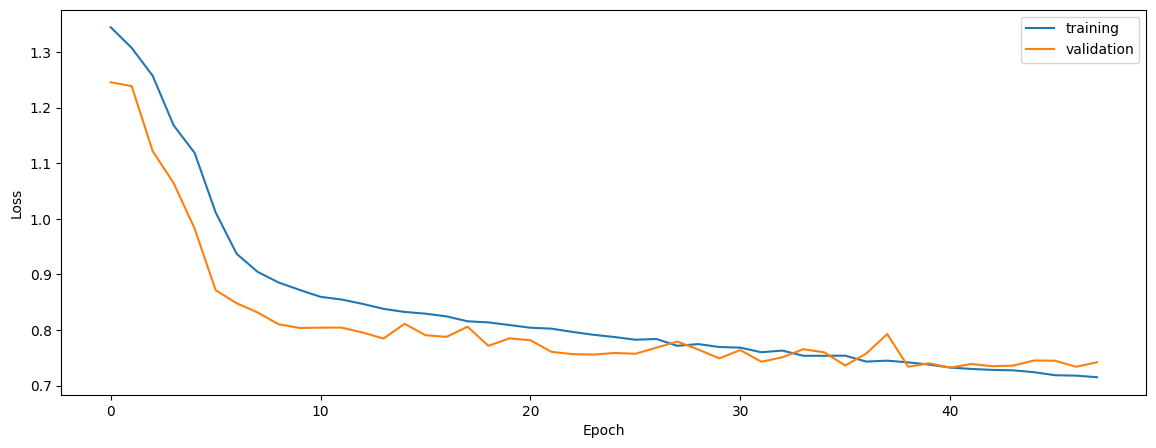

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


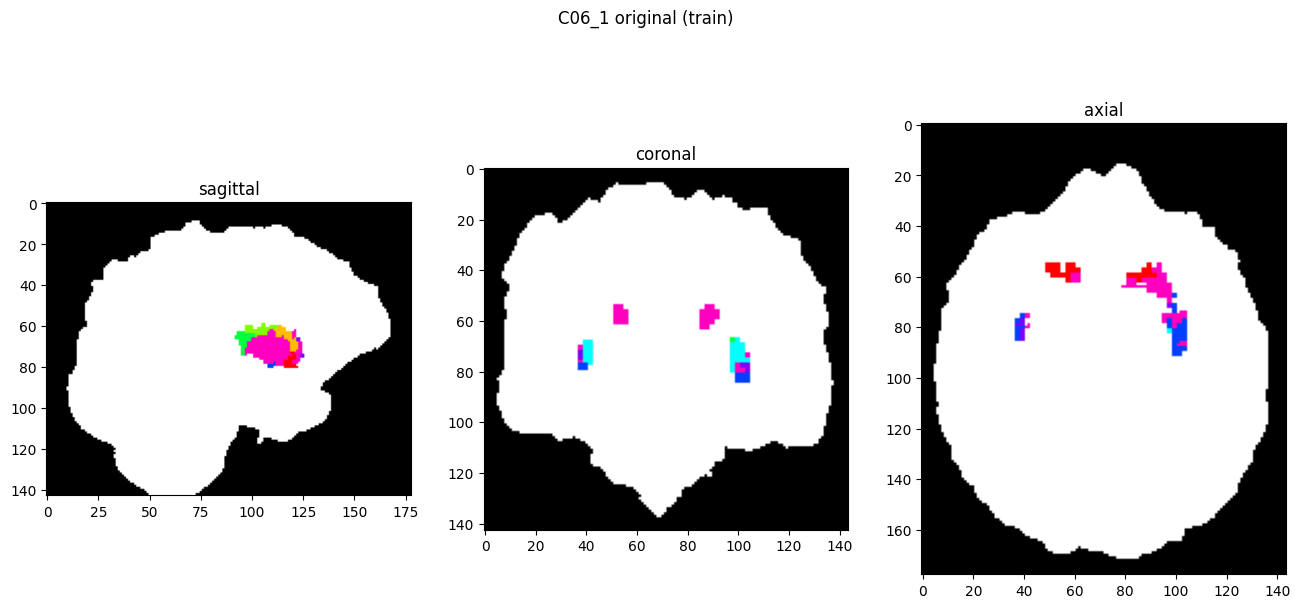

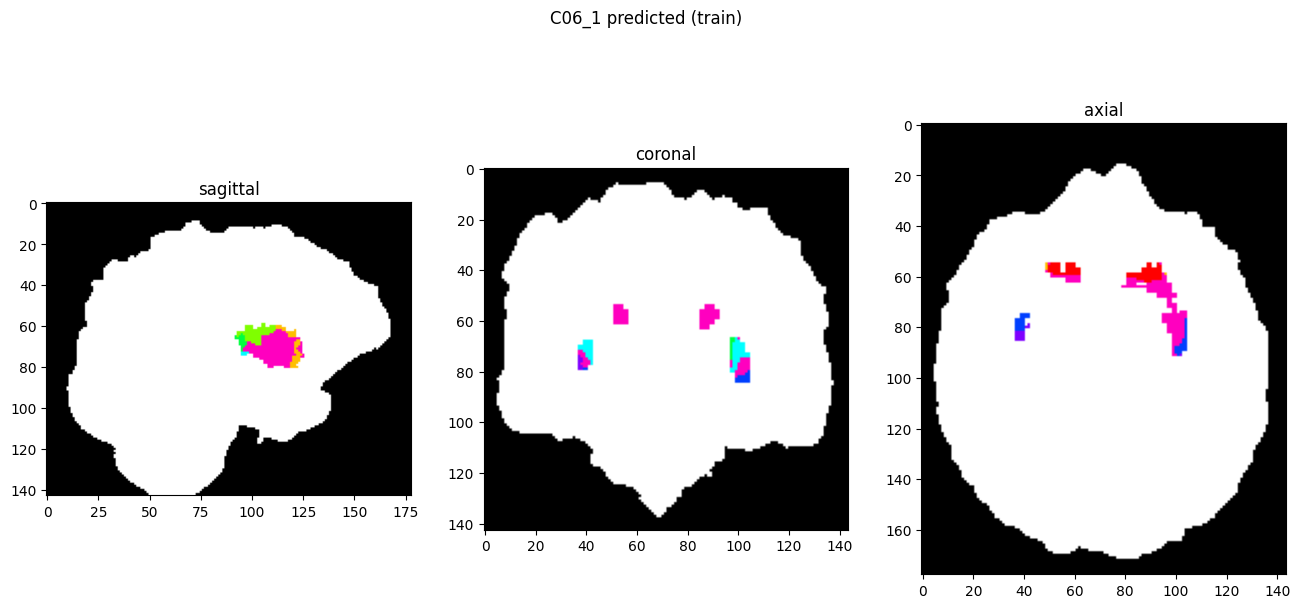

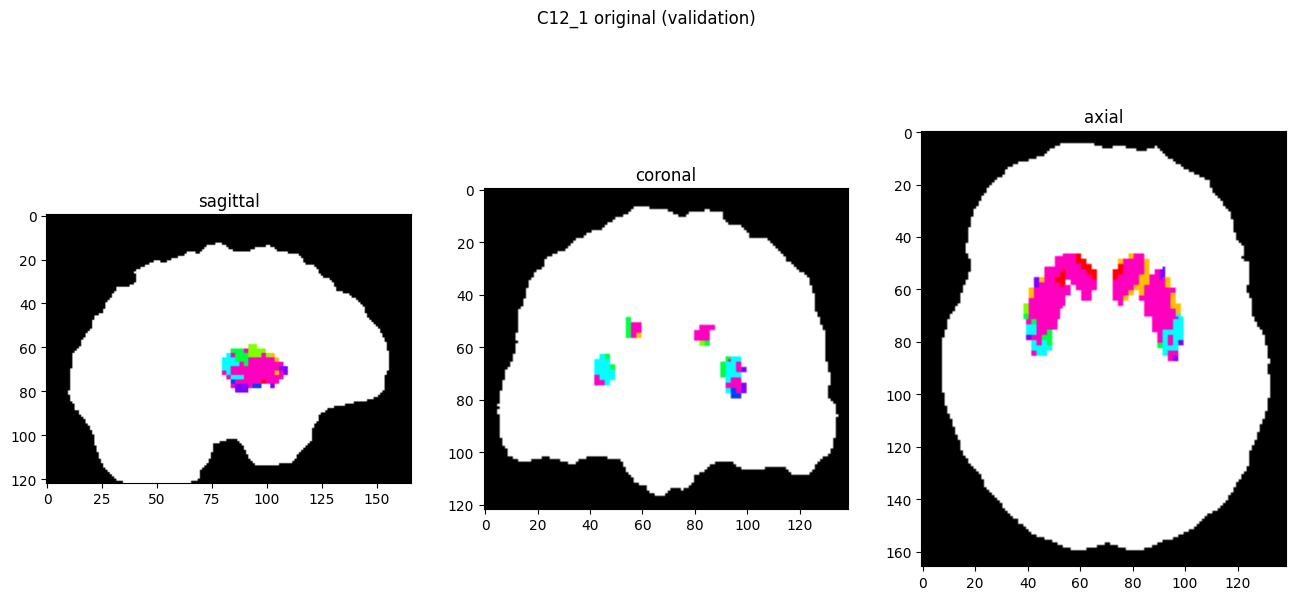

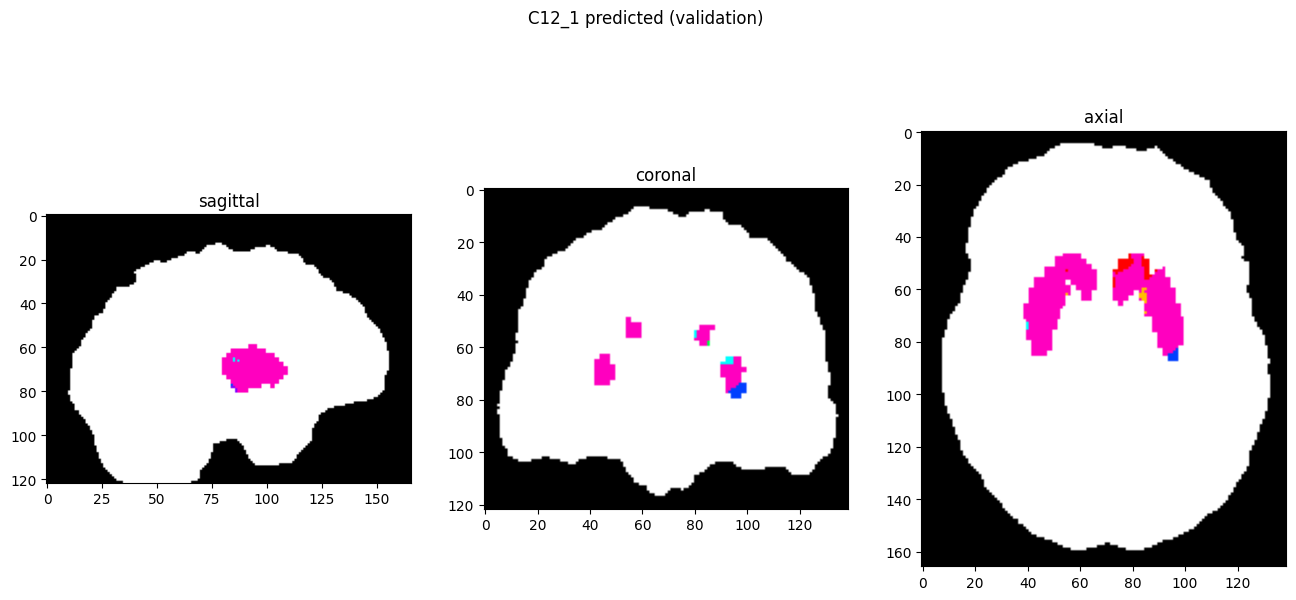

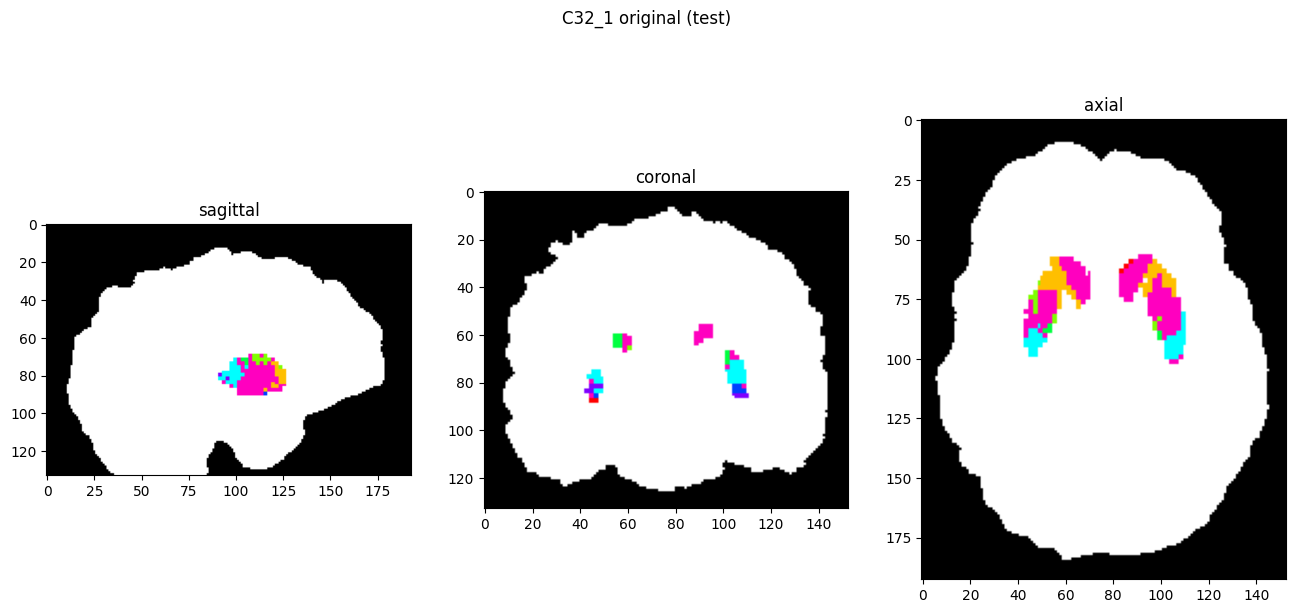

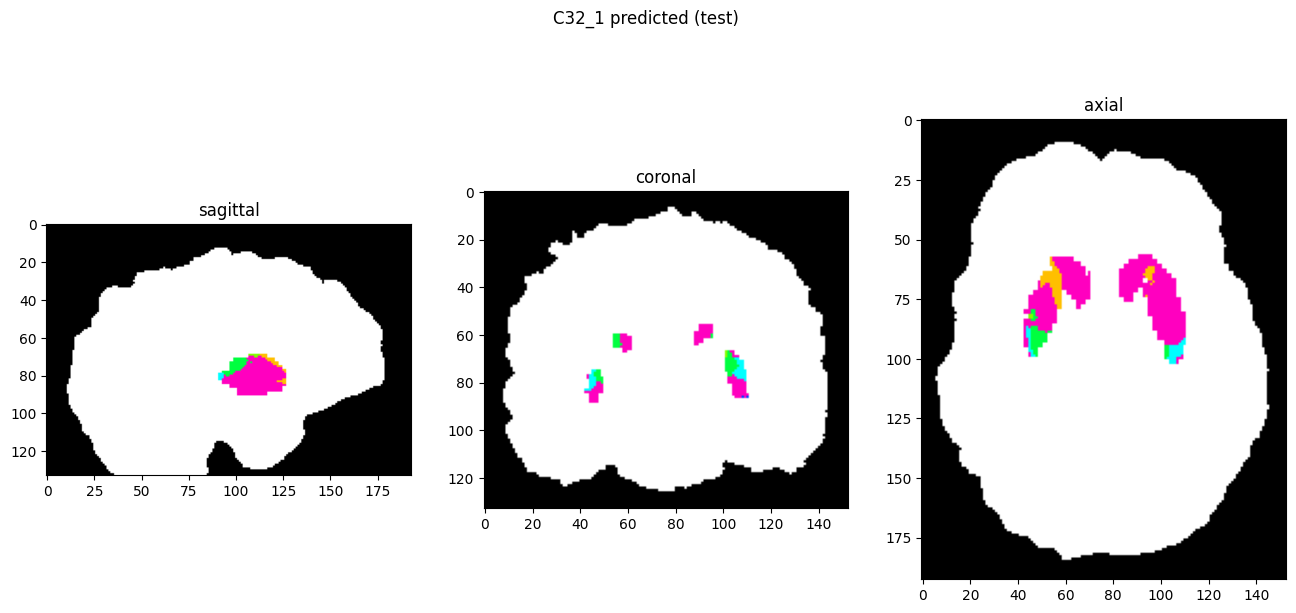

In [10]:
showResults(model, gen, threshold=0)